In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import calibration_curve
import seaborn as sns

In [2]:
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
import bigframes.pandas as bpd

In [4]:
params = {'id':'hashvalue1',
          'variable_apertura':'cdt_cant_aper_mes',
          'period_col':'periodo',
          'dataset_name': '202505'}

In [5]:
id_col = params["id"]
target_real = params['variable_apertura']
period_col  = params['period_col']
dataset_name = params['dataset_name']

%%time
df_temp = pd.read_parquet('s3://data-bbog-dev-refined/estandarizado/feature-store/599-persona-natural/feature-store_599-persona-natural_master-table-599_cds_m202505/')
print(df_temp.shape)
df_temp = df_temp[[id_col,target_real]]
df_temp.head()

In [6]:
params['ruta_output'] = {
    'metodo': 'bigframes', #
    's3' : 's3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet',
    'bigframes' : {
        'project' : "augusta-bbog-pro-activo",
        'read_gbq' : "augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL",
        # filtramos las observaciones
        'filter_value' : {
            'params' : {'period_col' : ['202505']},
            'add_vars' : {}
        },
        # filtramos las columnas requeridas
        'filter_column' : {
            'params' : ['id','variable_apertura'],
            'add_vars' : ['hashvalue1','cdt_cant_aper_mes'],
                }
            }
}

In [7]:
id_col = params["id"]
target_real = params['variable_apertura']
period_col  = params['period_col']
dataset_name = params['dataset_name']
ruta_output = params['ruta_output']

In [8]:
def filtros_query(ruta_data_real):
    filter_obs = ruta_data_real['filter_value']
    filter_cols = ruta_data_real['filter_column']
    logger.info(f'Iniciando la definicion de variables requeridas a extraer')
    cols_target = []
    for col in filter_cols['params']:
       col_name = params[col]
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    
    for col_name in filter_cols['add_vars']:
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    logger.info(f'Variables a extraer: {cols_target}')
    logger.info(f'Estructurando las condiciones de filtro de observaciones')
    dictt_filt = {}
    for col,value in zip(filter_obs['params'].keys(),filter_obs['params'].values()):
        value_query = []
        for val in value:
            print(val)
            if isinstance(val, int):
                value_query.append(int(val))
                try:
                    value_query.append(str(val))
                except:
                    pass
            elif isinstance(val, float):
                value_query.append(float(val))
                try:
                    value_query.append(str(val))
                except:
                    pass
            elif isinstance(val, str):
                value_query.append(str(val))
                try:
                    value_query.append(int(val))
                except:
                    pass
            elif isinstance(val, object):
                value_query.append(str(val))
                try:
                    value_query.append(int(val))
                except:
                    pass
            else:
                pass
            if val not in value_query:
                value_query.append(val)
        col_name = params[col]
        logger.info(f'Filtrando {value_query} en {col_name}')
        dictt_filt[col_name] = value_query
        if col_name not in list(dictt_filt.keys()):
            dictt_filt[col_name] = value_query
    logger.info(f'Finalizando los filtros sobre variables que ya estan definidas en los parametros')           

    for col_name,value in enumerate(zip(filter_obs['add_vars'].keys(),filter_obs['add_vars'].values())):
        value_query = []
        for val in value:
            if isinstance(val, int):
                value_query.append(int(val))
            elif isinstance(val, float):
                value_query.append(float(val))
            else:
                pass
            try:
                value_query.append(str(val))
            except:
                pass
            if val not in value_query:
                value_query.append(val)
        logger.info(f'Filtrando {value_query} en {col_name}')
        if col_name not in list(dictt_filt.keys()):
            dictt_filt[col_name] = value_query
    logger.info(f'Finalizando los filtros sobre variables que no estan definidas en los parametros')
    logger.info(f'Filtro de observaciones: {dictt_filt}')
    return dictt_filt,cols_target

In [9]:
def download_query(df_retail_required):

    df_retail_df = df_retail_required.to_pandas()
    return df_retail_df
    
def generate_query(ruta_data_real):
    project = ruta_data_real['project']
    read_gbq = ruta_data_real['read_gbq']
    logger.info(f'Comenzando con la definicion de variables y observaciones requeridas a extraer...')
    obs_filt,cols_target = filtros_query(ruta_data_real)
    
    # Configura tu proyecto de GCP
    logger.info("Apuntando el proyecto de datos de Bigquery...")
    bpd.options.bigquery.project = project

    logger.info("Apuntando el dataset con los filtros de información necesaria...")
    # Carga la tabla como un DataFrame
    df_retail = bpd.read_gbq(read_gbq)

    for col_name,value_query in zip(obs_filt.keys(),obs_filt.values()):
        df_retail = df_retail[ df_retail[col_name].isin(value_query)]

    df_retail_required = df_retail[cols_target] 
    ### realizando calculos extras sobre la base....
    logger.info(f'Iniciando calculos extras que se requieran')
    logger.info(f'Finalizando los calculos extras')
    logger.info('Iniciando la descarga de la base')
    df_retail_df = download_query(df_retail_required)
    logger.info('Finalizando la descarga de la base')
    return df_retail_df

In [10]:
params["adj_real_target"] = True
params["adj_real_target"]

True

In [11]:
def load_parquet(path):
    return pd.read_parquet(path)

In [17]:
%%time
metodo = ruta_output['metodo']
metodo = 's3'
if metodo == 's3': 
    ruta_data_real = ruta_output[metodo]
    logger.info("Cargando la base de datos con los resultados reales desde s3...")
    logger.info(f"{ruta_data_real}")
    df2 = load_parquet(ruta_data_real)
    try:
        df2 = df2.to_pandas()
    except Exception:
        pass
else:
    ruta_data_real = ruta_output[metodo]
    #df_retail_df = generate_query(ruta_data_real)
    df2 = generate_query(ruta_data_real)
df3 = df2.reset_index()
if params["adj_real_target"] is True:
    logger.info(
        "Ajustando la variable objetivo real. "
        f"De modo que {target_real}>0 entonces es 1 y si no es 0"
    )

    df3[target_real] = (df3[target_real] > 0).astype(int)

INFO:__main__:Cargando la base de datos con los resultados reales desde s3...
INFO:__main__:s3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet
INFO:__main__:Ajustando la variable objetivo real. De modo que cdt_cant_aper_mes>0 entonces es 1 y si no es 0


CPU times: user 1min 42s, sys: 24.8 s, total: 2min 7s
Wall time: 1min 19s


In [18]:
df3.set_index(params['id'], inplace = True)

In [19]:
df3 = df3[[target_real]]
print(df3.shape)
display(df3.head())

(4256978, 1)


cdt_cant_aper_mes
hashvalue1                      
NIT9002408522                  0
CC36726582                     0
CC16139855                     0
CC98584473                     0
CC38988622                     0

In [22]:
%%time
metodo = ruta_output['metodo']
if metodo == 's3': 
    pass
else:
    ruta_data_real = ruta_output[metodo]
    #df_retail_df = generate_query(ruta_data_real)
    df2 = generate_query(ruta_data_real)
df4 = df2.reset_index()
if params["adj_real_target"] is True:
    logger.info(
        "Ajustando la variable objetivo real. "
        f"De modo que {target_real}>0 entonces es 1 y si no es 0"
    )

    df4[target_real] = (df4[target_real] > 0).astype(int)

INFO:__main__:Comenzando con la definicion de variables y observaciones requeridas a extraer...
INFO:__main__:Iniciando la definicion de variables requeridas a extraer
INFO:__main__:Columna a descargar: hashvalue1
INFO:__main__:Columna a descargar: cdt_cant_aper_mes
INFO:__main__:Variables a extraer: ['hashvalue1', 'cdt_cant_aper_mes']
INFO:__main__:Estructurando las condiciones de filtro de observaciones
INFO:__main__:Filtrando ['202505', 202505] en periodo
INFO:__main__:Finalizando los filtros sobre variables que ya estan definidas en los parametros
INFO:__main__:Finalizando los filtros sobre variables que no estan definidas en los parametros
INFO:__main__:Filtro de observaciones: {'periodo': ['202505', 202505]}
INFO:__main__:Apuntando el proyecto de datos de Bigquery...
INFO:__main__:Apuntando el dataset con los filtros de información necesaria...
/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenti

202505


/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:379: DefaultIndexWarning: Table 'augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL' is
clustered and/or partitioned, but BigQuery DataFrames was not able to
find a suitable index. To avoid this warning, set at least one of:
`index_col` or `filters`.
  warnings.warn(msg, category=bfe.DefaultIndexWarning)
INFO:__main__:Iniciando calculos extras que se requieran
INFO:__main__:Finalizando los calculos extras
INFO:__main__:Iniciando la descarga de la base
INFO:__main__:Finalizando la descarga de la base
INFO:__main__:Ajustando la variable objetivo real. De modo que cdt_cant_aper_mes>0 entonces es 1 y si no es 0


CPU times: user 7.48 s, sys: 279 ms, total: 7.76 s
Wall time: 4min 3s


In [23]:
df4.set_index(params['id'], inplace = True)

In [24]:
df3 = df3[[target_real]]
print(df3.shape)
display(df3.head())

(4256978, 1)


cdt_cant_aper_mes
hashvalue1                      
NIT9002408522                  0
CC36726582                     0
CC16139855                     0
CC98584473                     0
CC38988622                     0

In [25]:
df4 = df4[[target_real]]
print(df4.shape)
display(df4.head())

(4256978, 1)


cdt_cant_aper_mes
hashvalue1                     
CC1065829310                  0
CC1074013185                  0
CC78755238                    0
CC20957792                    0
CC52080816                    0

In [29]:
ids_t = ['CC1070588085','CC40305180','CC17116673','CC1098638701','CC1102883460']
1,0,1,1,1

(1, 0, 1, 1, 1)

In [30]:
df3.loc[ids_t]

cdt_cant_aper_mes
hashvalue1                     
CC1070588085                  1
CC40305180                    0
CC17116673                    1
CC1098638701                  1
CC1102883460                  1

In [31]:
df4.loc[ids_t]

cdt_cant_aper_mes
hashvalue1                     
CC1070588085                  1
CC40305180                    0
CC17116673                    1
CC1098638701                  1
CC1102883460                  1

In [39]:
df5 = (df3 == df4.values).replace(True, np.nan).dropna()
ids_tt = df5.index[:6]
ids_tt

Index(['CC52478800', 'CC1065574841', 'CC39308326', 'CC1020718402',
       'CC46678798', 'CC1015451939'],
      dtype='object', name='hashvalue1')

In [40]:
df3.loc[ids_tt]

cdt_cant_aper_mes
hashvalue1                     
CC52478800                    1
CC1065574841                  0
CC39308326                    1
CC1020718402                  1
CC46678798                    0
CC1015451939                  1

In [41]:
df4.loc[ids_tt]

cdt_cant_aper_mes
hashvalue1                     
CC52478800                    1
CC1065574841                  0
CC39308326                    1
CC1020718402                  1
CC46678798                    0
CC1015451939                  1

In [59]:
df5 = pd.concat([df3,df4], axis = 1)
df5.shape

(4256978, 2)

In [62]:
df5.diff(axis = 1).describe()

cdt_cant_aper_mes  cdt_cant_aper_mes
count                0.0          4256978.0
mean                 NaN                0.0
std                  NaN                0.0
min                  NaN                0.0
25%                  NaN                0.0
50%                  NaN                0.0
75%                  NaN                0.0
max                  NaN                0.0

**PTA EN PRODUCCION:**

In [42]:
def filtros_query(ruta_data_real,params):
    filter_obs = ruta_data_real['filter_value']
    filter_cols = ruta_data_real['filter_column']
    logger.info(f'Iniciando la definicion de variables requeridas a extraer')
    cols_target = []
    if filter_cols['params'] == 'None':
        pass
    else:
        for col in filter_cols['params']:
           col_name = params[col]
           if col_name not in cols_target:
               logger.info(f'Columna a descargar: {col_name}')
               cols_target.append(col_name)

    if filter_cols['add_vars'] == 'None':
        pass
    else:
        for col_name in filter_cols['add_vars']:
           if col_name not in cols_target:
               logger.info(f'Columna a descargar: {col_name}')
               cols_target.append(col_name)
    logger.info(f'Variables a extraer: {cols_target}')
    logger.info(f'Estructurando las condiciones de filtro de observaciones')
    dictt_filt = {}
    if filter_obs['params'] == 'None':
        pass
    else:
        for col,value in zip(filter_obs['params'].keys(),filter_obs['params'].values()):
            value_query = []
            for val in value:
                print(val)
                if isinstance(val, int):
                    value_query.append(int(val))
                    try:
                        value_query.append(str(val))
                    except:
                        pass
                elif isinstance(val, float):
                    value_query.append(float(val))
                    try:
                        value_query.append(str(val))
                    except:
                        pass
                elif isinstance(val, str):
                    value_query.append(str(val))
                    try:
                        value_query.append(int(val))
                    except:
                        pass
                elif isinstance(val, object):
                    value_query.append(str(val))
                    try:
                        value_query.append(int(val))
                    except:
                        pass
                else:
                    pass
                if val not in value_query:
                    value_query.append(val)
            col_name = params[col]
            logger.info(f'Filtrando {value_query} en {col_name}')
            dictt_filt[col_name] = value_query
            if col_name not in list(dictt_filt.keys()):
                dictt_filt[col_name] = value_query
    logger.info(f'Finalizando los filtros sobre variables que ya estan definidas en los parametros')           
    if filter_obs['add_vars'] == 'None':
        pass
    else:
        for col_name,value in enumerate(zip(filter_obs['add_vars'].keys(),filter_obs['add_vars'].values())):
            value_query = []
            for val in value:
                if isinstance(val, int):
                    value_query.append(int(val))
                elif isinstance(val, float):
                    value_query.append(float(val))
                else:
                    pass
                try:
                    value_query.append(str(val))
                except:
                    pass
                if val not in value_query:
                    value_query.append(val)
            logger.info(f'Filtrando {value_query} en {col_name}')
            if col_name not in list(dictt_filt.keys()):
                dictt_filt[col_name] = value_query
    logger.info(f'Finalizando los filtros sobre variables que no estan definidas en los parametros')
    logger.info(f'Filtro de observaciones: {dictt_filt}')
    return dictt_filt,cols_target

# Funcion Auxiliar que descarga a memoria query de bigquery
def download_query(df_retail_required):

    df_retail_df = df_retail_required.to_pandas()
    return df_retail_df

# Funcion Auxiliar que ejecuta el query de bigquery
def generate_query(ruta_data_real,params):
    project = ruta_data_real['project']
    read_gbq = ruta_data_real['read_gbq']
    logger.info(f'Comenzando con la definicion de variables y observaciones requeridas a extraer...')
    obs_filt,cols_target = filtros_query(ruta_data_real,params)
    
    # Configura tu proyecto de GCP
    logger.info("Apuntando el proyecto de datos de Bigquery...")
    bpd.options.bigquery.project = project

    logger.info("Apuntando el dataset con los filtros de información necesaria...")
    # Carga la tabla como un DataFrame
    df_retail = bpd.read_gbq(read_gbq)

    for col_name,value_query in zip(obs_filt.keys(),obs_filt.values()):
        df_retail = df_retail[ df_retail[col_name].isin(value_query)]

    df_retail_required = df_retail[cols_target] 
    ### realizando calculos extras sobre la base....
    logger.info(f'Iniciando calculos extras que se requieran')
    logger.info(f'Finalizando los calculos extras')
    logger.info('Iniciando la descarga de la base')
    df_retail_df = download_query(df_retail_required)
    logger.info('Finalizando la descarga de la base')
    return df_retail_df

In [43]:
    # Parámetros
    id_col = params["id"] 
    target_real = params["variable_apertura"]

    # Ajustes data real
    ruta_output = params["ruta_output"]
    metodo = ruta_output['metodo']
    logger.info("Cargando la base de datos con los resultados reales...")

    metodo

INFO:__main__:Cargando la base de datos con los resultados reales...


'bigframes'

In [44]:
    # extraccion de bases de datos
    if metodo == 's3': 
        ruta_data_real = ruta_output[metodo]
        logger.info("Cargando la base de datos con los resultados reales desde s3...")
        logger.info(f"{ruta_data_real}")
        df2 = load_parquet(ruta_data_real)
        try:
            df2 = df2.to_pandas()
        except Exception:
            pass
    else:
        ruta_data_real = ruta_output[metodo]
        df2 = generate_query(ruta_data_real, params)


INFO:__main__:Comenzando con la definicion de variables y observaciones requeridas a extraer...
INFO:__main__:Iniciando la definicion de variables requeridas a extraer
INFO:__main__:Columna a descargar: hashvalue1
INFO:__main__:Columna a descargar: cdt_cant_aper_mes
INFO:__main__:Variables a extraer: ['hashvalue1', 'cdt_cant_aper_mes']
INFO:__main__:Estructurando las condiciones de filtro de observaciones
INFO:__main__:Filtrando ['202505', 202505] en periodo
INFO:__main__:Finalizando los filtros sobre variables que ya estan definidas en los parametros
INFO:__main__:Finalizando los filtros sobre variables que no estan definidas en los parametros
INFO:__main__:Filtro de observaciones: {'periodo': ['202505', 202505]}
INFO:__main__:Apuntando el proyecto de datos de Bigquery...
INFO:__main__:Apuntando el dataset con los filtros de información necesaria...
/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/core/log_adapter.py:175: TimeTravelCacheWarning: Reading cac

202505


INFO:__main__:Iniciando calculos extras que se requieran
INFO:__main__:Finalizando los calculos extras
INFO:__main__:Iniciando la descarga de la base
INFO:__main__:Finalizando la descarga de la base


In [45]:
df2

hashvalue1  cdt_cant_aper_mes
22          CC1065829310                  0
27          CC1074013185                  0
60            CC78755238                  0
75            CC20957792                  0
117           CC52080816                  0
...                  ...                ...
130802133     CC12130826                  0
130802164  NIT9006003390                  0
130802184   CC1110562450                  0
130802217     CC24476552                  0
130802226     CC72271955                  0

[4256978 rows x 2 columns]

In [46]:
    df3 = df2.reset_index()
    if params["adj_real_target"] is True:
        logger.info(
            "Ajustando la variable objetivo real. "
            f"De modo que {target_real}>0 entonces es 1 y si no es 0"
        )
    
        df3[target_real] = (df3[target_real] > 0).astype(int)
    df3

INFO:__main__:Ajustando la variable objetivo real. De modo que cdt_cant_aper_mes>0 entonces es 1 y si no es 0


index     hashvalue1  cdt_cant_aper_mes
0               22   CC1065829310                  0
1               27   CC1074013185                  0
2               60     CC78755238                  0
3               75     CC20957792                  0
4              117     CC52080816                  0
...            ...            ...                ...
4256973  130802133     CC12130826                  0
4256974  130802164  NIT9006003390                  0
4256975  130802184   CC1110562450                  0
4256976  130802217     CC24476552                  0
4256977  130802226     CC72271955                  0

[4256978 rows x 3 columns]

**Version compleja:**

In [5]:
params['ruta_output'] = {
    'metodo': 'bigframes', #
    's3' : 's3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet',
    'bigframes' : {
        'project' : "augusta-bbog-pro-activo",
        'read_gbq' : "augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL",
        # filtramos las observaciones
        'filter_value' : {
            'params' : {'period_col' : ['202505']}
            ,'add_vars' : {}
        },
        # filtramos las columnas requeridas
        'filter_column' : {
            'params' : ['id','variable_apertura'],
            'add_vars' : ['hashvalue1','cdt_cant_aper_mes'],
                }
            }
}

In [6]:
id_col = params["id"]
target_real = params['variable_apertura']
period_col  = params['period_col']
dataset_name = params['dataset_name']
ruta_output = params['ruta_output']

In [9]:
def calculate_query(df_retail, ruta_data_real):
    filter_obs = ruta_data_real['filter_value']
    filter_cols = ruta_data_real['filter_column']
    logger.info(f'Iniciando los filtros de observaciones')
    for t,(col,value) in enumerate(zip(filter_obs['params'].keys(),filter_obs['params'].values())):
        value_query = []
        for val in value:
            if isinstance(val, int):
                value_query.append(int(val))
            elif isinstance(val, float):
                value_query.append(float(val))
            else:
                pass
            try:
                value_query.append(str(val))
            except:
                pass
            if val not in value_query:
                value_query.append(val)
        col_name = params[col]
        logger.info(f'Filtrando {value_query} en {col_name}')
        if t == 0:
            condition1 = df_retail[col_name].isin([value_query])
        else:
            condition1 = condition1 & df_retail[col_name].isin([value_query])
    for t,(col_name,value) in enumerate(zip(filter_obs['add_vars'].keys(),filter_obs['add_vars'].values())):
        value_query = []
        for val in value:
            if isinstance(val, int):
                value_query.append(int(val))
            elif isinstance(val, float):
                value_query.append(float(val))
            else:
                pass
            try:
                value_query.append(str(val))
            except:
                pass
            if val not in value_query:
                value_query.append(val)
        logger.info(f'Filtrando {value_query} en {col_name}')
        if t == 0:
            condition2 = df_retail[col_name].isin([value_query])
        else:
            condition2 = condition2 & df_retail[col_name].isin([value_query])
    sin_filtro = False
    try:
        condition = condition1 & condition2
    except:
        try: 
            try:
                condition = condition1
            except:
                condition = condition2
        except:
            sin_filtro = True
    
    cols_target = []
    logger.info(f'Iniciando la definicion de variables requeridas')
    for col in filter_cols['params']:
       col_name = params[col]
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    
    for col_name in filter_cols['add_vars']:
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    
    logger.info(f'Aplicando los filtros en el query')
    if sin_filtro:
        df_retail_required = df_retail[cols_target] 
    else:
        # Convierte a pandas para visualización local
        df_retail_required = df_retail[condition][cols_target]
    ### realizando calculos extras sobre la base....
    logger.info(f'Iniciando los calculos extras')
    logger.info(f'Finalizando los calculos extras')
    return df_retail_required

In [17]:
def calculate_query2(df_retail, ruta_data_real):
    filter_obs = ruta_data_real['filter_value']
    filter_cols = ruta_data_real['filter_column']
    logger.info(f'Iniciando los filtros de observaciones')
    sin_filtro = True

    for t,(col,value) in enumerate(zip(filter_obs['params'].keys(),filter_obs['params'].values())):
        value_query = []
        for val in value:
            if isinstance(val, int):
                value_query.append(int(val))
            elif isinstance(val, float):
                value_query.append(float(val))
            else:
                pass
            try:
                value_query.append(str(val))
            except:
                pass
            if val not in value_query:
                value_query.append(val)
        col_name = params[col]
        logger.info(f'Filtrando {value_query} en {col_name}')
        df_retail = df_retail[df_retail[col_name].isin([value_query])]
        sin_filtro = False

    for t,(col_name,value) in enumerate(zip(filter_obs['add_vars'].keys(),filter_obs['add_vars'].values())):
        value_query = []
        for val in value:
            if isinstance(val, int):
                value_query.append(int(val))
            elif isinstance(val, float):
                value_query.append(float(val))
            else:
                pass
            try:
                value_query.append(str(val))
            except:
                pass
            if val not in value_query:
                value_query.append(val)
        logger.info(f'Filtrando {value_query} en {col_name}')
        df_retail = df_retail[df_retail[col_name].isin([value_query])]
        sin_filtro = False
    
    cols_target = []
    logger.info(f'Iniciando la definicion de variables requeridas')
    for col in filter_cols['params']:
       col_name = params[col]
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    
    for col_name in filter_cols['add_vars']:
       if col_name not in cols_target:
           logger.info(f'Columna a descargar: {col_name}')
           cols_target.append(col_name)
    
    logger.info(f'Aplicando los filtros en el query')
    df_retail_required = df_retail[cols_target] 
    ### realizando calculos extras sobre la base....
    logger.info(f'Iniciando los calculos extras')
    logger.info(f'Finalizando los calculos extras')
    return df_retail_required

In [19]:
def download_query(df_retail_required):
    df_retail_df = df_retail_required.to_pandas()
    return df_retail_df
    
def generate_query(ruta_data_real):
    # Configura tu proyecto de GCP
    logger.info("Cargando la base de datos con los resultados reales desde Bigquery...")
    bpd.options.bigquery.project = ruta_data_real['project']
    
    # Carga la tabla como un DataFrame
    df_retail = bpd.read_gbq(ruta_data_real['read_gbq'])
    logger.info("Generando los calculos requeridos para descargar la informacion a Memoria...")
    df_retail_required = calculate_query2(df_retail,ruta_data_real)
    logger.info('Iniciando la descarga de la base')
    df_retail_df = download_query(df_retail_required)
    return df_retail_df

In [8]:
metodo = ruta_output['metodo']
if metodo == 's3': 
    ruta_data_real = ruta_output[metodo]
    logger.info("Cargando la base de datos con los resultados reales desde s3...")
    logger.info(f"{ruta_data_real}")
    df2 = load_parquet(ruta_data_real)
    try:
        df2 = df2.to_pandas()
    except Exception:
        pass
    df3 = df2.reset_index()
else:
    ruta_data_real = ruta_output[metodo]
    df_retail_df = generate_query(ruta_data_real)

In [20]:
ruta_data_real

{'project': 'augusta-bbog-pro-activo',
 'read_gbq': 'augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL',
 'filter_value': {'params': {'period_col': ['202505']}, 'add_vars': {}},
 'filter_column': {'params': ['id', 'variable_apertura'],
  'add_vars': ['hashvalue1', 'cdt_cant_aper_mes']}}

In [21]:
df_retail_df = generate_query(ruta_data_real)

INFO:__main__:Cargando la base de datos con los resultados reales desde Bigquery...
/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/core/log_adapter.py:175: TimeTravelCacheWarning: Reading cached table from 2025-08-21 19:21:45.137099+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)
/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:379: DefaultIndexWarning: Table 'augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL' is
clustered and/or partitioned, but BigQuery DataFrames was not able to
find a suitable index. To avoid this warning, set at least one of:
`index_col` or `filters`.
  warnings.warn(msg, category=bfe.DefaultIndexWarning)
INFO:__main__:Generando los calculos requeridos para descargar la informacio

TypeError: unhashable type: 'list'

In [37]:
%%time
# Muestra las primeras filas
display(df_retail_required2.head())

hashvalue1  cdt_cant_aper_mes
3    CC1064978844                  0
61     CC50987376                  0
97     CC12551075                  0
140  CC1048208548                  0
153     CC3488342                  0

[5 rows x 2 columns]

CPU times: user 23.4 s, sys: 0 ns, total: 23.4 s
Wall time: 5min 17s


In [38]:
compare = pd.merge(df_temp,df_retail_required2, on = 'hashvalue1')
(compare[f'{target_real}_x']-compare[f'{target_real}_y']).describe()

TypeError: Can only merge Series or DataFrame objects, a <class 'bigframes.dataframe.DataFrame'> was passed

**Solucion sencilla:**

In [22]:
%%time
# Configura tu proyecto de GCP
bpd.options.bigquery.project = "augusta-bbog-pro-activo"

# Carga la tabla como un DataFrame
df_retail = bpd.read_gbq("augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL")
# Procesa los datos como si fuera pandas
df_retail_required = (
    df_retail[df_retail[period_col].isin([dataset_name,int(dataset_name)])]  # Convierte a pandas para visualización local
        )

df_retail_required = df_retail_required[[id_col,target_real]].to_pandas()
display(df_retail_required.head(1000))
print('Ok')

hashvalue1  cdt_cant_aper_mes
22      CC1065829310                  0
27      CC1074013185                  0
60        CC78755238                  0
75        CC20957792                  0
117       CC52080816                  0
...              ...                ...
31512   CC1032363361                  0
31552      CC2933925                  0
31558  NIT9006220638                  0
31599     CC87433881                  0
31607   CC1007468602                  0

[1000 rows x 2 columns]

In [9]:
%%time
# Configura tu proyecto de GCP
bpd.options.bigquery.project = "augusta-bbog-pro-activo"

# Carga la tabla como un DataFrame
df_retail = bpd.read_gbq("augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL")
# Procesa los datos como si fuera pandas
df_retail_required = (
    df_retail[df_retail[period_col].isin([dataset_name,int(dataset_name)])][[id_col,target_real]].to_pandas()  # Convierte a pandas para visualización local
)

print('Ok')

/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/core/log_adapter.py:175: TimeTravelCacheWarning: Reading cached table from 2025-08-20 14:35:48.586741+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)
/home/sagemaker-user/.conda/envs/.env/lib/python3.12/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:379: DefaultIndexWarning: Table 'augusta-bbog-pro-activo.transit_input.FEAUTURE_RETAIL' is
clustered and/or partitioned, but BigQuery DataFrames was not able to
find a suitable index. To avoid this warning, set at least one of:
`index_col` or `filters`.
  warnings.warn(msg, category=bfe.DefaultIndexWarning)


Ok
CPU times: user 19.1 s, sys: 389 ms, total: 19.5 s
Wall time: 5min 33s


In [11]:
%%time
# Muestra las primeras filas
display(df_retail_required.head())

hashvalue1  cdt_cant_aper_mes
3    CC1064978844                  0
61     CC50987376                  0
97     CC12551075                  0
140  CC1048208548                  0
153     CC3488342                  0

CPU times: user 5.97 ms, sys: 62 μs, total: 6.03 ms
Wall time: 5.03 ms


In [ ]:
compare = pd.merge(df_temp,df_retail_required, on = 'hashvalue1')
(compare[f'{target_real}_x']-compare[f'{target_real}_y']).describe()

In [2]:
os.chdir("/home/sagemaker-user/data-bbog-integration-fabrica-personas/src")
import data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes as backtesting
import data_bbog_integration_fabrica_personas.pipelines.model_selection.nodes as ms
import data_bbog_integration_fabrica_personas.pipelines.model_output.nodes as mo

In [3]:
import boto3
import pickle
import io

## Ejecucion Pipeline de Backtesting

In [4]:
x_dim_plot = 1000
# parametro que sustituye params['n_obs_filters'] hasta calcular la curva de backtesting
n_obs_backtesting = 'all' #'all',float, si no es esto usara el params['n_obs_filters']
# cortes para visualizar la curva del backtesting
n_tops = [10000,25000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# ajuste de los filtros para predecir. Son filtros de intermediate condicionados o filtros acumulados
re_ajuste_filtros_backtesting = {
    'want' :  False,
    'filter_segment': {
        '1er_condicion' :  {
            'column' :  'segmento_cliente',
            'value' :  ['_masivo', '_preferente', '_premium'] # debe ir separado de una , y un espacio: ', '
#       2da_condicion:
#           column: segmento_cliente
#           value: _preferente  # puede solo un string
    }}}

# ajuste de los filtros de negocio para predecir. Son filtros de primary condicionados o filtros acumulados
re_ajuste_filtros_negocio_backtesting = {
    'want': False,
    'filter_business': {
        'edad_anios': [18,70]
        #ratio_deuda_ingresos: ">0"
    }}
# La variable objetivo es un numero de aperturas entonces se coloca True transforma la variable para analizar si aperturo o no
adj_real_target = True

# parametros asociados a los insumos del modelo 360
column_pend = '% Aciertos' #% Aciertos,Aciertos, % Aciertos x Cliente.
tipo = "Freq Producto" # 'ID', 'Freq Producto'
n_mult = 1000 # magnitud en que la pendiente se ve afectada: pendiente = df[column_pend].diff() / (df['N'].diff()/n_mult)

In [5]:
parametros = {
              'x_dim_plot':x_dim_plot,  
              'n_obs_backtesting':n_obs_backtesting,
              're_ajuste_filtros_backtesting': re_ajuste_filtros_backtesting,
              'adj_real_target':adj_real_target,      
              're_ajuste_filtros_negocio_backtesting':re_ajuste_filtros_negocio_backtesting,
              'n_tops':n_tops,
              'column_pend':column_pend,
              'tipo':tipo,
              'n_mult':n_mult,  
             }

In [6]:
vinculacion_productos = {
    'ah_cant_aper_mes': 'AH',
    'cc_cant_aper_mes': 'CC',
    'cdt_cant_aper_mes': 'CDT',
    'cs_cant_aper_mes': 'CS',
    'fid_cant_aper_mes': 'FID',
    'ld_cant_aper_mes': 'LD',
    'lib_cant_aper_mes': 'libranza',
    'sus_cant_aper_mes': 'SP',
    'tc_cant_aper_mes': 'TC',
    'viv_cant_aper_mes': 'VIV',
    'veh_cant_aper_mes': 'VEH'
    }

todas_variables_apertura = {
    'fid_cant_aper_mes': 'fid_cant_ap_group3',
    'tc_cant_aper_mes': 'tc_target_ap_group3',
    'sus_cant_aper_mes': 'sus_target_ap_group3',
    'cs_cant_aper_mes': 'cs_target_ap_group3',
    'ld_cant_aper_mes': 'ld_target_ap_group3',
    'ah_cant_aper_mes': 'ah_target_ap_group3',
    'cc_cant_aper_mes': 'cc_target_ap_group3',
    'viv_cant_aper_mes': 'viv_cant_ap_group3',
    'cdt_cant_aper_mes': 'cdt_target_ap_group3',
    'lib_cant_aper_mes': 'lib_target_ap_group3',
    'veh_cant_aper_mes': 'veh_target_ap_group3'
}

In [7]:
prod = 'CDT'

In [8]:
for variable_apertura in list(vinculacion_productos.keys()):
    if prod == vinculacion_productos[variable_apertura]:
        target = todas_variables_apertura[variable_apertura]
        print(variable_apertura,target)
        break

cdt_cant_aper_mes cdt_target_ap_group3


In [9]:
parametros['target'] = target
parametros['id'] = 'hashvalue1'
parametros['variable_apertura'] = variable_apertura
parametros['n_obs_filter_select'] = 0.3
parametros['n_obs_filter'] = 1
parametros['fecha_ejecucion'] = '202504'

### Cargando modelos manualmente:

In [10]:
#--------CAPA FEATURE
hom_ruta = f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/{prod}/04-feature/homologate_region_model.pickle'
  
feat_selected_ruta = f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/{prod}/04-feature/feature_selected_list.parquet'
# ------CAPA MODEL SELECTION:
info_model_ruta =f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/{prod}/07-model_selection/info_save_select.pickle'
info_model_ruta

's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/CDT/07-model_selection/info_save_select.pickle'

In [11]:
# Parámetros
bucket_name = 'data-bbog-dev-sandbox-entity'
key = f'casos-uso/fabrica/{prod}/07-model_selection/info_save_select.pickle'

# Cliente S3
s3 = boto3.client('s3')

# Descargar el archivo desde S3 como un objeto en memoria
response = s3.get_object(Bucket=bucket_name, Key=key)
body = response['Body'].read()

# Cargar el objeto pickle
info_save_select = pickle.loads(body)

# Verificamos el tipo de objeto cargado
print(type(info_save_select))
print(info_save_select.keys())
print(info_save_select['modelo_produccion']['weights'])

<class 'dict'>
dict_keys(['modelo_produccion', 0, 1, 2, 3, 5, 6, 7, 10, 11, 'Votaciones', 'select_model2', 'all_results_select_model'])
[2, 1, 2, 1, 1, 2, 1, 1, 0]


In [12]:
print(feat_selected_ruta)
feature_selected_list = pd.read_parquet(feat_selected_ruta)
print(feature_selected_list.shape)
feature_selected_list.head(3)

s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/CDT/04-feature/feature_selected_list.parquet
(25, 2)


Feature  Importance
38  ah_sum_monto_trx_credito_std_6    0.235997
45                   cdt_cant_prev    0.158300
44                        cdt_cant    0.141022

In [13]:
# Parámetros
print(hom_ruta)
bucket_name = 'data-bbog-dev-sandbox-entity'
key = f'casos-uso/fabrica/{prod}/04-feature/homologate_region_model.pickle'

# Cliente S3
s3 = boto3.client('s3')

# Descargar el archivo desde S3 como un objeto en memoria
response = s3.get_object(Bucket=bucket_name, Key=key)
body = response['Body'].read()

# Cargar el objeto pickle
homologate_region_model = pickle.loads(body)

# Verificamos el tipo de objeto cargado
print(type(homologate_region_model))
print(homologate_region_model.keys())

s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica/CDT/04-feature/homologate_region_model.pickle
<class 'dict'>
dict_keys(['variable1', 'variable2', 'variable3', 'variable4', 'variable5'])


### Parametros de cortes de tiempo:

In [14]:
corte = 202505

In [15]:
# rezago predictivo, corte de la base, ruta de la base
rutas_inputs = [[1,str(corte-1),f's3://data-bbog-dev-refined/estandarizado/feature-store/599-persona-natural/feature-store_599-persona-natural_master-table-599_cds_m{corte-1}/'], 
                [2,str(corte-2),f's3://data-bbog-dev-refined/estandarizado/feature-store/599-persona-natural/feature-store_599-persona-natural_master-table-599_cds_m{corte-2}/'],
                [3,str(corte-3),f's3://data-bbog-dev-refined/estandarizado/feature-store/599-persona-natural/feature-store_599-persona-natural_master-table-599_cds_m{corte-3}/']]

# ruta de resultados reales
ruta_output =  f's3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/{corte}/data_pd_read_parquet.parquet'
ruta_output

's3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet'

In [16]:
parametros['rutas_inputs'] = rutas_inputs
parametros['ruta_output'] = ruta_output

**Nuevos Parametros:**

In [17]:
prod

'CDT'

In [18]:
monitoreo = {'want':True,
             'rutas_inputs':
                   [
                    [1,str(corte-1),f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/08-model_output/base_calificada_nueva_{corte}.parquet'], 
                    [2,str(corte-2),f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/08-model_output/base_calificada_nueva_{corte-1}.parquet'],
                    #[3,str(corte-91),f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/08-model_output/base_calificada_nueva_{corte-90}.parquet']
                    [3,str(corte-3),f's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/08-model_output/base_calificada_nueva_{corte-2}.parquet']
                   ],
            }

In [24]:
ruta_output

's3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet'

In [19]:
parametros['monitoreo'] = monitoreo

In [20]:
monitoreo

{'want': True,
 'rutas_inputs': [[1,
   '202504',
   's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/08-model_output/base_calificada_nueva_202505.parquet'],
  [2,
   '202503',
   's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/08-model_output/base_calificada_nueva_202504.parquet'],
  [3,
   '202502',
   's3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/08-model_output/base_calificada_nueva_202503.parquet']]}

In [21]:

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


### Incorporacion de monitoreo/re-entrenamiento

In [22]:
from typing import Any, Dict
import data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes as backtesting

In [23]:
parametros['monitoreo']['want'] = True
parametros['monitoreo']['want']

True

In [25]:
%%time
data_process,nombre_modelo = backtesting.prepare_data_pd(feature_selected_list,homologate_region_model, info_save_select, parametros)
print(data_process.keys())
print(nombre_modelo)

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Se hara el backtesting sobre todos los pronosticos
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Data con rezago t-1
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Periodo predicho a cargar : 202504
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Ruta: s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/08-model_output/base_calificada_nueva_202505.parquet
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Numero de Pronosticos 4248944
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Numero de predicciones True 849788
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Numero de observaciones con P(x>0) 4248944
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Enlace de Pilotaje a MLops
INFO:data_bbog_integration_fabrica_personas.pipelines.backt

dict_keys([1, 2, 3, 'Combined'])
Ensamble,
CPU times: user 1min 4s, sys: 6.48 s, total: 1min 10s
Wall time: 1min 13s


##### Cada corte se demora:

* 21:45 min-21:32 min = 13 minutos
* Luego todo el primer nodo se demoraria unos 39 minutos y pasamos a demorarse 1 minuto

In [26]:
print(data_process.keys())

dict_keys([1, 2, 3, 'Combined'])


In [27]:
data_process[1]['contactabilidad'].head()

10000.0       25000.0       40000.0       60000.0       80000.0   \
0  CC1070588085  CC1070588085  CC1070588085  CC1070588085  CC1070588085   
1    CC40305180    CC40305180    CC40305180    CC40305180    CC40305180   
2    CC17116673    CC17116673    CC17116673    CC17116673    CC17116673   
3  CC1098638701  CC1098638701  CC1098638701  CC1098638701  CC1098638701   
4  CC1102883460  CC1102883460  CC1102883460  CC1102883460  CC1102883460   

       100000.0      120000.0      140000.0      160000.0      180000.0  ...  \
0  CC1070588085  CC1070588085  CC1070588085  CC1070588085  CC1070588085  ...   
1    CC40305180    CC40305180    CC40305180    CC40305180    CC40305180  ...   
2    CC17116673    CC17116673    CC17116673    CC17116673    CC17116673  ...   
3  CC1098638701  CC1098638701  CC1098638701  CC1098638701  CC1098638701  ...   
4  CC1102883460  CC1102883460  CC1102883460  CC1102883460  CC1102883460  ...   

       0.1           0.2           0.3           0.4           0.5       \
0  CC1070588085  CC1070588085  CC1070588085  CC1070588085  CC1070588085   
1    CC40305180    CC40305180    CC40305180    CC40305180    CC40305180   
2    CC17116673    CC17116673    CC17116673    CC17116673    CC17116673   
3  CC1098638701  CC1098638701  CC1098638701  CC1098638701  CC1098638701   
4  CC1102883460  CC1102883460  CC1102883460  CC1102883460  CC1102883460   

       0.6           0.7           0.8           0.9           1.0       
0  CC1070588085  CC1070588085  CC1070588085  CC1070588085  CC1070588085  
1    CC40305180    CC40305180    CC40305180    CC40305180    CC40305180  
2    CC17116673    CC17116673    CC17116673    CC17116673    CC17116673  
3  CC1098638701  CC1098638701  CC1098638701  CC1098638701  CC1098638701  
4  CC1102883460  CC1102883460  CC1102883460  CC1102883460  CC1102883460  

[5 rows x 22 columns]

In [28]:
data_process[1]['prediccion'].head()

periodo    hashvalue1  y_pred  y_pred_proba
0  202505  CC1070588085       1      0.169879
1  202505    CC40305180       1      0.169875
2  202505    CC17116673       1      0.169786
3  202505  CC1098638701       1      0.169754
4  202505  CC1102883460       1      0.169675

In [29]:
data_process[1].keys()

dict_keys(['contactabilidad', 'prediccion', 'prepare_data', 'dataset_name'])

In [30]:
data_process_copy = data_process.copy()

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Cargando la base de datos con los resultados reales...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:s3://data-bbog-dev-sandbox-entity/casos-uso/recuperacion-clientes/retail/202505/data_pd_read_parquet.parquet
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Ajustando la variable objetivo real. De modo que cdt_cant_aper_mes>0 entonces es 1 y si no es 0
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando el cruce de informacion entre los pronosticos y los resultados reales
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Encontramos 92205 personas con pronostico y sin la apertura real. Datos con el rezago: 1


periodo    hashvalue1  y_pred  y_pred_proba  y_real
0  202505  CC1070588085       1      0.169879     1.0
1  202505    CC40305180       1      0.169875     0.0
2  202505    CC17116673       1      0.169786     1.0
3  202505  CC1098638701       1      0.169754     1.0
4  202505  CC1102883460       1      0.169675     1.0

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculamos los insumos para tener la curva de calibracion del modelo para el rezago 1...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando 10 grupos a partir de las probabilidades predichas...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Cantidad de grupos: 10
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Grupos: [10  9  8  7  6  5  4  3  2  1]
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Guardamos los resultados para el rezago 1...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Encontramos 173961 personas con pronostico y sin la apertura real. Datos con el rezago: 2


periodo    hashvalue1  y_pred  y_pred_proba  y_real
0  202504  CC1010030709       1      0.169768     0.0
1  202504    CC40094270       1      0.169645     0.0
2  202504    CC79219192       1      0.169616     1.0
3  202504  CC1001835729       1      0.169607     1.0
4  202504    CC72307980       1      0.169599     1.0

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculamos los insumos para tener la curva de calibracion del modelo para el rezago 2...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando 10 grupos a partir de las probabilidades predichas...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Cantidad de grupos: 10
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Grupos: [10  9  8  7  6  5  4  3  2  1]
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Guardamos los resultados para el rezago 2...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Encontramos 252262 personas con pronostico y sin la apertura real. Datos con el rezago: 3


periodo    hashvalue1  y_pred  y_pred_proba  y_real
0  202503  CC1007263038       1      0.169950     1.0
1  202503    CC63289374       1      0.169682     0.0
2  202503  CC1054925828       1      0.169666     0.0
3  202503    CC71362058       1      0.169650     0.0
4  202503    CC93119780       1      0.169606     0.0

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculamos los insumos para tener la curva de calibracion del modelo para el rezago 3...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando 10 grupos a partir de las probabilidades predichas...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Cantidad de grupos: 10
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Grupos: [10  9  8  7  6  5  4  3  2  1]
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Guardamos los resultados para el rezago 3...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Encontramos 232363 personas con pronostico y sin la apertura real. Datos con el rezago: Combined


hashvalue1  y_pred_proba  y_pred  y_real
0  CC1007263038      0.169950       1     1.0
1  CC1070588085      0.169879       1     1.0
2    CC40305180      0.169875       1     0.0
3    CC17116673      0.169786       1     1.0
4  CC1010030709      0.169768       1     0.0

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculamos los insumos para tener la curva de calibracion del modelo para el rezago Combined...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando 10 grupos a partir de las probabilidades predichas...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Cantidad de grupos: 10
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Grupos: [10  9  8  7  6  5  4  3  2  1]
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Guardamos los resultados para el rezago Combined...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando Rezago t-1..
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando el calculo por ID con la variable: cdt_cant_aper_mes_ID....
INFO:data_bbog_integrati

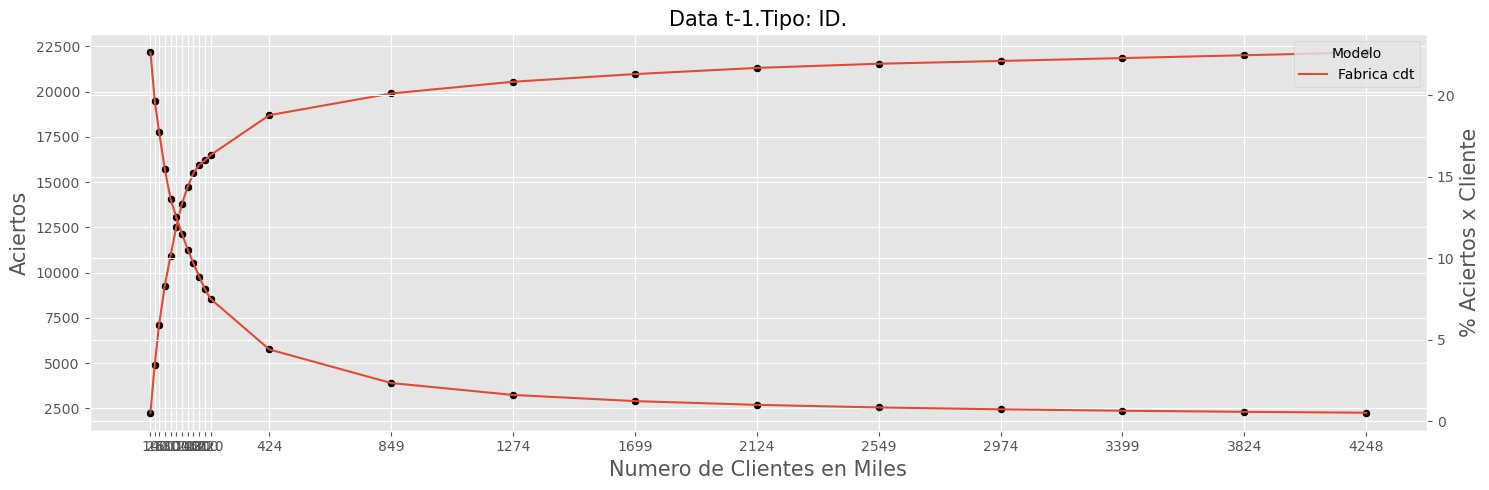

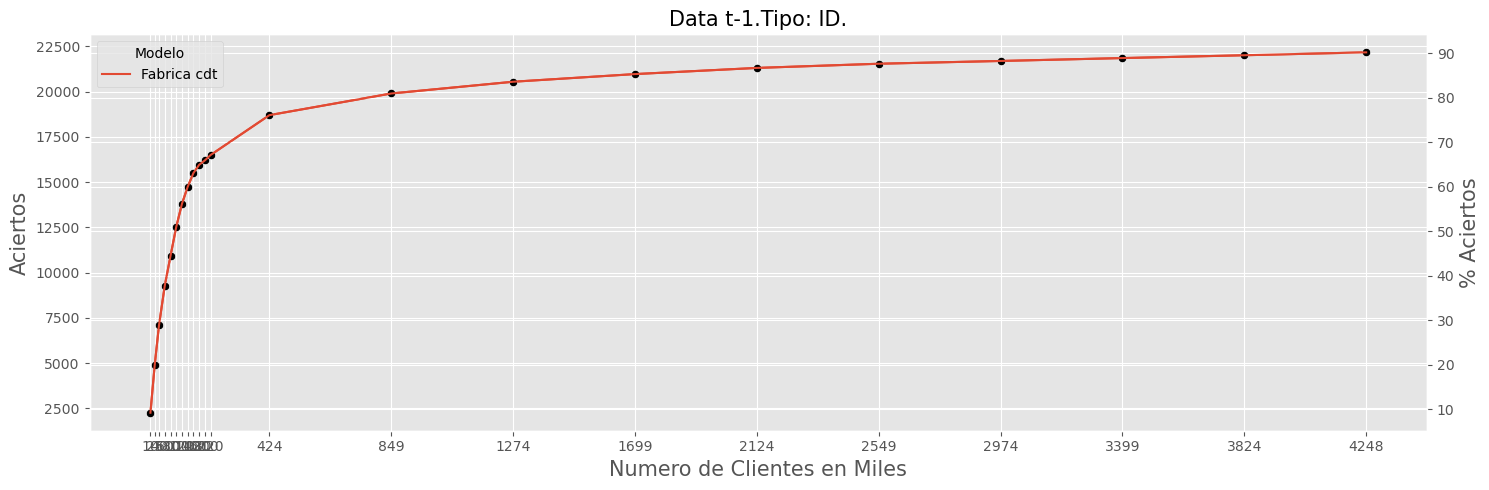

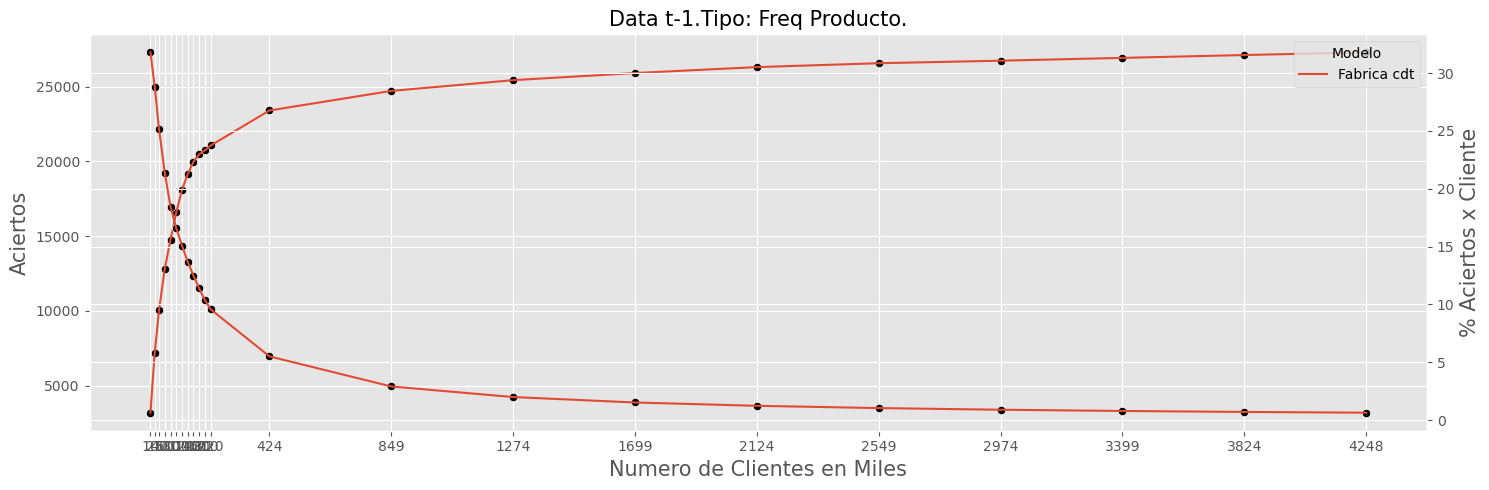

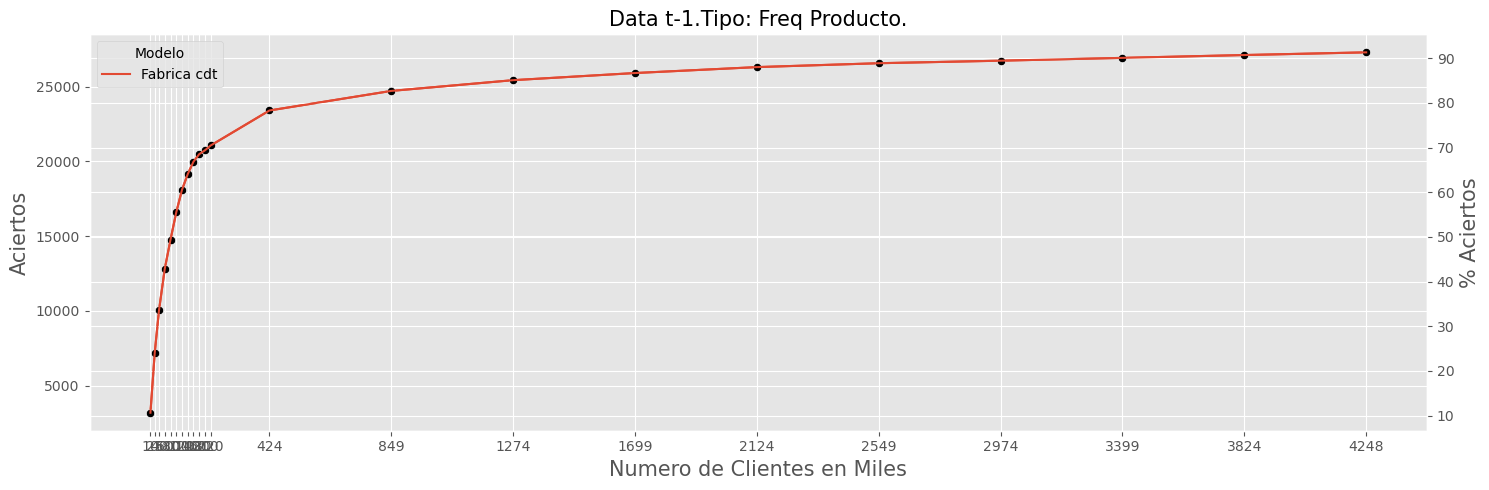

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


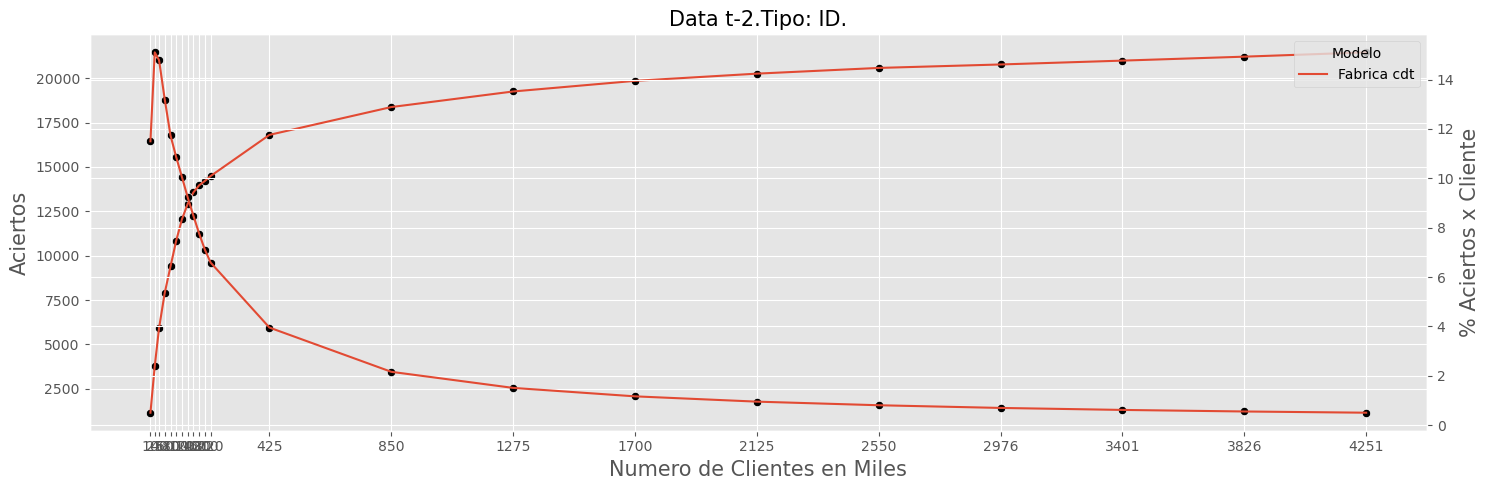

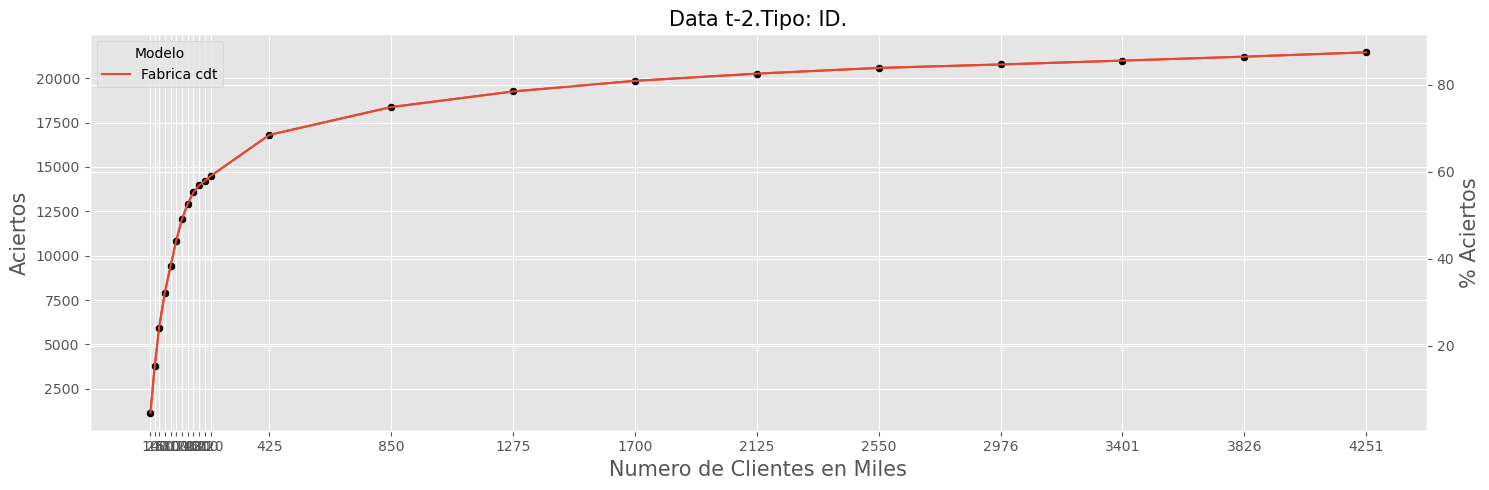

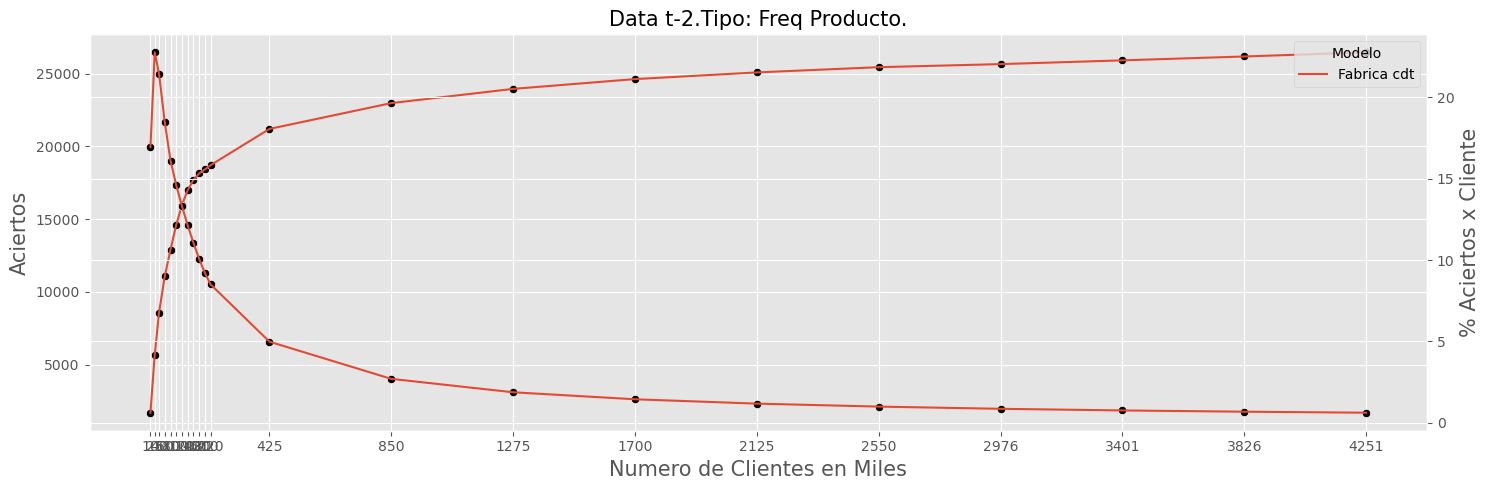

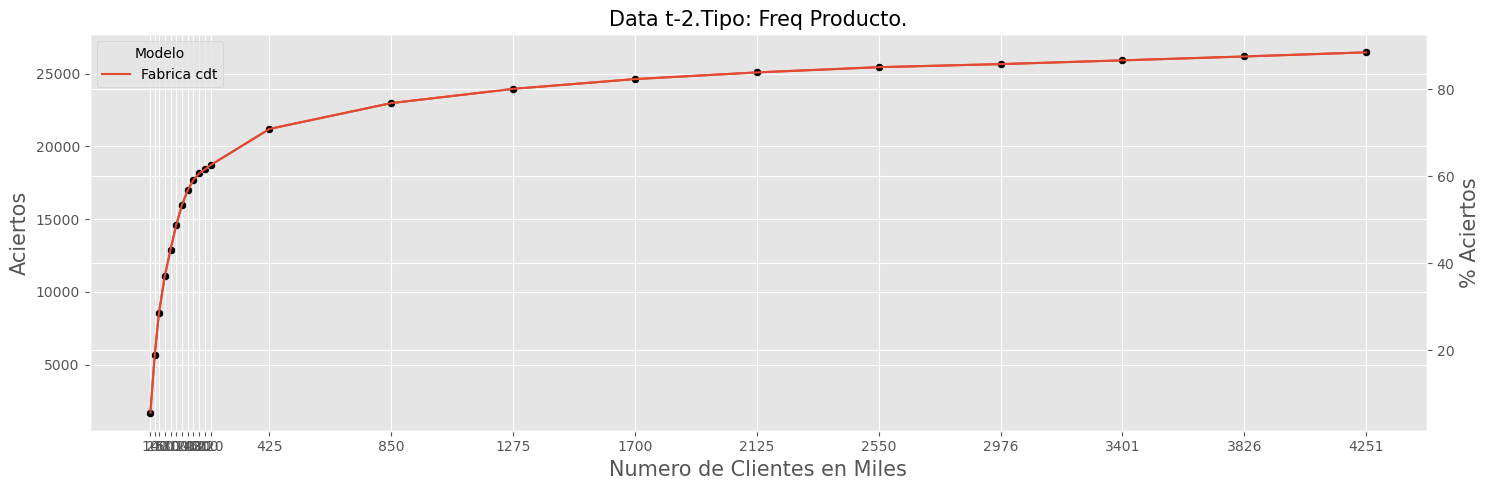

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


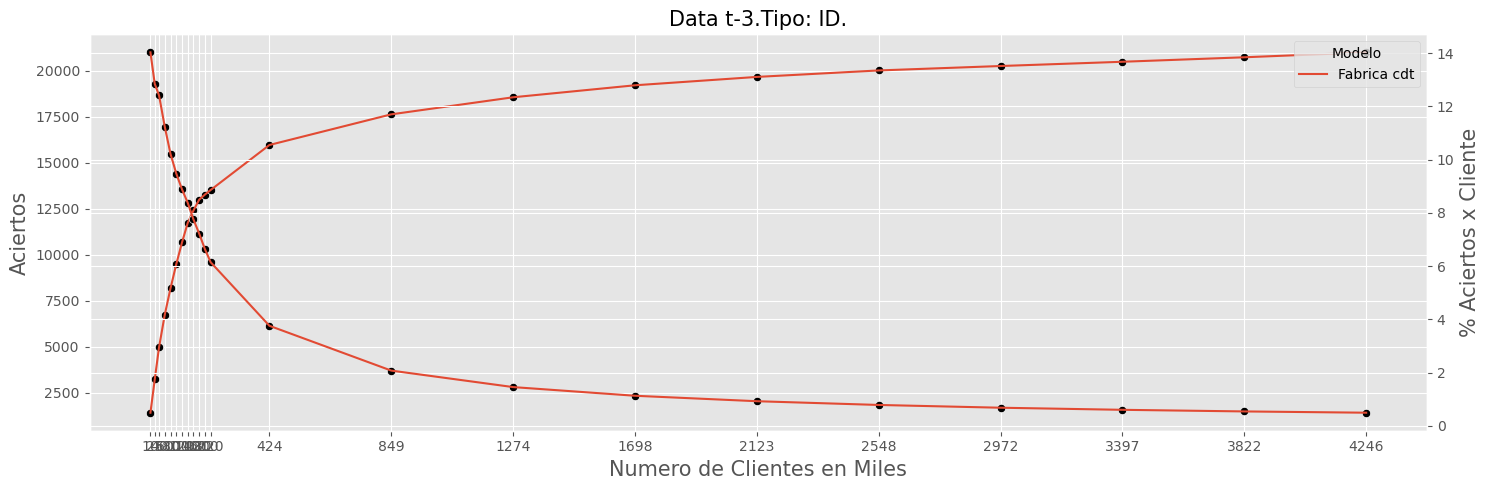

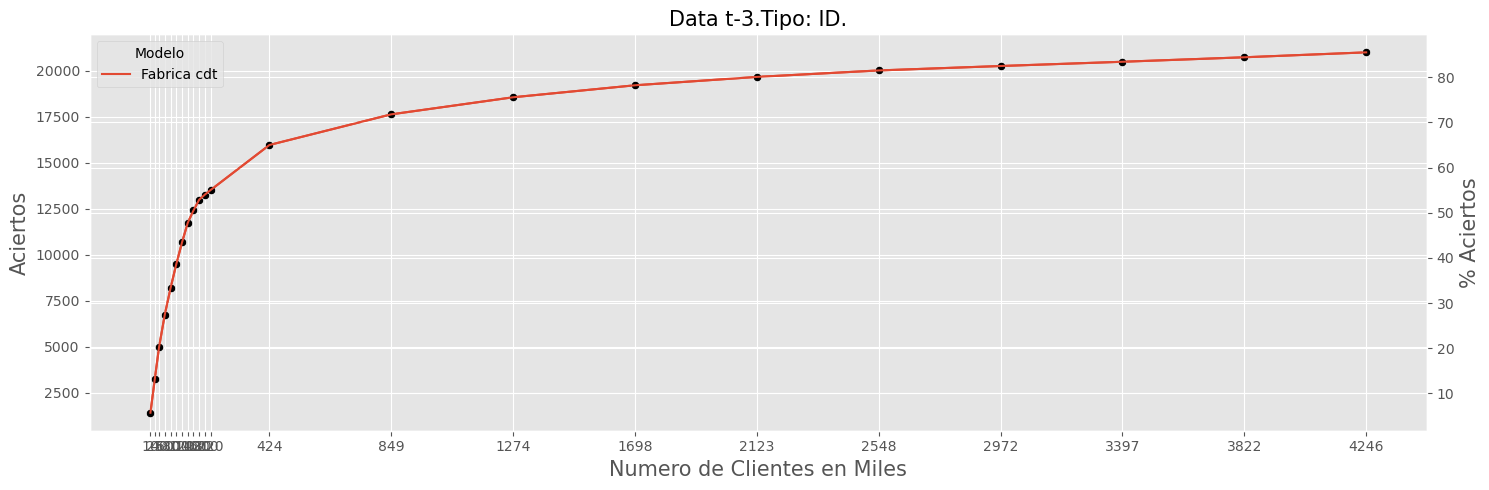

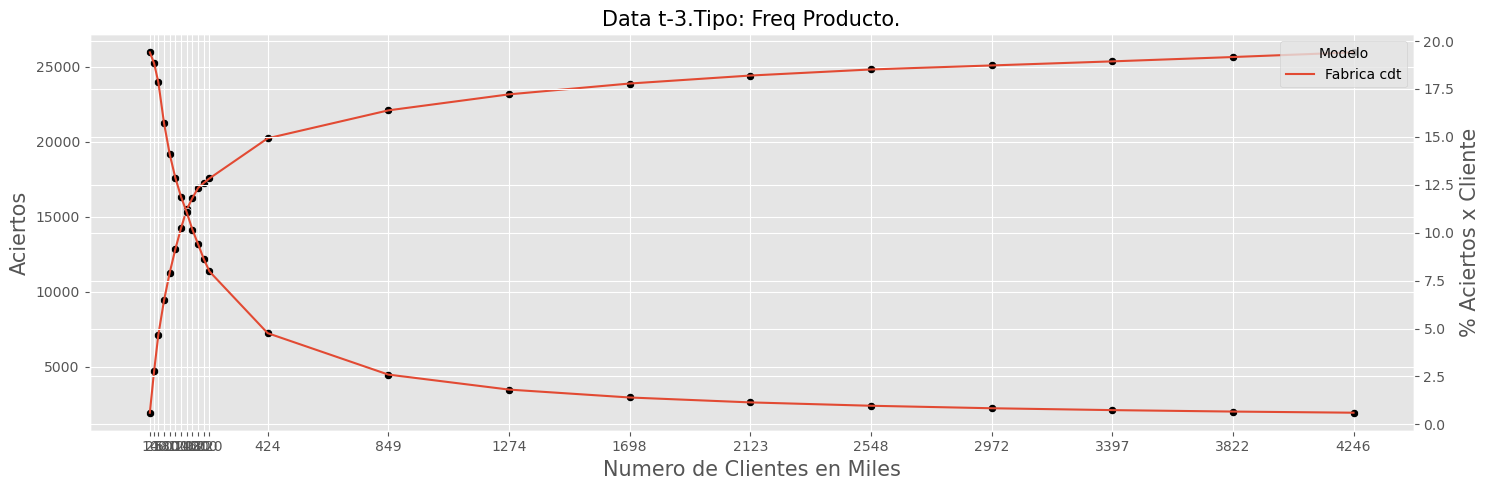

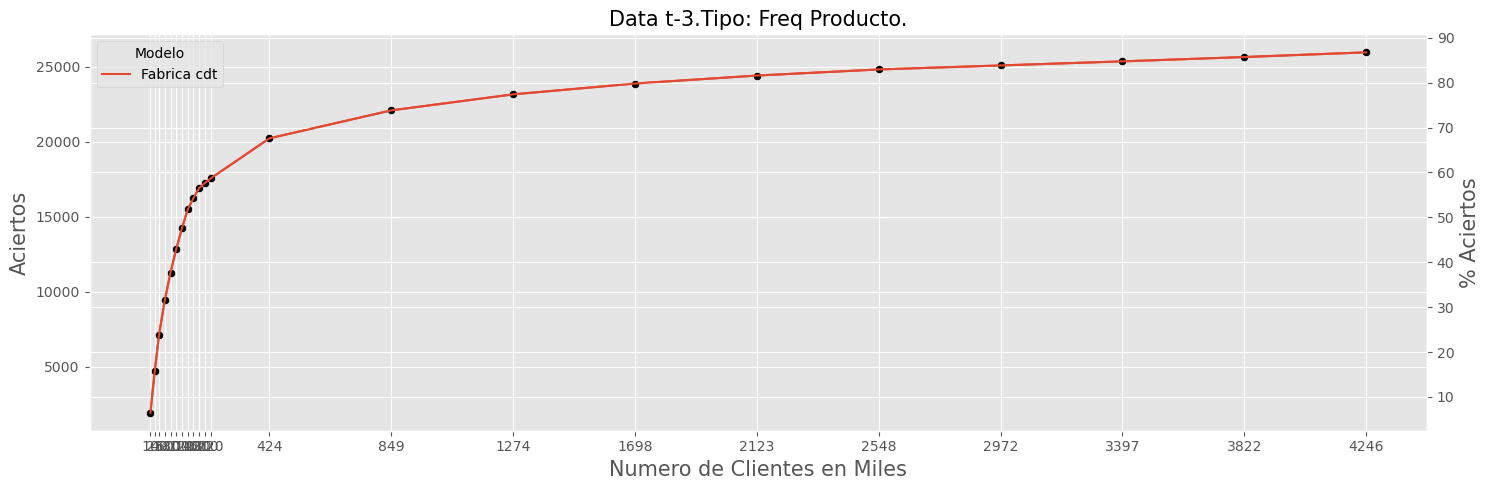

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


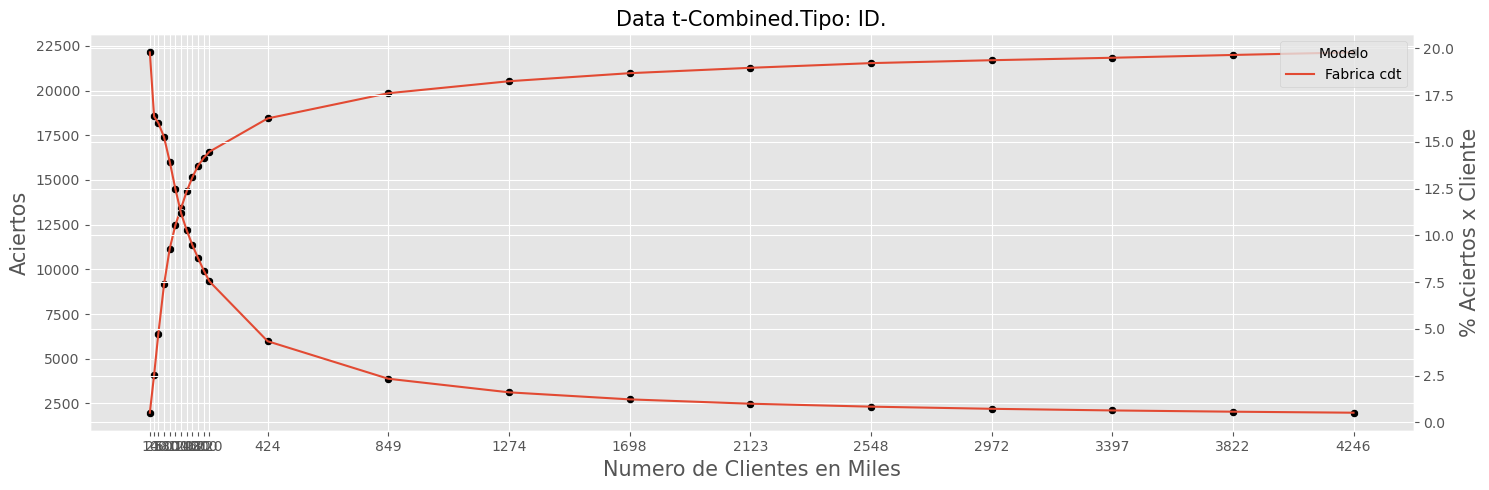

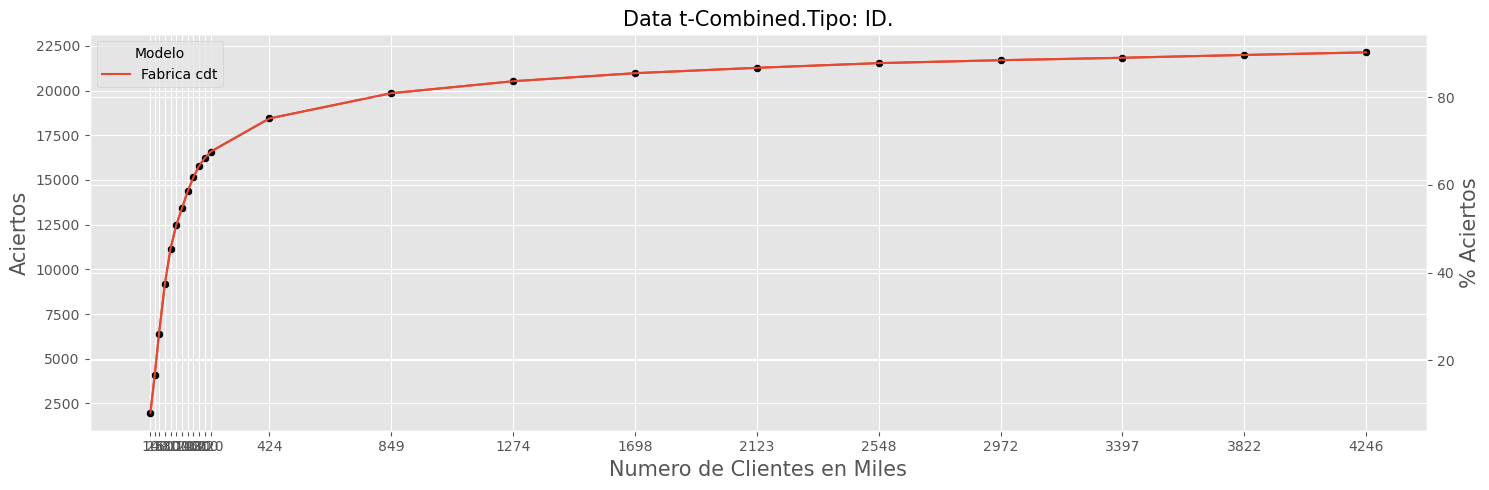

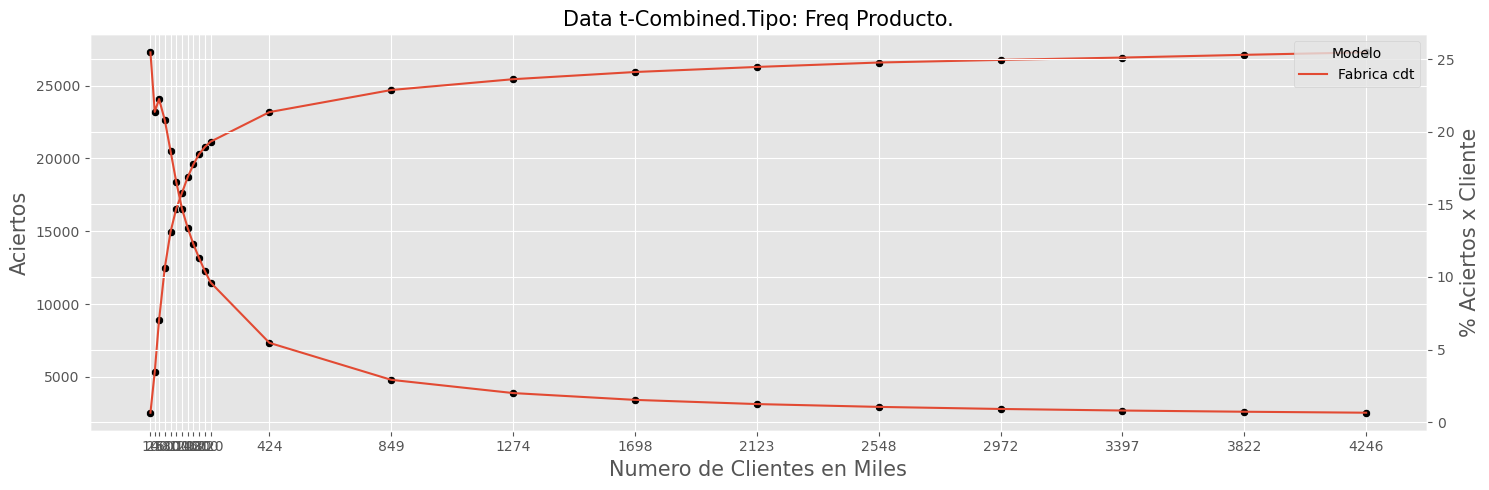

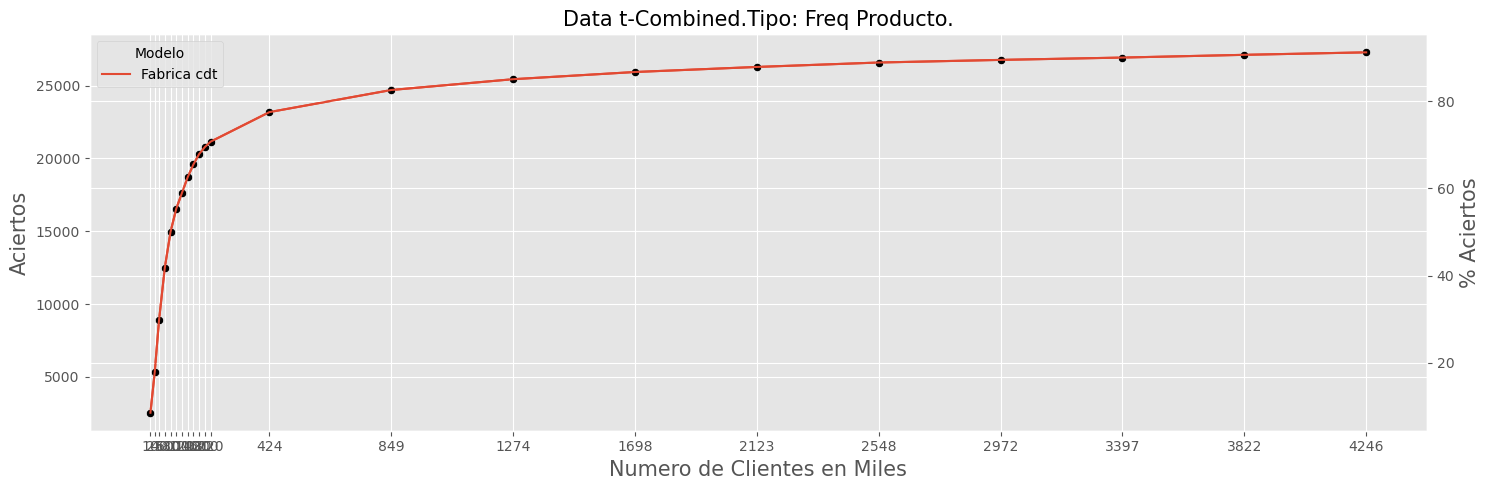

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


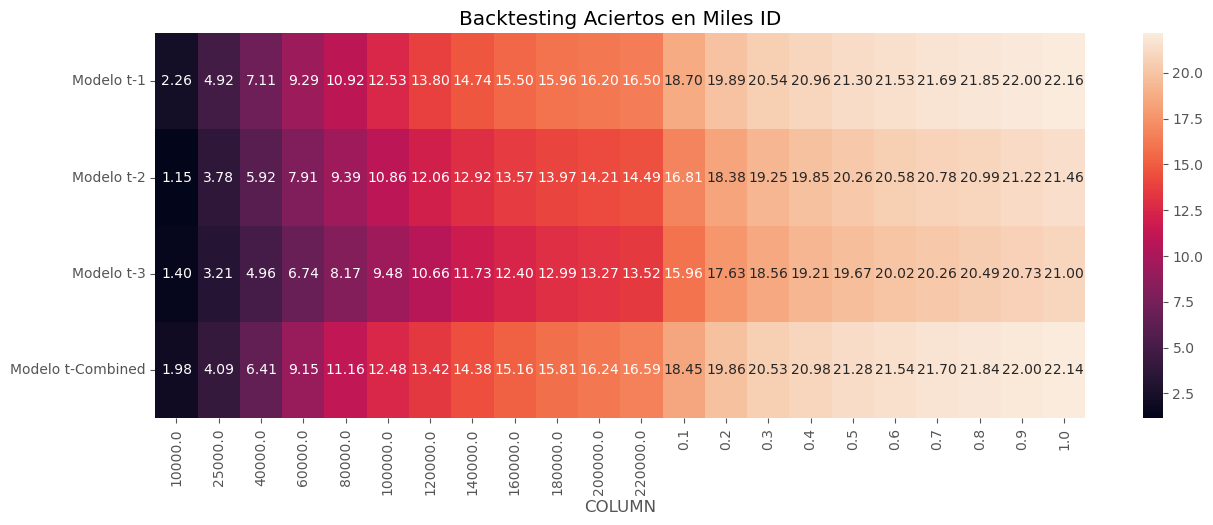

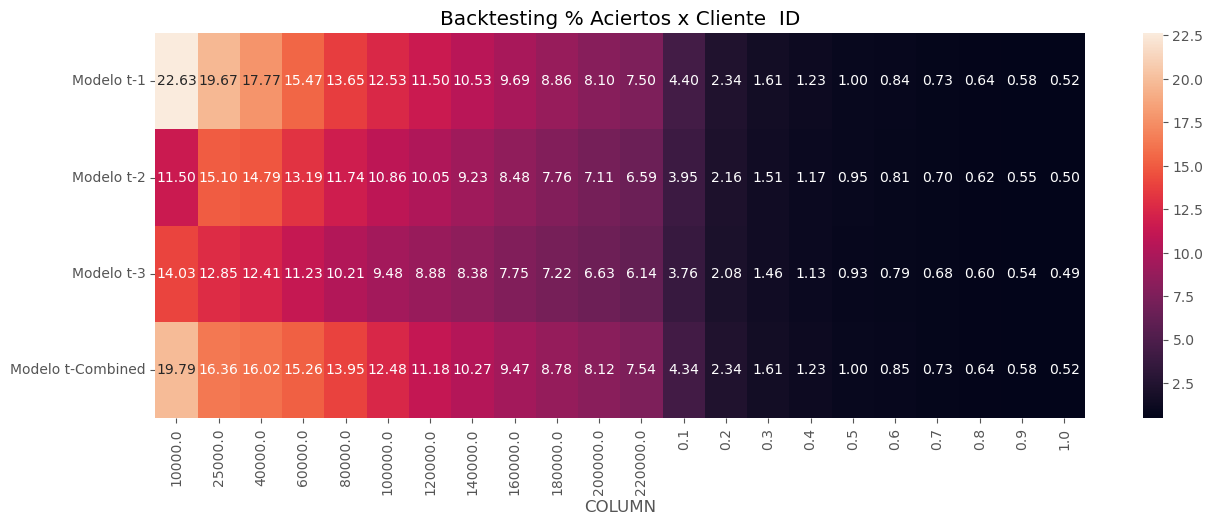

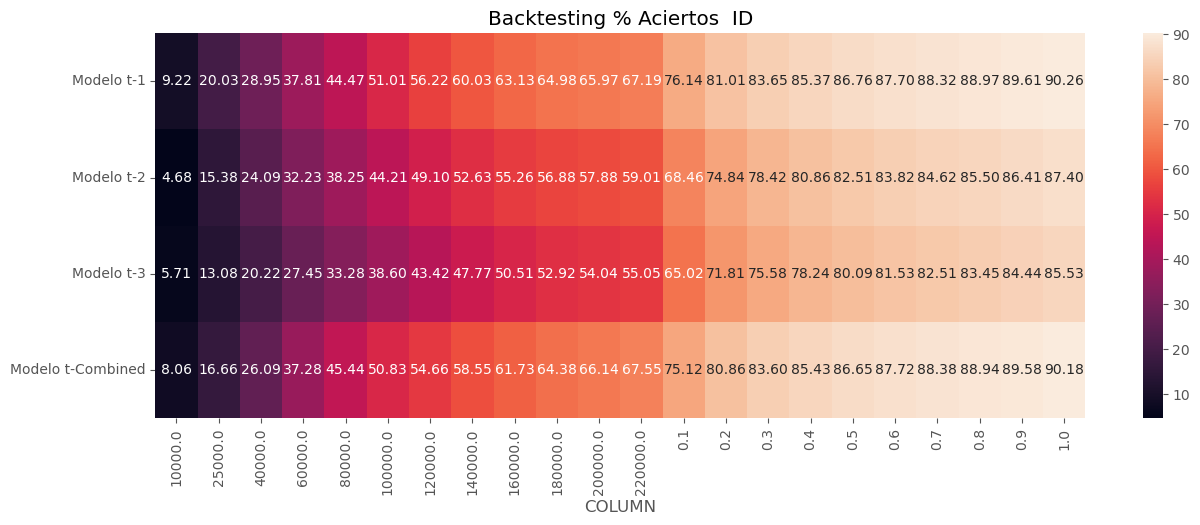

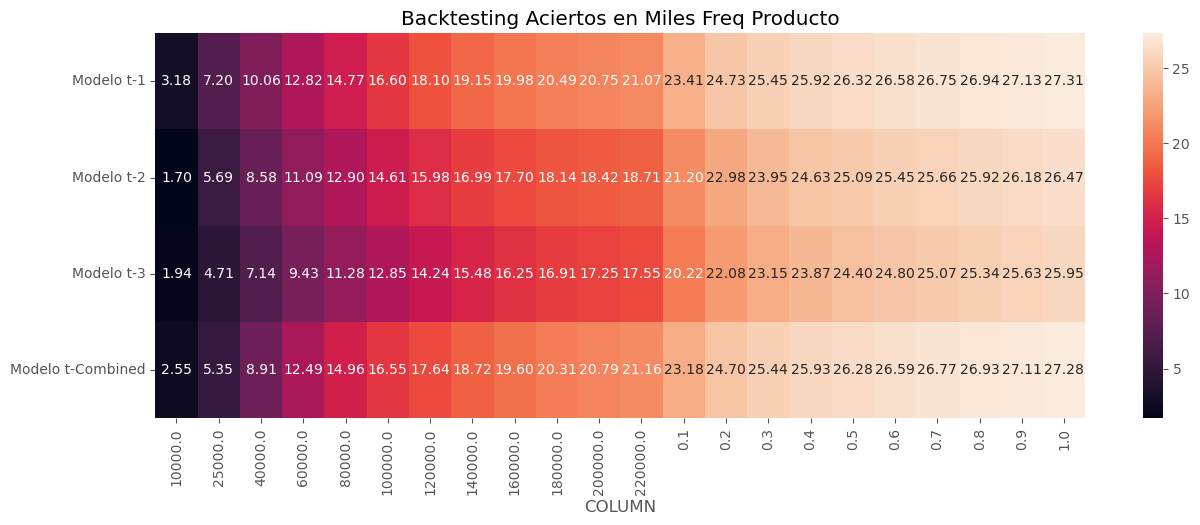

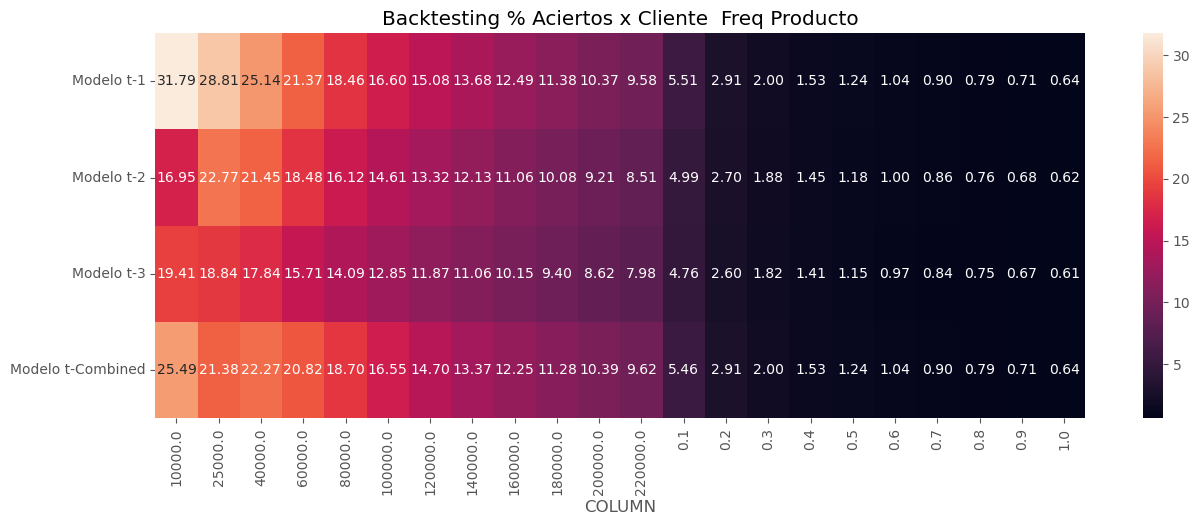

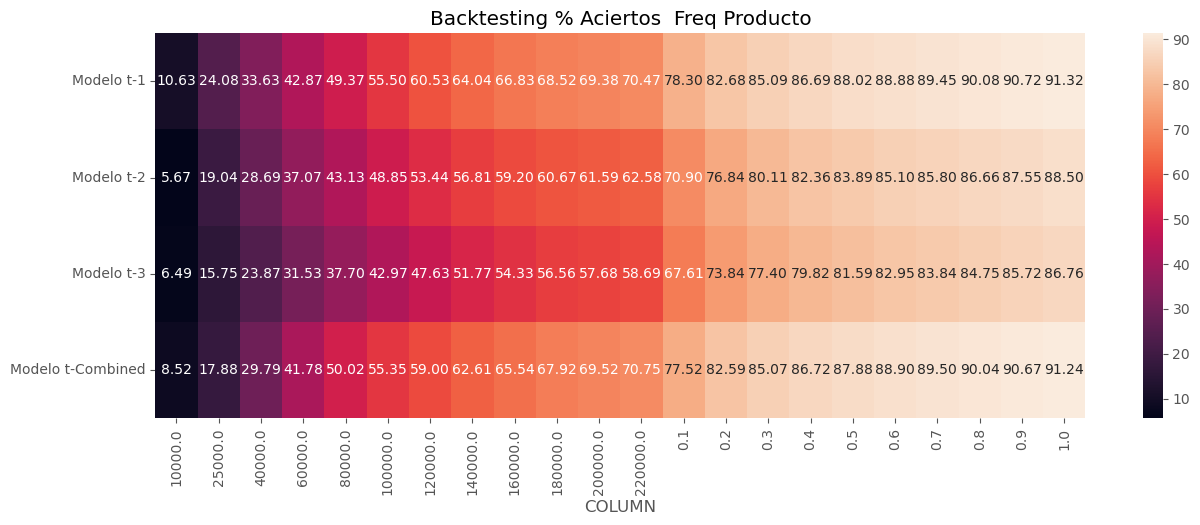

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Reduciendo memoria en el archivo...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Optimizacion realizada...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Generando los insumos del modelo 360...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando insumo modelo 360 t-1
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Finalizando insumo modelo 360 t-1
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando insumo modelo 360 t-2
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Finalizando insumo modelo 360 t-2
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando insumo modelo 360 t-3
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Finalizando insumo modelo 360 t-3
INFO:data_bbog_integration_fabrica_personas.pipeline

In [31]:
data_process1,insumo_model_360 = backtesting.combinar_predicciones_reales(data_process_copy,nombre_modelo, parametros)

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:CALCULOS: 1
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:N_top: 1274683


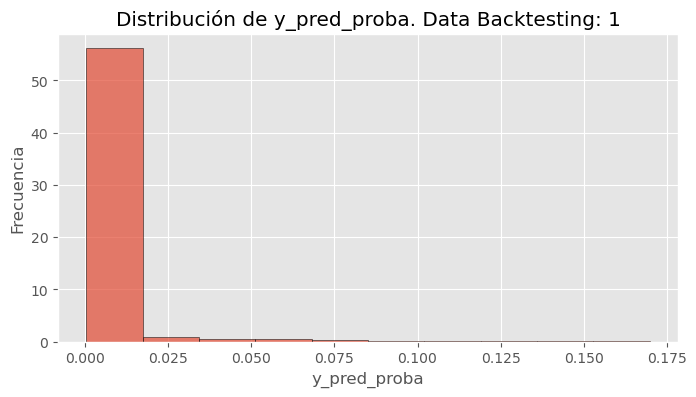

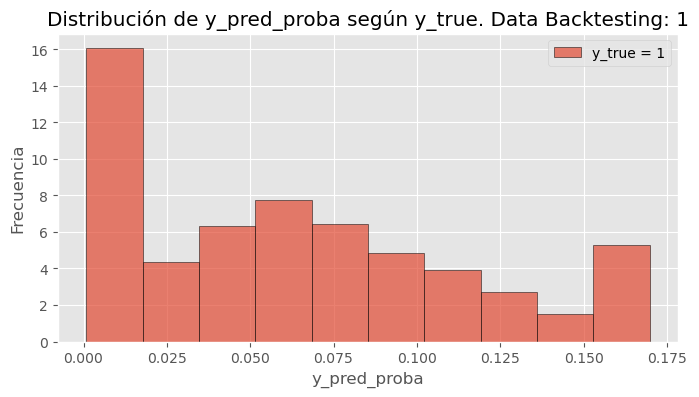

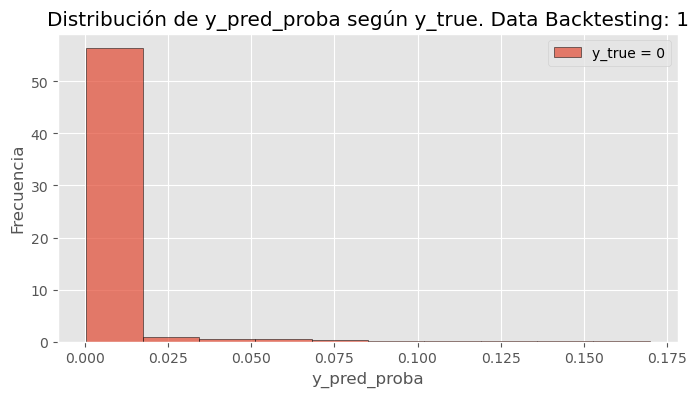

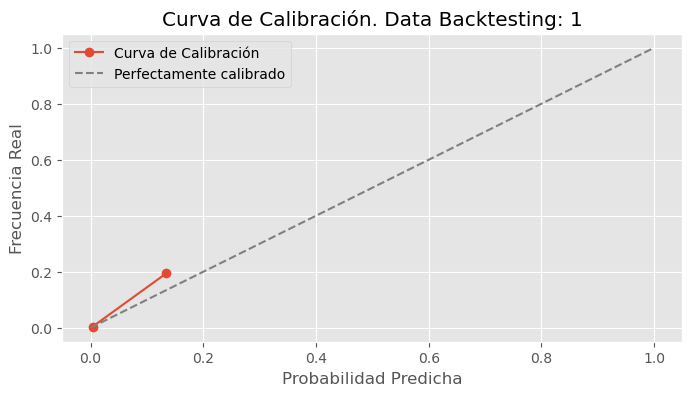

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Escenarios no medibles:                                                   {'No medible 1': 84171, 'No medible 1 %': 1.981, 'Pronosticos sin el hashvalue en la data real': 92205}
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Marca de tiempo actual: 2025-08-13 20:01
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas calculadas en %
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas N_top de Backtesting: 
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:  model_name model_type dataset_name            metric_name    value
0        CDT  Ensamble,       202504                N n_top  1274683
1        CDT  Ensamble,       202504                  N all  4248944
2        CDT  Ensamble,       202504  backtest_metric n_top   1.6113
3        CDT  Ensamble,       202504        Precision n_top   1.6113
5        CDT  Ensam

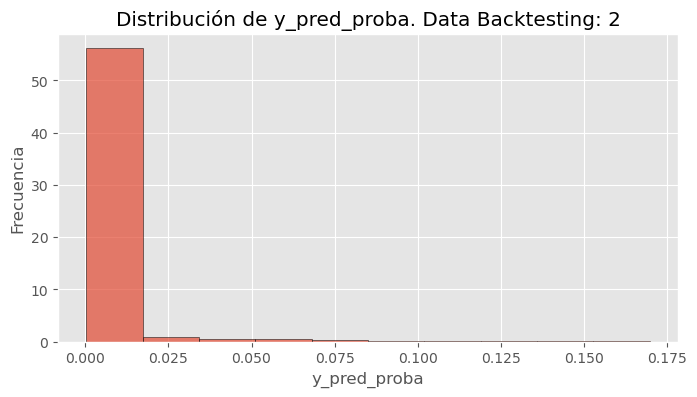

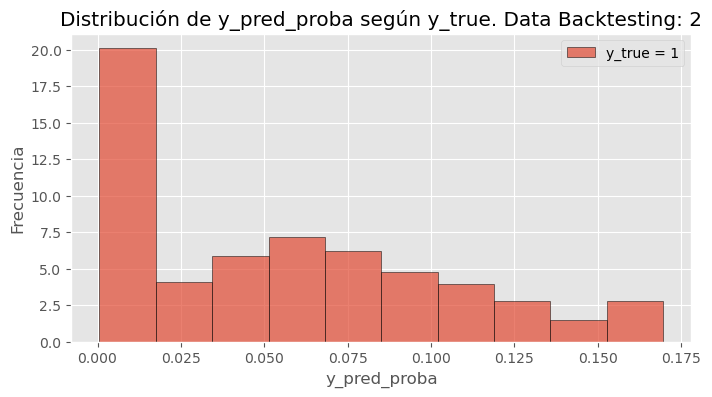

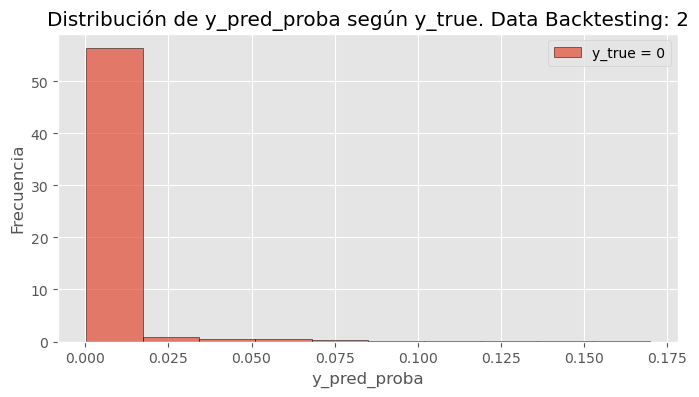

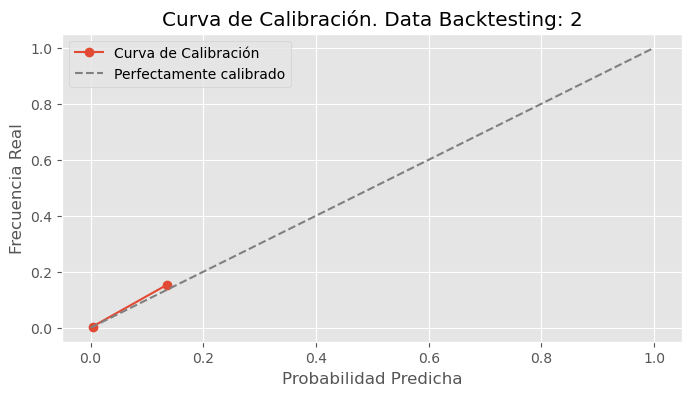

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Escenarios no medibles:                                                   {'No medible 1': 168441, 'No medible 1 %': 3.962, 'Pronosticos sin el hashvalue en la data real': 173961}
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Marca de tiempo actual: 2025-08-13 20:01
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas calculadas en %
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas N_top de Backtesting: 
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:  model_name model_type dataset_name            metric_name    value
0        CDT  Ensamble,       202503                N n_top  1275437
1        CDT  Ensamble,       202503                  N all  4251458
2        CDT  Ensamble,       202503  backtest_metric n_top   1.5105
3        CDT  Ensamble,       202503        Precision n_top   1.5105
5        CDT  Ens

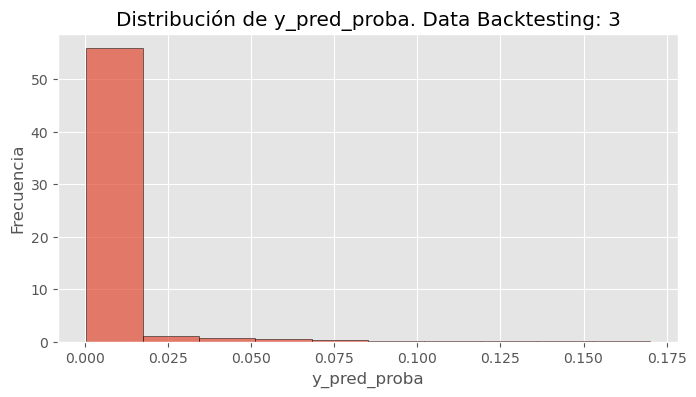

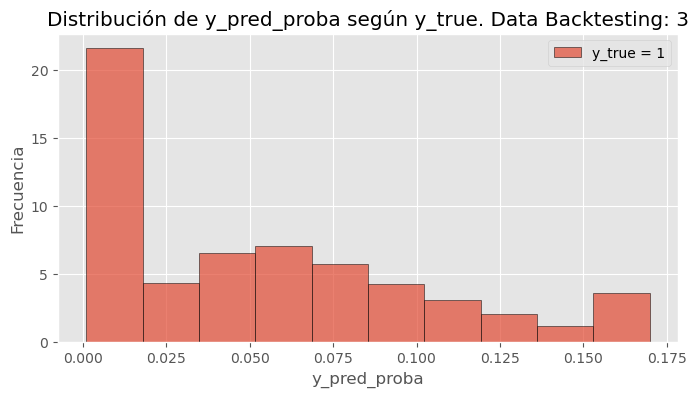

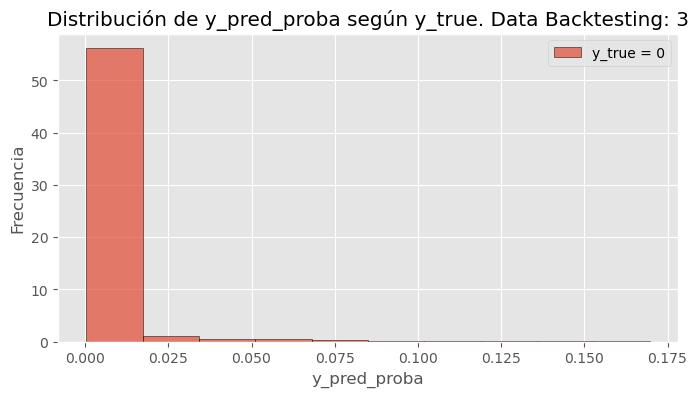

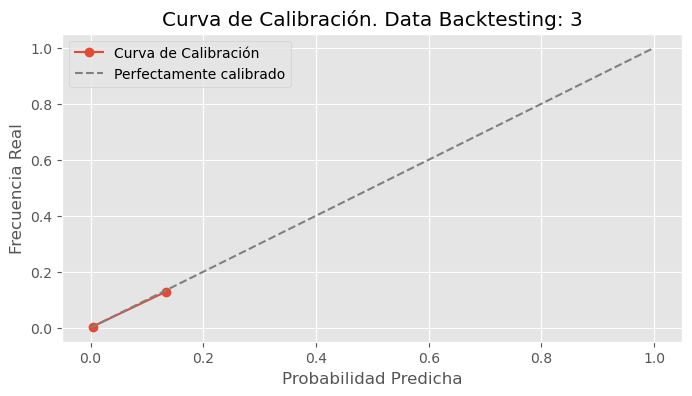

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Escenarios no medibles:                                                   {'No medible 1': 242221, 'No medible 1 %': 5.7034, 'Pronosticos sin el hashvalue en la data real': 252262}
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Marca de tiempo actual: 2025-08-13 20:02
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas calculadas en %
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas N_top de Backtesting: 
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:  model_name model_type dataset_name            metric_name    value
0        CDT  Ensamble,       202502                N n_top  1274081
1        CDT  Ensamble,       202502                  N all  4246937
2        CDT  Ensamble,       202502  backtest_metric n_top   1.4585
3        CDT  Ensamble,       202502        Precision n_top   1.4585
5        CDT  En

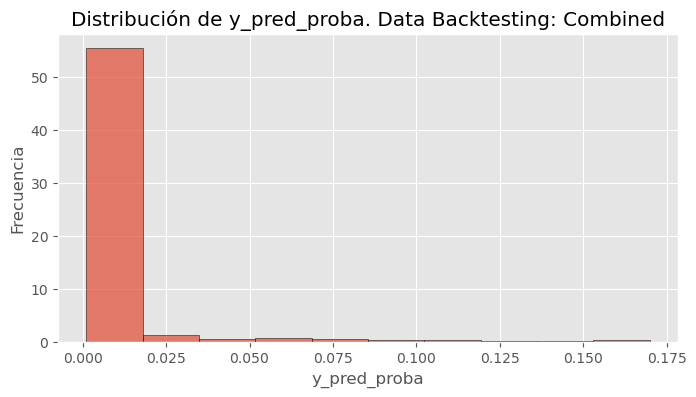

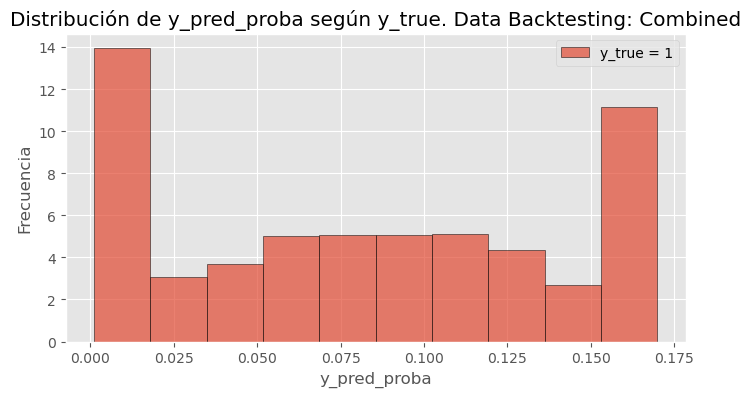

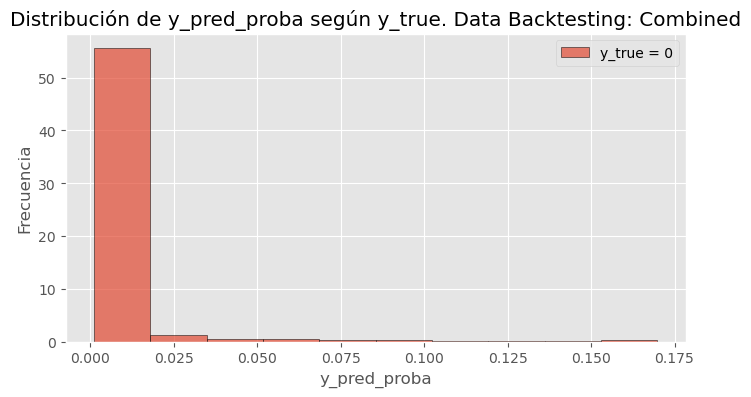

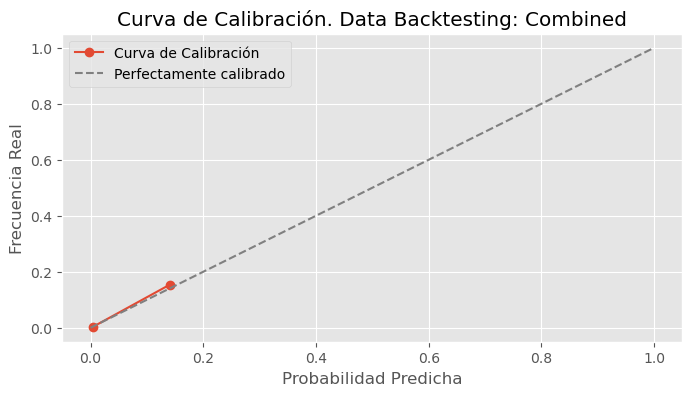

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Escenarios no medibles:                                                   {'No medible 1': 222323, 'No medible 1 %': 5.2349, 'Pronosticos sin el hashvalue en la data real': 232363}
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Marca de tiempo actual: 2025-08-13 20:02
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas calculadas en %
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Metricas N_top de Backtesting: 
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:  model_name model_type dataset_name            metric_name    value
0        CDT  Ensamble,     Combined                N n_top  1274081
1        CDT  Ensamble,     Combined                  N all  4246938
2        CDT  Ensamble,     Combined  backtest_metric n_top   1.6125
3        CDT  Ensamble,     Combined        Precision n_top   1.6125
5        CDT  En

decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      0.34     16.99          424895            18695            4.40   
1      9      0.20      0.34          424894             1196            0.28   
2      8      0.17      0.20          424894              648            0.15   
3      7      0.15      0.17          424895              423            0.10   
4      6      0.13      0.15          422461              334            0.08   
5      5      0.12      0.13          427327              237            0.06   
6      4      0.11      0.12          424894              153            0.04   
7      3      0.11      0.11          424895              160            0.04   
8      2      0.11      0.11          422902              156            0.04   
9      1      0.03      0.11          426887              160            0.04   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          84.36               10.00    74.36  
1          89.75               20.00    69.75  
2          92.68               30.00    62.68  
3          94.59               40.00    54.59  
4          96.09               49.94    46.15  
5          97.16               60.00    37.16  
6          97.85               70.00    27.85  
7          98.57               80.00    18.57  
8          99.28               89.95     9.32  
9         100.00              100.00     0.00

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:CALCULOS: 2
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando análisis KS por deciles de probabilidad...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando el estadístico KS para cada decil...
/home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py:1287: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (grouped.set_index("decil")["ks_stat"].diff() > 0)
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Deciles donde el ks aumenta

decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      0.33     16.98          425146            16809            3.95   
1      9      0.20      0.33          425146             1568            0.37   
2      8      0.17      0.20          425146              878            0.21   
3      7      0.15      0.17          425145              599            0.14   
4      6      0.13      0.15          425146              406            0.10   
5      5      0.12      0.13          425145              322            0.08   
6      4      0.11      0.12          425145              195            0.05   
7      3      0.11      0.11          425147              217            0.05   
8      2      0.11      0.11          420878              220            0.05   
9      1      0.03      0.11          429414              246            0.06   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.33                10.0    68.33  
1          85.63                20.0    65.63  
2          89.73                30.0    59.73  
3          92.52                40.0    52.52  
4          94.41                50.0    44.41  
5          95.91                60.0    35.91  
6          96.82                70.0    26.82  
7          97.83                80.0    17.83  
8          98.85                89.9     8.95  
9         100.00               100.0     0.00

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:CALCULOS: 3
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando análisis KS por deciles de probabilidad...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando el estadístico KS para cada decil...
/home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py:1287: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (grouped.set_index("decil")["ks_stat"].diff() > 0)
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Deciles donde el ks aumenta

decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      0.35     16.99          424694            15964            3.76   
1      9      0.21      0.35          424694             1667            0.39   
2      8      0.18      0.21          424693              928            0.22   
3      7      0.15      0.18          424694              652            0.15   
4      6      0.13      0.15          424684              455            0.11   
5      5      0.12      0.13          424703              352            0.08   
6      4      0.11      0.12          424694              241            0.06   
7      3      0.11      0.11          424693              231            0.05   
8      2      0.11      0.11          424694              244            0.06   
9      1      0.03      0.11          424694              268            0.06   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          76.01                10.0    66.01  
1          83.95                20.0    63.95  
2          88.37                30.0    58.37  
3          91.47                40.0    51.47  
4          93.64                50.0    43.64  
5          95.31                60.0    35.31  
6          96.46                70.0    26.46  
7          97.56                80.0    17.56  
8          98.72                90.0     8.72  
9         100.00               100.0     0.00

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:CALCULOS: Combined
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Iniciando análisis KS por deciles de probabilidad...
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Calculando el estadístico KS para cada decil...
/home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py:1287: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (grouped.set_index("decil")["ks_stat"].diff() > 0)
INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:Deciles donde el ks 

decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      0.53     16.99          424694            18445            4.34   
1      9      0.24      0.53          424694             1410            0.33   
2      8      0.20      0.24          424694              671            0.16   
3      7      0.17      0.20          424693              450            0.11   
4      6      0.14      0.17          424694              301            0.07   
5      5      0.12      0.14          423907              262            0.06   
6      4      0.12      0.12          423217              163            0.04   
7      3      0.11      0.12          426957              137            0.03   
8      2      0.11      0.11          420724              157            0.04   
9      1      0.11      0.11          428664              146            0.03   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          83.30               10.00    73.30  
1          89.67               20.00    69.67  
2          92.70               30.00    62.70  
3          94.73               40.00    54.73  
4          96.09               50.00    46.09  
5          97.28               59.98    37.30  
6          98.01               69.95    28.07  
7          98.63               80.00    18.63  
8          99.34               89.91     9.43  
9         100.00              100.00     0.00

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


In [32]:
data_metrics_backtesting = backtesting.generate_metrics_all(data_process1,parametros)
data_backtesting = backtesting.generate_ks_all(data_metrics_backtesting,parametros)

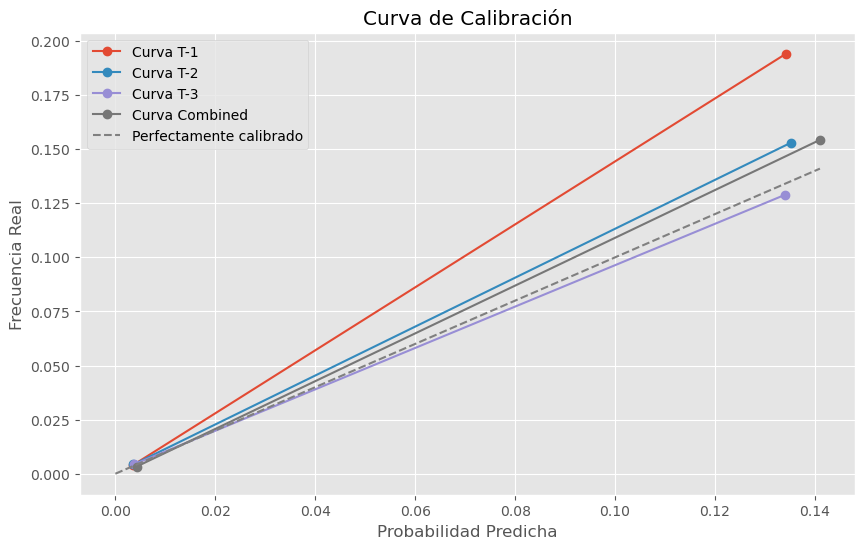

In [33]:
plt.figure(figsize=(10, 6))
max_value = 0
for i in data_process1.keys():
    prob_true = data_process1[i]['prob_true']
    prob_pred = data_process1[i]['prob_pred']
    # Graficar la curva de calibración
    try:
        msg = " T-"+str(int(i))
    except:
        msg = " "+str(i)
    plt.plot(prob_pred, prob_true, marker='o', label='Curva'+msg)
    max_value = np.max([max_value,np.max(prob_pred)])
plt.plot([0, max_value], [0, max_value], linestyle='--', color='gray', label='Perfectamente calibrado')
plt.title('Curva de Calibración')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia Real')
plt.legend()
plt.show()
# curva > 45 grados = subestimar
# curva < 45 grados = sobrestimar

#### Comparativo del desarrollo para MLOps contra la ejecucion a modo de re-entrenamiento (pilotos) 

- Calificacion de Campañas vs prediccion de backtesting
- Ambas predicciones se validan contra la feature de retail

**Analisis sobre el insumo modelo 360**

In [34]:
if prod == 'CDT':
    ruta_backtest = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/save_backtesting_new_mvp7_4_{corte}_v_retail.pickle"
    ruta_insumo = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/insumo_modelo_360_new_mvp7_4_{corte}_v_retail.pickle"
    ruta_backtest = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/save_backtesting_new_mvp7_4_{corte}_v_retail_prueba.pickle"
    ruta_insumo = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/insumo_modelo_360_new_mvp7_4_{corte}_v_retail_prueba.pickle"
elif prod == 'TC':
    ruta_backtest = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/save_backtesting_new_t3_v3_1_{corte}.pickle"
    ruta_insumo = f"s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/{prod}/09-backtesting/insumo_modelo_360_new_t3_v3_1_{corte}.pickle"

backtesting_pilotaje = pd.read_pickle(ruta_backtest)
backtesting_pilotaje_360 = pd.read_pickle(ruta_insumo)

In [35]:
print(insumo_model_360.keys())
print(backtesting_pilotaje_360.keys())

dict_keys([1, 2, 3, 'Combined'])
dict_keys([1, 2, 3, 'Combined'])


In [36]:
print('Monitoreo - Re-Entrenamiento')
for t in list(insumo_model_360.keys()):
    bd_temp1 = insumo_model_360[t]['Discriminacion'].set_index('COLUMN')
    bd_temp1['Decil Pend'] = bd_temp1['Decil Pend'].astype(int)
    bd_temp2 = backtesting_pilotaje_360[t]['Discriminacion'].set_index('COLUMN')
    bd_temp2['Decil Pend'] = bd_temp2['Decil Pend'].astype(int)
    validate = (bd_temp2-bd_temp1).round(0).replace(0,np.nan).T.dropna(how='all').T
    
    if 'N' in validate.columns:
        validate['N'] = validate['N']*bd_temp1['xN']
    print(t)
    if validate.shape[1] > 0:
        validate2 =validate.describe().loc[['count','mean','min','max']]
        validate2.loc['% count'] = 100*(validate2.loc['count'] / validate.shape[0])
        display(validate2.T)
        try:
            print('\t Diferencias en % Aciertos superiores al promedio')
            display(validate[validate['% Aciertos'] > validate2.loc['mean','% Aciertos']][['% Aciertos']].T)
        except:
            pass
        try:
            validate3 = validate[['Decil Pend', 'Decil Suavizado', 'Decil Categoria']].dropna(how='all')
            if validate3.shape[0]>0:
                display(validate3)
                print('\t Monitoreo')
                display(bd_temp2.loc[validate3.index,['Decil Pend', 'Decil Suavizado', 'Decil Categoria']])
                print('\t Re-Entrenamiento')
                display(bd_temp1.loc[validate3.index,['Decil Pend', 'Decil Suavizado', 'Decil Categoria']])
        except:
            pass
    else:
        print(f'\t No hubo diferencias...')
    print('---------------------------------------------------------------------------------------')

Monitoreo - Re-Entrenamiento
1
	 No hubo diferencias...
---------------------------------------------------------------------------------------
2
	 No hubo diferencias...
---------------------------------------------------------------------------------------
3
	 No hubo diferencias...
---------------------------------------------------------------------------------------
Combined
	 No hubo diferencias...
---------------------------------------------------------------------------------------


#### Comparativo del backtesting

In [37]:
t=2
modelos = [backtesting_pilotaje,data_backtesting]
nombres = ['Pilotos-Re/Entrenamiento','Monitoreo']

In [38]:
dic = {}
for pos,save_backtesting in enumerate(modelos):
    base_calificada_fabrica = save_backtesting[t]['prediccion']
    full_base = base_calificada_fabrica.shape[0]
    base_calificada_fabrica2 = base_calificada_fabrica.copy()
#    base_calificada_fabrica2['hashvalue1'] = base_calificada_fabrica2['hashvalue1'].str[1:]
    display(base_calificada_fabrica2.head(2))
    dic[nombres[pos]] = {'prediccion': base_calificada_fabrica2}
    dic[nombres[pos]]['contactabilidad'] = save_backtesting[t]['contactabilidad_curva']#backtesting.create_curve_backtesting(base_calificada_fabrica2,full_base,params)
    dic[nombres[pos]]['contactabilidad_curva'] = save_backtesting[t]['contactabilidad_curva']

hashvalue1  y_real  y_pred  y_pred_proba  decil_apertura model_name
0  CC1010030709     0.0       1      0.169768              10   Ensamble
1    CC40094270     0.0       1      0.169645              10   Ensamble

hashvalue1  y_real  y_pred  y_pred_proba  decil_apertura model_name
0  CC1010030709     0.0       1      0.169768              10  Ensamble,
1    CC40094270     0.0       1      0.169645              10  Ensamble,

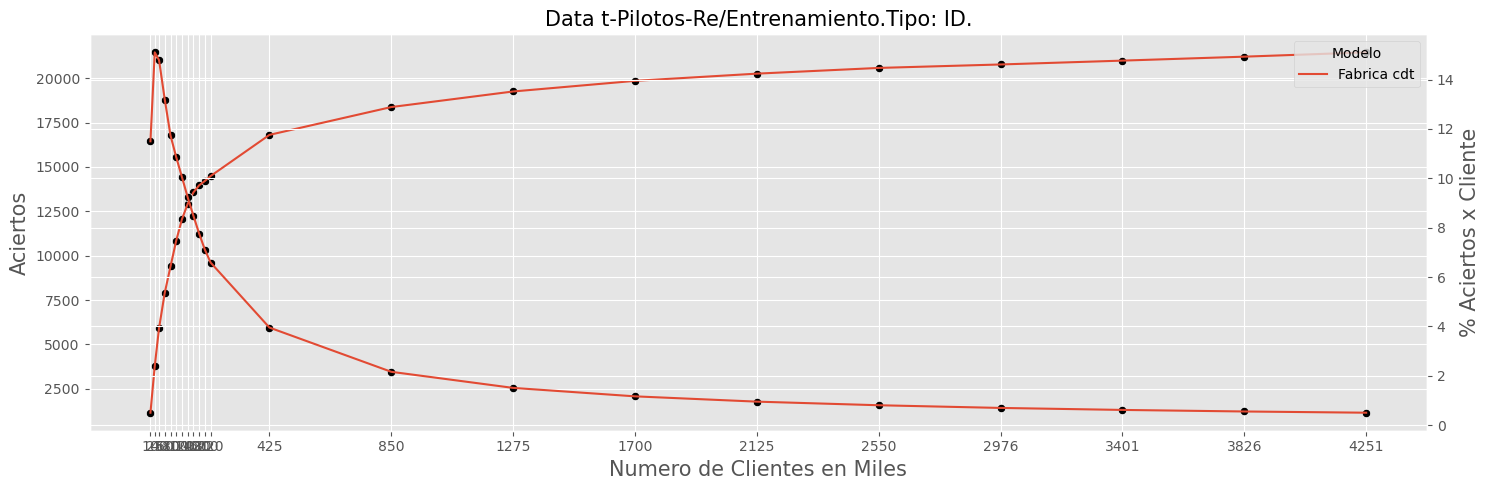

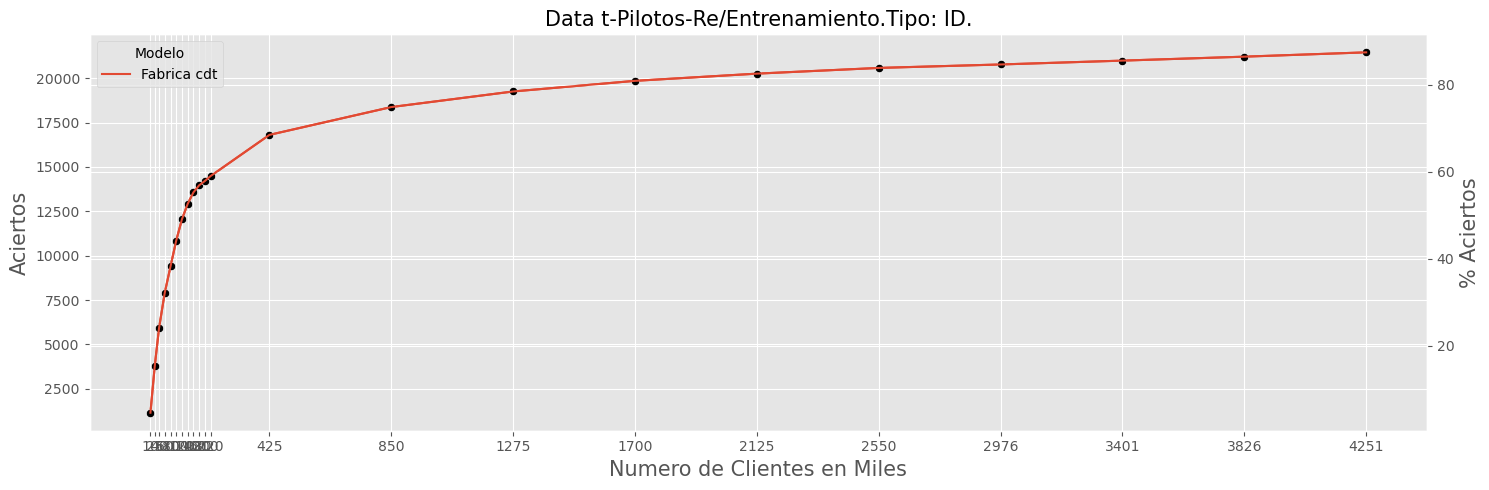

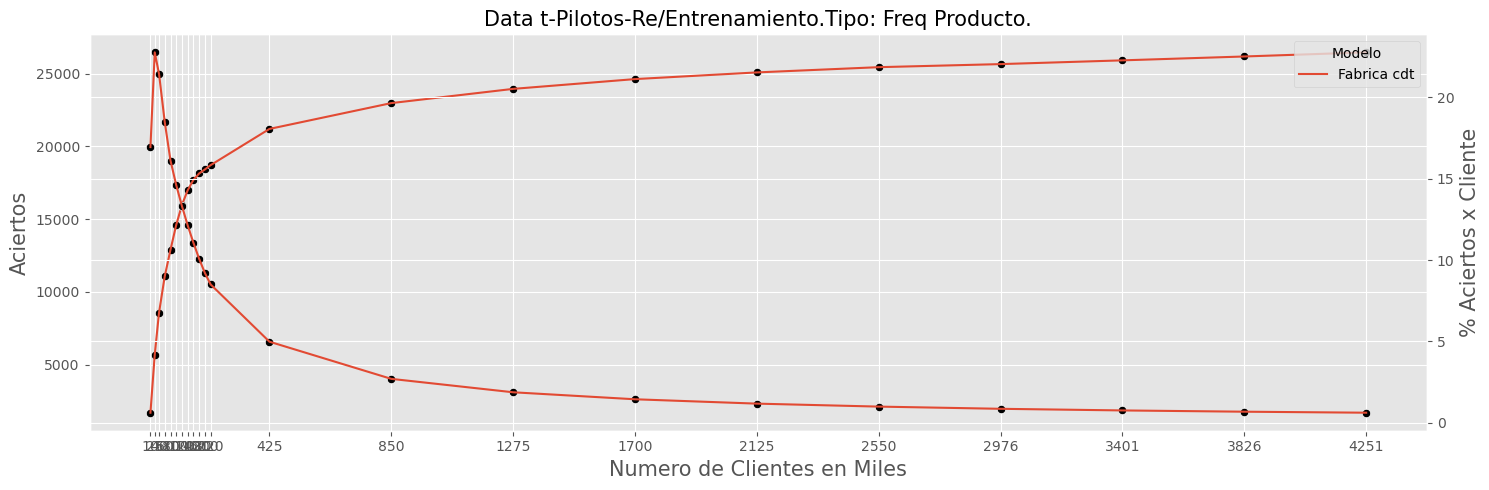

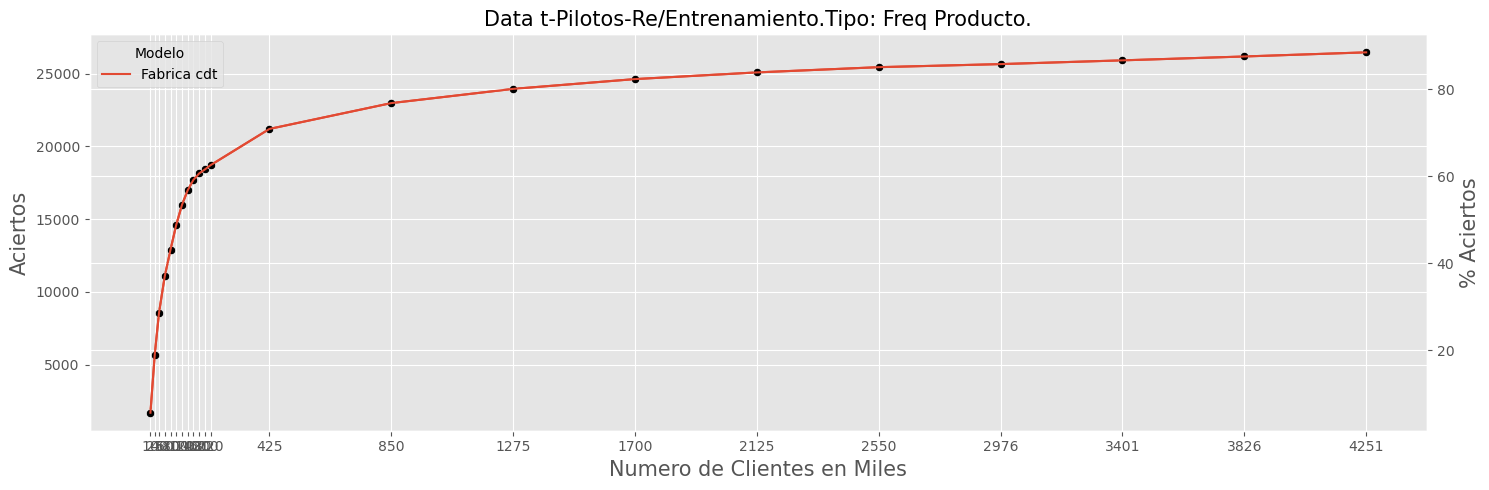

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


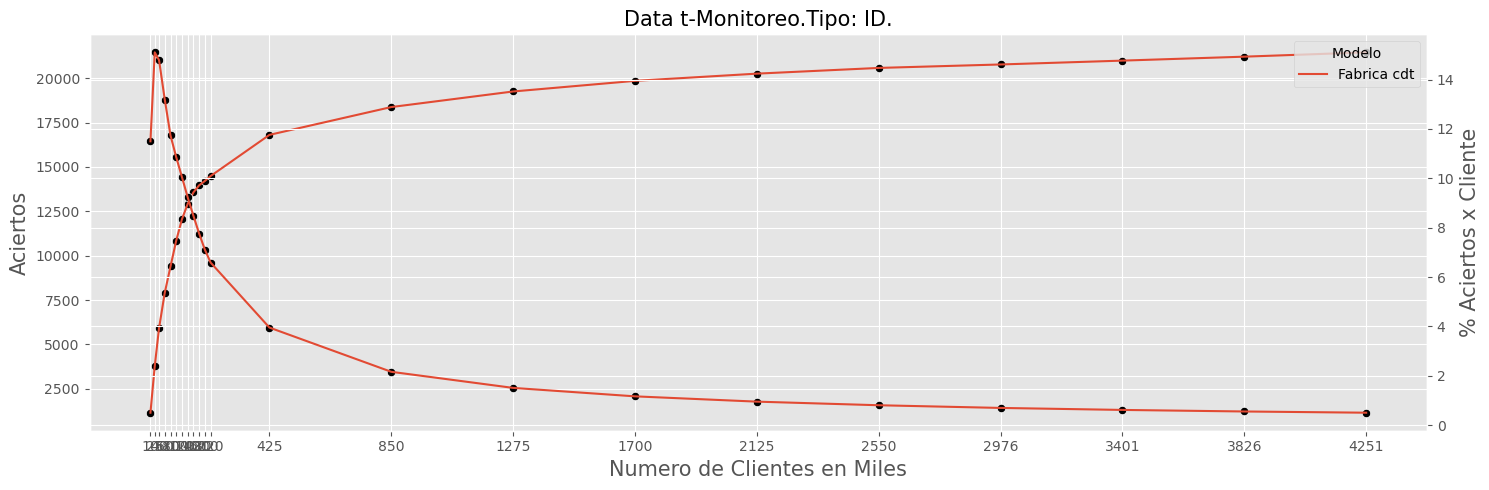

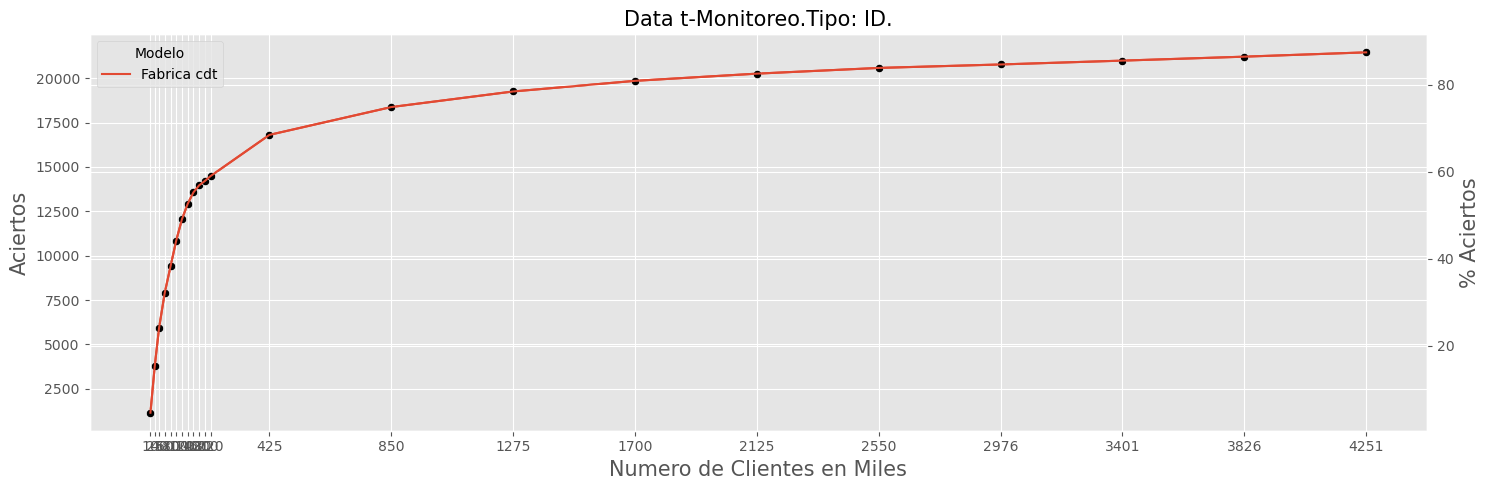

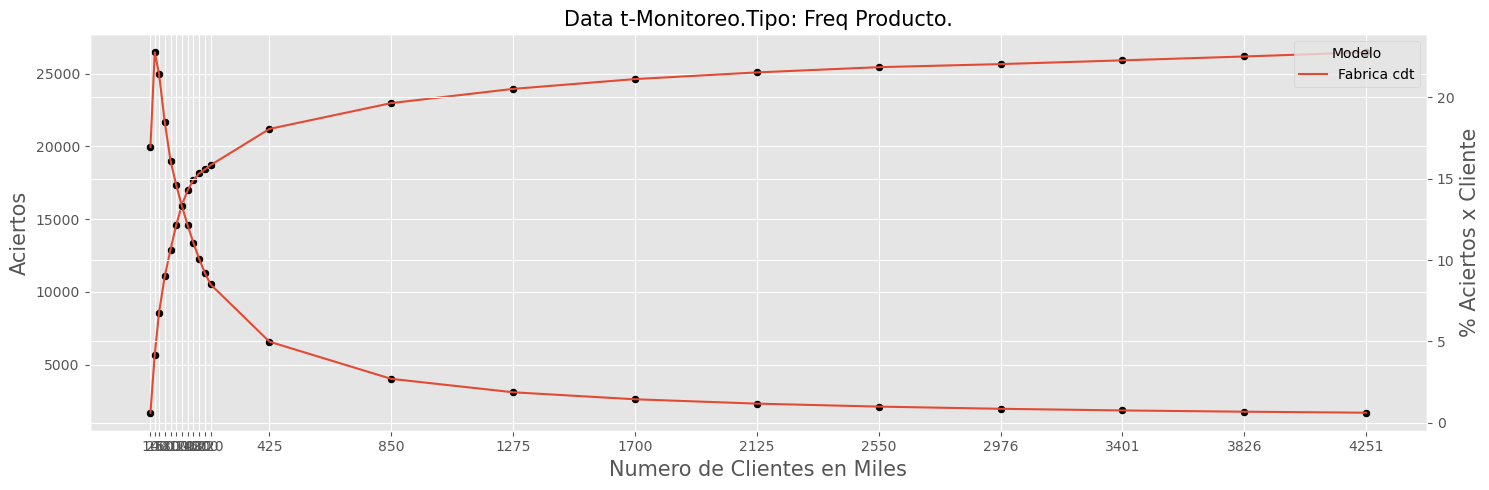

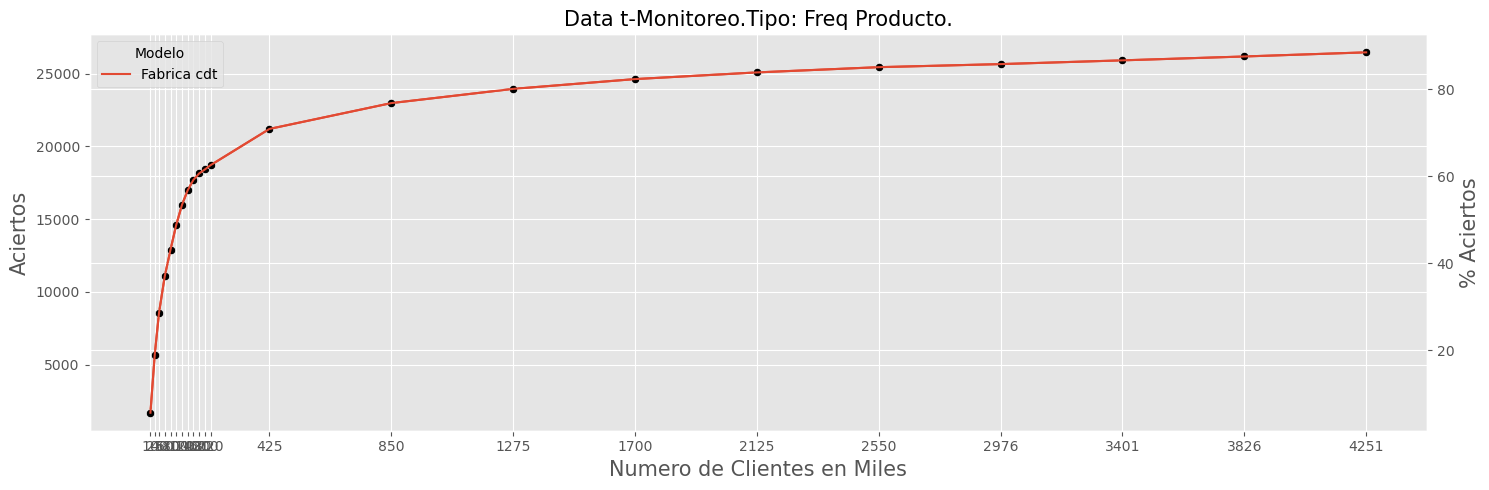

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


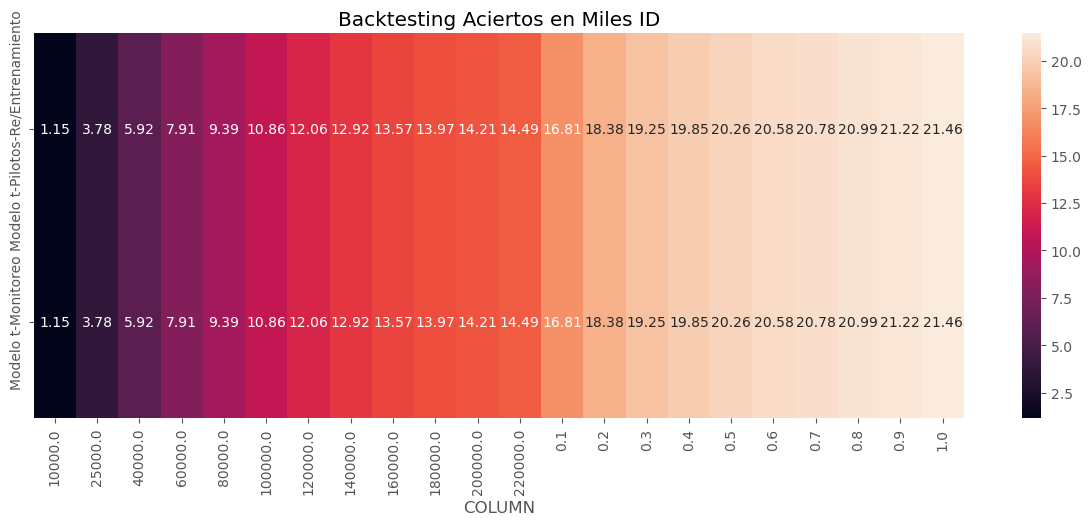

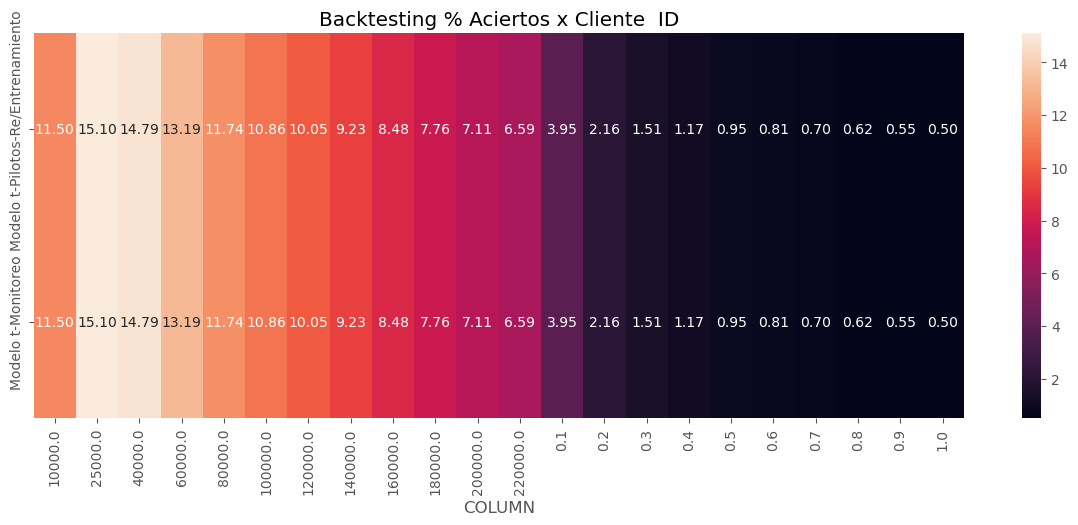

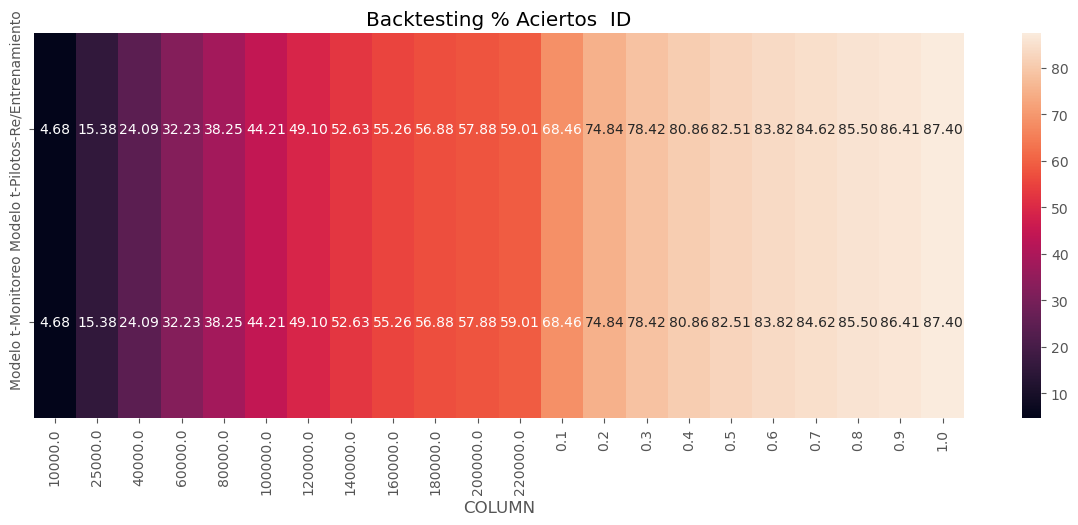

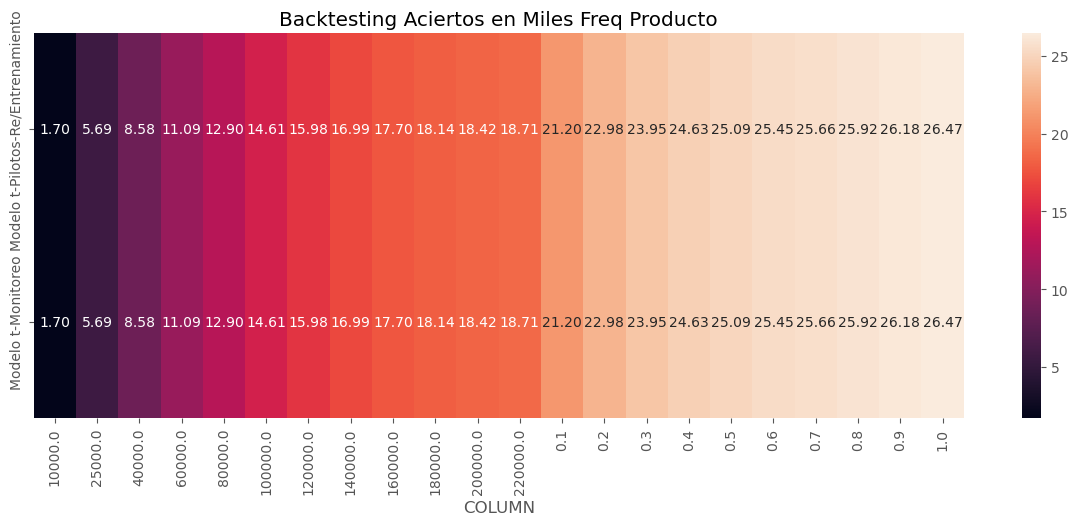

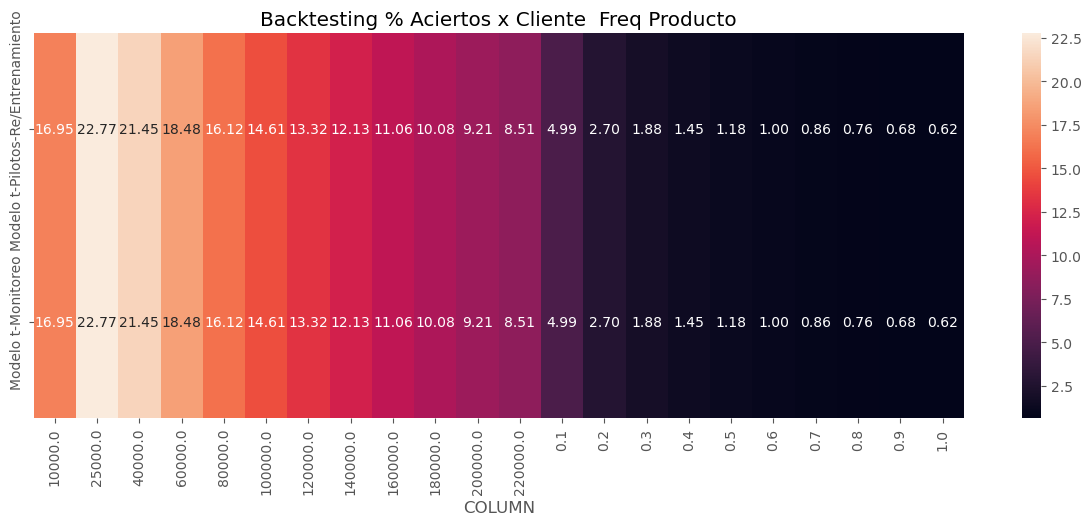

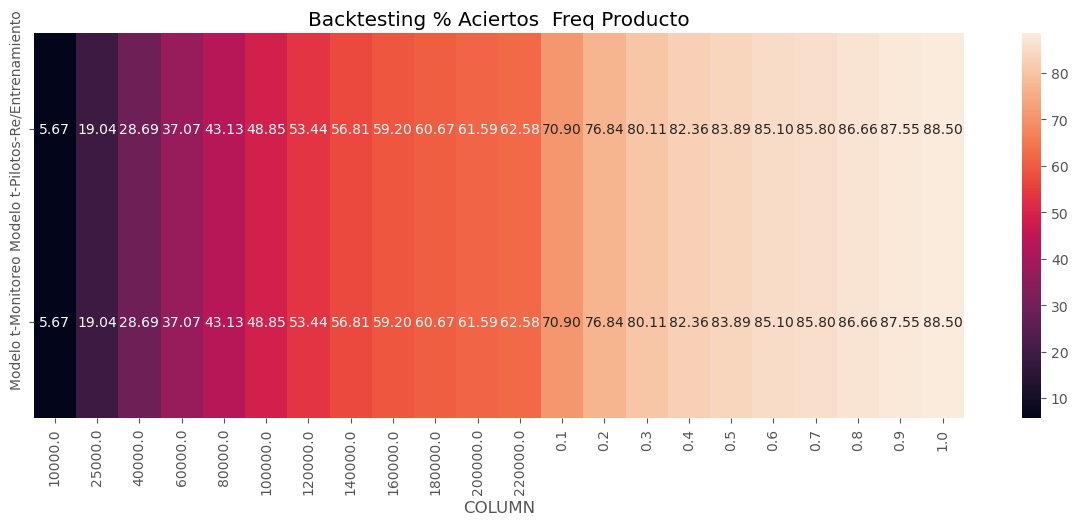

In [39]:
dic2 = backtesting.plotear_curvas_rezago(dic,parametros)
dic2 = dic.copy()

In [40]:
tipo = 'ID' # 'Freq Prod' 
modelo_evaluacion = f'Fabrica {prod.lower()}'
plots = ['Aciertos',"% Aciertos x Cliente","% Aciertos"]
eje_x = 'N' # 'COLUMN'

In [41]:
plots_dict = {}
for key in dic2.keys():
    bd_temp = dic2[key]['contactabilidad_curva']
    print(key)
    bd_temp = bd_temp[(bd_temp['Tipo']==tipo)&(bd_temp['Modelo']==modelo_evaluacion)]
    bd_temp = bd_temp.drop(['Tipo','Modelo'], axis = 1)
    for col in plots:
        bd_temp2 = bd_temp[[eje_x,col]].rename(columns = {col:key}).drop_duplicates(eje_x).set_index(eje_x)
        if col not in plots_dict.keys():
            plots_dict[col] = bd_temp2
        else:
            plots_dict[col] = pd.concat([plots_dict[col],bd_temp2], axis = 1)
plots_dict.keys()

Pilotos-Re/Entrenamiento
Monitoreo


dict_keys(['Aciertos', '% Aciertos x Cliente', '% Aciertos'])

In [42]:
plots_dict['Aciertos'].diff(axis = 1).iloc[:,1:]

Monitoreo
N                   
10000.0          0.0
25000.0          0.0
40000.0          0.0
60000.0          0.0
80000.0          0.0
100000.0         0.0
120000.0         0.0
140000.0         0.0
160000.0         0.0
180000.0         0.0
200000.0         0.0
220000.0         0.0
425145.0         0.0
850291.0         0.0
1275437.0        0.0
1700583.0        0.0
2125729.0        0.0
2550874.0        0.0
2976020.0        0.0
3401166.0        0.0
3826312.0        0.0
4251458.0        0.0

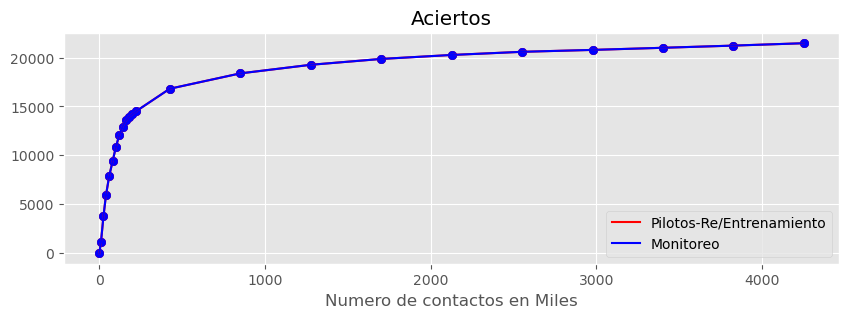

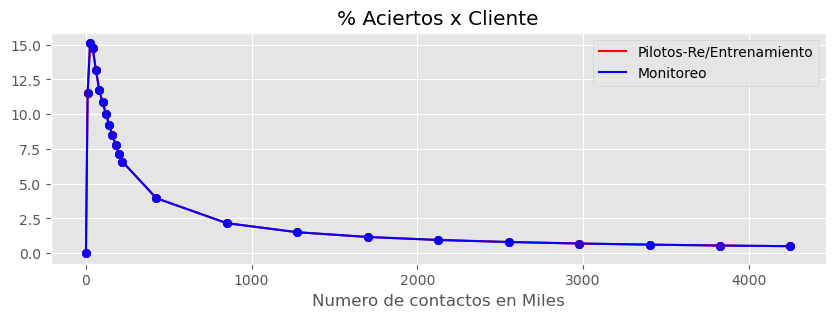

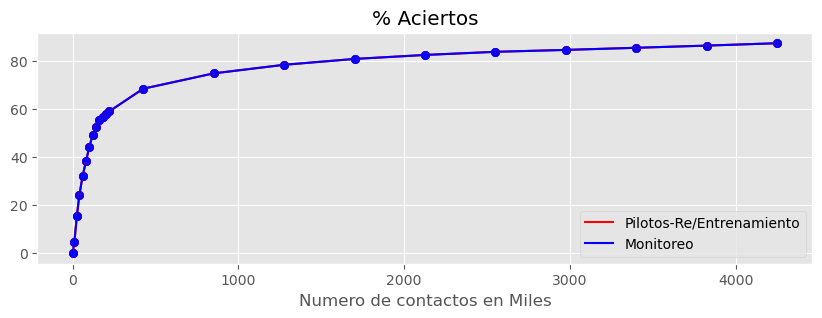

In [43]:
colors = ['red','blue','black','green']
for col in plots:
    bd_temp2 = plots_dict[col]
    bd_temp2.loc[0] = 0
    bd_temp2 = bd_temp2.sort_index(ascending=True)
    plt.figure(figsize=(10,3))
    plt.style.use('ggplot')
    for t,j in enumerate(bd_temp2.columns):
        bd_temp3 = bd_temp2[[j]]
        bd_temp3.index = bd_temp3.index/1000
        bd_temp3 = bd_temp3.dropna()
        plt.plot(bd_temp3.index,bd_temp3[j], label = j, c = colors[t])
        plt.scatter(bd_temp3.index,bd_temp3[j],c = colors[t])
    plt.title(col)
    plt.xlabel("Numero de contactos en Miles")
    plt.legend()
    plt.show()

# Comparacion de backtestings en modo 599 vs retail

In [68]:
pred_599_real_599_pickle = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/save_backtesting_new_mvp7_4_202505.pickle')
pred_599_real_retail_pickle = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/save_backtesting_new_mvp7_4_202505_v_retail.pickle')
pred_599_real_retail_preview_mlops = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/save_backtesting_202505_prueba.pickle')

In [69]:
insumo_599_real_599_pickle = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/insumo_modelo_360_new_mvp7_4_202505.pickle')
insumo_599_real_retail_pickle = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/insumo_modelo_360_new_mvp7_4_202505_v_retail.pickle')
insumo_599_preview_mlops = pd.read_pickle('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/CDT/09-backtesting/insumo_modelo_360_202505_prueba.pickle')

**Comparacion 1**

- Prediccion ejecutada vs Prediccion ejecutada
- Resultado real 599 vs resultado real retail

In [48]:
pred_599_real_599 = pred_599_real_599_pickle.copy()
pred_599_real_retail = pred_599_real_retail_pickle.copy()
insumo_599_real_599 = insumo_599_real_599_pickle.copy()
insumo_599_real_retail = insumo_599_real_retail_pickle.copy()

**Comparacion 2**

- Prediccion ejecutada vs piloto
- Resultado real 599 vs resultado real retail

In [70]:
pred_599_real_599 = pred_599_real_599_pickle.copy()
pred_599_real_retail = pred_599_real_retail_preview_mlops.copy()
insumo_599_real_599 = insumo_599_real_599_pickle.copy()
insumo_599_real_retail = insumo_599_preview_mlops.copy()

**Comparacion 3**

- Prediccion ejecutada vs Piloto
- resultado real  vs resultado real

In [87]:
pred_599_real_599 = pred_599_real_retail_pickle.copy()
pred_599_real_retail = pred_599_real_retail_preview_mlops.copy()
insumo_599_real_599 = insumo_599_real_retail_pickle.copy()
insumo_599_real_retail = insumo_599_preview_mlops.copy()

**Inicio del comparativo:**

In [88]:
print(pred_599_real_599.keys())
print(pred_599_real_599[1].keys())

dict_keys([1, 2, 3, 'Combined'])
dict_keys(['prediccion', 'prob_true', 'prob_pred', 'contactabilidad_curva', 'metrics', 'ks'])


In [89]:
def validacion_df_numerics(backtest_with_599,backtest_with_retail,xerror,msj):
    validate = ((backtest_with_599.fillna(0)-backtest_with_retail.fillna(0))*xerror).round(0).replace(0,np.nan).dropna(how='all')
    if validate.shape[0] == 0:
        print(f'Ok {msj} in {i}')
        return None
    else:
        display(validate)
        return validate
        raise ValueError(f'No coincide {msj} in {i}')  

In [90]:
import warnings

In [91]:
for i in list(pred_599_real_599.keys()):
    # Analisis de KS
    backtest_with_retail = pred_599_real_retail[i]['ks']
    backtest_with_599 = pred_599_real_599[i]['ks']
    # validacion similitud de variables numericas
    xerror = 100 # error x 100
    validate = validacion_df_numerics(backtest_with_599,backtest_with_retail,xerror,'ks metrics') 
    # analisis de overfitting-unvederfitting
    validate = pred_599_real_retail[i]['prob_true'] -pred_599_real_599[i]['prob_true']
    validate = np.round(validate*100,0) == 0
    if     all(validate):
        print(f'Ok prob_true in {i}')
    else:
        display(validate,pred_599_real_retail[i]['prob_true'],pred_599_real_599[i]['prob_true'])
        #raise ValueError(f'No coincide prob_true in {i}')
        warnings.warn(f'No coincide prob_true in {i}', UserWarning)
    validate = pred_599_real_retail[i]['prob_pred'] -pred_599_real_599[i]['prob_pred']
    validate = np.round(validate*100,0) == 0
    if all(validate):
        print(f'Ok prob_pred in {i}')
    else:
        display(validate,pred_599_real_retail[i]['prob_pred'],pred_599_real_599[i]['prob_pred'])
        #raise ValueError(f'No coincide prob_pred in {i}')
        warnings.warn(f'No coincide prob_pred in {i}', UserWarning)


Ok ks metrics in 1
Ok prob_true in 1
Ok prob_pred in 1
Ok ks metrics in 2
Ok prob_true in 2
Ok prob_pred in 2
Ok ks metrics in 3
Ok prob_true in 3
Ok prob_pred in 3
Ok ks metrics in Combined
Ok prob_true in Combined
Ok prob_pred in Combined


In [92]:
def ordenado_datos(backtest_with_retail,backtest_with_599,columns_keys):
    backtest_with_retail = backtest_with_retail.set_index(columns_keys)
    backtest_with_599 = backtest_with_599.set_index(columns_keys)
    validate = backtest_with_retail.index
    if ((validate.shape[0] - backtest_with_599.shape[0]) == 0) & (backtest_with_599.index[~backtest_with_599.index.isin(validate)].shape[0]==0):
        pass
    else:
        #raise ValueError(F'No coincide el numero de observaciones')
        warnings.warn(f'No coincide el numero de observaciones', UserWarning)
    backtest_with_retail = backtest_with_retail.loc[validate]
    backtest_with_599 = backtest_with_599.loc[validate]
    return backtest_with_retail, backtest_with_599

In [93]:
def validacion_dfs_numerics_objects(backtest_with_retail,backtest_with_599,xerror,msj):
    ## numericas:
    backtest_numeric_retail_only = backtest_with_retail.select_dtypes(exclude=['object', 'string'])
    backtest_numeric_599_only = backtest_with_599.select_dtypes(exclude=['object', 'string'])
    validate = validacion_df_numerics(backtest_numeric_599_only,backtest_numeric_retail_only,xerror,msj)
    ## caracteres
    print()
    print('-----------')
    backtest_not_numeric_retail_only = backtest_with_retail.select_dtypes(include=['object', 'string'])
    backtest_not_numeric_599_only = backtest_with_599.select_dtypes(include=['object', 'string'])
    cols = backtest_not_numeric_retail_only.columns
    if (backtest_not_numeric_retail_only.shape[0] == backtest_not_numeric_599_only.shape[0]):
        print('Cols Consistentes')
    else:
        print('Cols inconsistentes')
        print(backtest_not_numeric_retail_only.columns)
        print(backtest_not_numeric_599_only.columns)
    validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all') 
    if validate_str.shape[0]>0:
        print('Error en similitud de caracteres :')
        print('Cols: ',validate_str.columns)
        print('First 5ids: ',validate_str.index[:5])
        display(validate_str.head(3))
        display(backtest_not_numeric_retail_only.drop_duplicates())
        display(backtest_not_numeric_599_only.drop_duplicates())
    else:
        print(f'Ok Variables Strings:',backtest_not_numeric_retail_only.columns)
        validate_str = None
    return validate,validate_str

In [94]:
for i in list(pred_599_real_599.keys()):
    #for var_df,key_ls in [['prediccion',['hashvalue1']],['metrics',['metric_name','metric_type','class_name']],[['contactabilidad_curva']]:
    for var_df,key_ls in [['prediccion',['hashvalue1']],['metrics',['metric_name','metric_type','class_name']],['contactabilidad_curva',['COLUMN','Tipo','Modelo']]]:
        print(f'Iniciando {var_df}')
        # Analisis de otras vairables
        backtest_with_retail = pred_599_real_retail[i][var_df].copy()
        backtest_with_599 = pred_599_real_599[i][var_df].copy()
        xerror = 100 # error x 100
        if 'metrics' == var_df:
            try:
                backtest_with_retail.drop(['model_type','timestamp'], axis = 1, inplace = True)
                backtest_with_599.drop(['model_type','timestamp'], axis = 1, inplace = True)
            except:
                pass
        if 'contactabilidad_curva' == var_df:
            xerror = 1 # error x 1
        # validando y ordenando dataset
        backtest_with_retail,backtest_with_599 = ordenado_datos(backtest_with_retail,backtest_with_599,key_ls)
        ## numericas:
        result_num,result_str =validacion_dfs_numerics_objects(backtest_with_retail,backtest_with_599,xerror,var_df)
        print('----------------------------------')
        print()

Iniciando prediccion
Ok prediccion in 1

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name'], dtype='object')
First 5ids:  Index(['CC1070588085', 'CC40305180', 'CC17116673', 'CC1098638701',
       'CC1102883460'],
      dtype='object', name='hashvalue1')


model_name
hashvalue1              
CC1070588085       False
CC40305180         False
CC17116673         False

model_name
hashvalue1             
CC1070588085  Ensamble,

model_name
hashvalue1             
CC1070588085   Ensamble

----------------------------------

Iniciando metrics
Ok metrics in 1

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name', 'dataset_name', 'value'], dtype='object')
First 5ids:  MultiIndex([(              'N n_top',     'n_top',         '1'),
            (                'N all', 'dim shape', 'dim shape'),
            ('backtest_metric n_top',     'n_top',       '1.0'),
            (      'Precision n_top',     'n_top',           1),
            (      'Precision n_top',     'n_top',           0)],
           names=['metric_name', 'metric_type', 'class_name'])


/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')
/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')


model_name  dataset_name  value
metric_name           metric_type class_name                                 
N n_top               n_top       1                  NaN         False    NaN
N all                 dim shape   dim shape          NaN         False    NaN
backtest_metric n_top n_top       1.0                NaN         False    NaN

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202504   
N all                                        dim shape      dim shape        202504   
backtest_metric n_top                        n_top          1.0              202504   
Precision n_top                              n_top          0                202504   
recall n_top                                 n_top          1                202504   
f1-score n_top                               n_top          1                202504   
true_sum n_top                               n_top          1                202504   
                                                            0                202504   
No medible 1                                 overall metric overall          202504   
No medible 1 %                               overall metric overall          202504   
Pronosticos sin el hashvalue en la data real overall metric overall          202504   
accuracy                                     overall metric overall          202504   
f1-score                                     overall metric overall          202504   
True positives                               overall metric overall          202504   
False positives                              overall metric overall          202504   
roc_auc                                      overall metric overall          202504   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274683  
N all                                        dim shape      dim shape     4248944  
backtest_metric n_top                        n_top          1.0            1.6113  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              3.1715  
true_sum n_top                               n_top          1               20539  
                                                            0             1254144  
No medible 1                                 overall metric overall       84171.0  
No medible 1 %                               over

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202506   
N all                                        dim shape      dim shape        202506   
backtest_metric n_top                        n_top          1.0              202506   
Precision n_top                              n_top          0                202506   
recall n_top                                 n_top          1                202506   
f1-score n_top                               n_top          1                202506   
true_sum n_top                               n_top          1                202506   
                                                            0                202506   
No medible 1                                 overall metric overall          202506   
No medible 1 %                               overall metric overall          202506   
Pronosticos sin el hashvalue en la data real overall metric overall          202506   
accuracy                                     overall metric overall          202506   
f1-score                                     overall metric overall          202506   
True positives                               overall metric overall          202506   
False positives                              overall metric overall          202506   
roc_auc                                      overall metric overall          202506   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274683  
N all                                        dim shape      dim shape     4248944  
backtest_metric n_top                        n_top          1.0            1.6113  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              3.1715  
true_sum n_top                               n_top          1               20539  
                                                            0             1254144  
No medible 1                                 overall metric overall       84171.0  
No medible 1 %                               over

----------------------------------

Iniciando contactabilidad_curva
Ok contactabilidad_curva in 1

-----------
Cols Consistentes
Ok Variables Strings: Index([], dtype='object')
----------------------------------

Iniciando prediccion
Ok prediccion in 2

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name'], dtype='object')
First 5ids:  Index(['CC1010030709', 'CC40094270', 'CC79219192', 'CC1001835729',
       'CC72307980'],
      dtype='object', name='hashvalue1')


model_name
hashvalue1              
CC1010030709       False
CC40094270         False
CC79219192         False

model_name
hashvalue1             
CC1010030709  Ensamble,

model_name
hashvalue1             
CC1010030709   Ensamble

----------------------------------

Iniciando metrics
Ok metrics in 2

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name', 'dataset_name', 'value'], dtype='object')
First 5ids:  MultiIndex([(              'N n_top',     'n_top',         '1'),
            (                'N all', 'dim shape', 'dim shape'),
            ('backtest_metric n_top',     'n_top',       '1.0'),
            (      'Precision n_top',     'n_top',           1),
            (      'Precision n_top',     'n_top',           0)],
           names=['metric_name', 'metric_type', 'class_name'])


/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')
/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')


model_name  dataset_name  value
metric_name           metric_type class_name                                 
N n_top               n_top       1                  NaN         False    NaN
N all                 dim shape   dim shape          NaN         False    NaN
backtest_metric n_top n_top       1.0                NaN         False    NaN

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202503   
N all                                        dim shape      dim shape        202503   
backtest_metric n_top                        n_top          1.0              202503   
Precision n_top                              n_top          0                202503   
recall n_top                                 n_top          1                202503   
f1-score n_top                               n_top          1                202503   
true_sum n_top                               n_top          1                202503   
                                                            0                202503   
No medible 1                                 overall metric overall          202503   
No medible 1 %                               overall metric overall          202503   
Pronosticos sin el hashvalue en la data real overall metric overall          202503   
accuracy                                     overall metric overall          202503   
f1-score                                     overall metric overall          202503   
True positives                               overall metric overall          202503   
False positives                              overall metric overall          202503   
roc_auc                                      overall metric overall          202503   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1275437  
N all                                        dim shape      dim shape     4251458  
backtest_metric n_top                        n_top          1.0            1.5105  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              2.9761  
true_sum n_top                               n_top          1               19266  
                                                            0             1256171  
No medible 1                                 overall metric overall      168441.0  
No medible 1 %                               over

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202506   
N all                                        dim shape      dim shape        202506   
backtest_metric n_top                        n_top          1.0              202506   
Precision n_top                              n_top          0                202506   
recall n_top                                 n_top          1                202506   
f1-score n_top                               n_top          1                202506   
true_sum n_top                               n_top          1                202506   
                                                            0                202506   
No medible 1                                 overall metric overall          202506   
No medible 1 %                               overall metric overall          202506   
Pronosticos sin el hashvalue en la data real overall metric overall          202506   
accuracy                                     overall metric overall          202506   
f1-score                                     overall metric overall          202506   
True positives                               overall metric overall          202506   
False positives                              overall metric overall          202506   
roc_auc                                      overall metric overall          202506   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1275437  
N all                                        dim shape      dim shape     4251458  
backtest_metric n_top                        n_top          1.0            1.5105  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              2.9761  
true_sum n_top                               n_top          1               19266  
                                                            0             1256171  
No medible 1                                 overall metric overall      168441.0  
No medible 1 %                               over

----------------------------------

Iniciando contactabilidad_curva
Ok contactabilidad_curva in 2

-----------
Cols Consistentes
Ok Variables Strings: Index([], dtype='object')
----------------------------------

Iniciando prediccion
Ok prediccion in 3

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name'], dtype='object')
First 5ids:  Index(['CC1007263038', 'CC63289374', 'CC1054925828', 'CC71362058',
       'CC93119780'],
      dtype='object', name='hashvalue1')


model_name
hashvalue1              
CC1007263038       False
CC63289374         False
CC1054925828       False

model_name
hashvalue1             
CC1007263038  Ensamble,

model_name
hashvalue1             
CC1007263038   Ensamble

----------------------------------

Iniciando metrics
Ok metrics in 3

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name', 'dataset_name', 'value'], dtype='object')
First 5ids:  MultiIndex([(              'N n_top',     'n_top',         '1'),
            (                'N all', 'dim shape', 'dim shape'),
            ('backtest_metric n_top',     'n_top',       '1.0'),
            (      'Precision n_top',     'n_top',           1),
            (      'Precision n_top',     'n_top',           0)],
           names=['metric_name', 'metric_type', 'class_name'])


/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')
/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')


model_name  dataset_name  value
metric_name           metric_type class_name                                 
N n_top               n_top       1                  NaN         False    NaN
N all                 dim shape   dim shape          NaN         False    NaN
backtest_metric n_top n_top       1.0                NaN         False    NaN

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202502   
N all                                        dim shape      dim shape        202502   
backtest_metric n_top                        n_top          1.0              202502   
Precision n_top                              n_top          0                202502   
recall n_top                                 n_top          1                202502   
f1-score n_top                               n_top          1                202502   
true_sum n_top                               n_top          1                202502   
                                                            0                202502   
No medible 1                                 overall metric overall          202502   
No medible 1 %                               overall metric overall          202502   
Pronosticos sin el hashvalue en la data real overall metric overall          202502   
accuracy                                     overall metric overall          202502   
f1-score                                     overall metric overall          202502   
True positives                               overall metric overall          202502   
False positives                              overall metric overall          202502   
roc_auc                                      overall metric overall          202502   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274081  
N all                                        dim shape      dim shape     4246937  
backtest_metric n_top                        n_top          1.0            1.4585  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1               2.875  
true_sum n_top                               n_top          1               18582  
                                                            0             1255499  
No medible 1                                 overall metric overall      242221.0  
No medible 1 %                               over

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202506   
N all                                        dim shape      dim shape        202506   
backtest_metric n_top                        n_top          1.0              202506   
Precision n_top                              n_top          0                202506   
recall n_top                                 n_top          1                202506   
f1-score n_top                               n_top          1                202506   
true_sum n_top                               n_top          1                202506   
                                                            0                202506   
No medible 1                                 overall metric overall          202506   
No medible 1 %                               overall metric overall          202506   
Pronosticos sin el hashvalue en la data real overall metric overall          202506   
accuracy                                     overall metric overall          202506   
f1-score                                     overall metric overall          202506   
True positives                               overall metric overall          202506   
False positives                              overall metric overall          202506   
roc_auc                                      overall metric overall          202506   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274081  
N all                                        dim shape      dim shape     4246937  
backtest_metric n_top                        n_top          1.0            1.4585  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1               2.875  
true_sum n_top                               n_top          1               18582  
                                                            0             1255499  
No medible 1                                 overall metric overall      242221.0  
No medible 1 %                               over

----------------------------------

Iniciando contactabilidad_curva
Ok contactabilidad_curva in 3

-----------
Cols Consistentes
Ok Variables Strings: Index([], dtype='object')
----------------------------------

Iniciando prediccion
Ok prediccion in Combined

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name'], dtype='object')
First 5ids:  Index(['CC1007263038', 'CC1070588085', 'CC40305180', 'CC17116673',
       'CC1010030709'],
      dtype='object', name='hashvalue1')


model_name
hashvalue1              
CC1007263038       False
CC1070588085       False
CC40305180         False

model_name
hashvalue1             
CC1007263038  Ensamble,

model_name
hashvalue1             
CC1007263038   Ensamble

----------------------------------

Iniciando metrics
Ok metrics in Combined

-----------
Cols Consistentes
Error en similitud de caracteres :
Cols:  Index(['model_name', 'dataset_name', 'value'], dtype='object')
First 5ids:  MultiIndex([(              'N n_top',     'n_top',         '1'),
            (                'N all', 'dim shape', 'dim shape'),
            ('backtest_metric n_top',     'n_top',       '1.0'),
            (      'Precision n_top',     'n_top',           1),
            (      'Precision n_top',     'n_top',           0)],
           names=['metric_name', 'metric_type', 'class_name'])


/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')
/tmp/ipykernel_6620/1218595491.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validate_str = (backtest_not_numeric_retail_only[cols].fillna('Na') == backtest_not_numeric_599_only[cols].fillna('Na')).replace(True,np.nan).dropna(how = 'all')


model_name  dataset_name  value
metric_name           metric_type class_name                                 
N n_top               n_top       1                  NaN         False    NaN
N all                 dim shape   dim shape          NaN         False    NaN
backtest_metric n_top n_top       1.0                NaN         False    NaN

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1              Combined   
N all                                        dim shape      dim shape      Combined   
backtest_metric n_top                        n_top          1.0            Combined   
Precision n_top                              n_top          0              Combined   
recall n_top                                 n_top          1              Combined   
f1-score n_top                               n_top          1              Combined   
true_sum n_top                               n_top          1              Combined   
                                                            0              Combined   
No medible 1                                 overall metric overall        Combined   
No medible 1 %                               overall metric overall        Combined   
Pronosticos sin el hashvalue en la data real overall metric overall        Combined   
accuracy                                     overall metric overall        Combined   
f1-score                                     overall metric overall        Combined   
True positives                               overall metric overall        Combined   
False positives                              overall metric overall        Combined   
roc_auc                                      overall metric overall        Combined   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274081  
N all                                        dim shape      dim shape     4246938  
backtest_metric n_top                        n_top          1.0            1.6125  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              3.1737  
true_sum n_top                               n_top          1               20544  
                                                            0             1253537  
No medible 1                                 overall metric overall      222323.0  
No medible 1 %                               over

model_name  \
metric_name                                  metric_type    class_name              
N n_top                                      n_top          1                 CDT   
N all                                        dim shape      dim shape         CDT   
backtest_metric n_top                        n_top          1.0               CDT   
Precision n_top                              n_top          0                 CDT   
recall n_top                                 n_top          1                 CDT   
f1-score n_top                               n_top          1                 CDT   
true_sum n_top                               n_top          1                 CDT   
                                                            0                 CDT   
No medible 1                                 overall metric overall           CDT   
No medible 1 %                               overall metric overall           CDT   
Pronosticos sin el hashvalue en la data real overall metric overall           CDT   
accuracy                                     overall metric overall           CDT   
f1-score                                     overall metric overall           CDT   
True positives                               overall metric overall           CDT   
False positives                              overall metric overall           CDT   
roc_auc                                      overall metric overall           CDT   

                                                                       dataset_name  \
metric_name                                  metric_type    class_name                
N n_top                                      n_top          1                202506   
N all                                        dim shape      dim shape        202506   
backtest_metric n_top                        n_top          1.0              202506   
Precision n_top                              n_top          0                202506   
recall n_top                                 n_top          1                202506   
f1-score n_top                               n_top          1                202506   
true_sum n_top                               n_top          1                202506   
                                                            0                202506   
No medible 1                                 overall metric overall          202506   
No medible 1 %                               overall metric overall          202506   
Pronosticos sin el hashvalue en la data real overall metric overall          202506   
accuracy                                     overall metric overall          202506   
f1-score                                     overall metric overall          202506   
True positives                               overall metric overall          202506   
False positives                              overall metric overall          202506   
roc_auc                                      overall metric overall          202506   

                                                                            value  
metric_name                                  metric_type    class_name             
N n_top                                      n_top          1             1274081  
N all                                        dim shape      dim shape     4246938  
backtest_metric n_top                        n_top          1.0            1.6125  
Precision n_top                              n_top          0                 0.0  
recall n_top                                 n_top          1               100.0  
f1-score n_top                               n_top          1              3.1737  
true_sum n_top                               n_top          1               20544  
                                                            0             1253537  
No medible 1                                 overall metric overall      222323.0  
No medible 1 %                               over

----------------------------------

Iniciando contactabilidad_curva


Aciertos   N  % Aciertos x Cliente  \
COLUMN Tipo          Modelo                                            
0.9    ID            Fabrica cdt       1.0 NaN                   NaN   
       Freq Producto Fabrica cdt       1.0 NaN                   NaN   

                                  % Aciertos  
COLUMN Tipo          Modelo                   
0.9    ID            Fabrica cdt         NaN  
       Freq Producto Fabrica cdt         NaN


-----------
Cols Consistentes
Ok Variables Strings: Index([], dtype='object')
----------------------------------



In [95]:
t=2
modelos = [pred_599_real_retail_preview_mlops,pred_599_real_retail_pickle,pred_599_real_599_pickle,backtesting_pilotaje]
nombres = ['Back retail Preview Mlops','Back retail','Back 599','arriba']

In [96]:
params = {'id':'hashvalue1',
          'n_tops':pred_599_real_retail[t]['contactabilidad_curva']['COLUMN'].drop_duplicates().dropna().values.tolist()}

In [80]:
dic = {}
for pos,save_backtesting in enumerate(modelos):
    base_calificada_fabrica = save_backtesting[t]['prediccion']
    full_base = base_calificada_fabrica.shape[0]
    base_calificada_fabrica2 = base_calificada_fabrica.copy()
    #base_calificada_fabrica2['hashvalue1'] = base_calificada_fabrica2['hashvalue1'].str[1:]
    #display(base_calificada_fabrica2.head(2))
    dic[nombres[pos]] = {'prediccion': base_calificada_fabrica2}
    dic[nombres[pos]]['contactabilidad'] = save_backtesting[t]['contactabilidad_curva']#backtesting.create_curve_backtesting(base_calificada_fabrica2,full_base,params)
    dic[nombres[pos]]['contactabilidad_curva'] = save_backtesting[t]['contactabilidad_curva']

In [81]:
params['x_dim_plot'] = 1000
params['target'] = 'cdt_target'

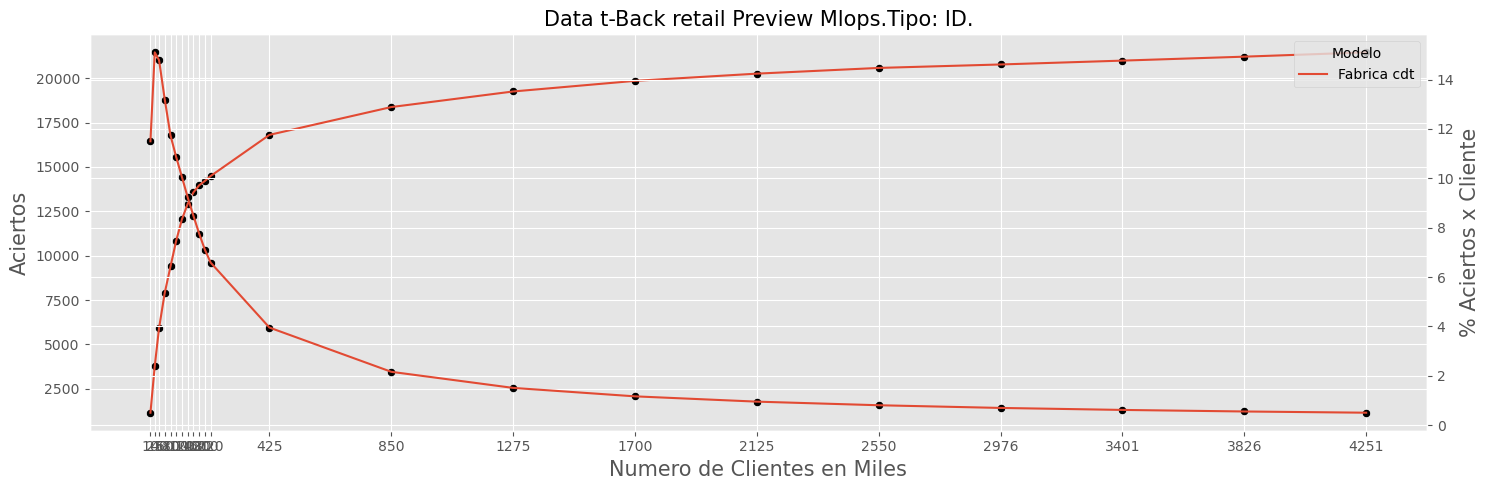

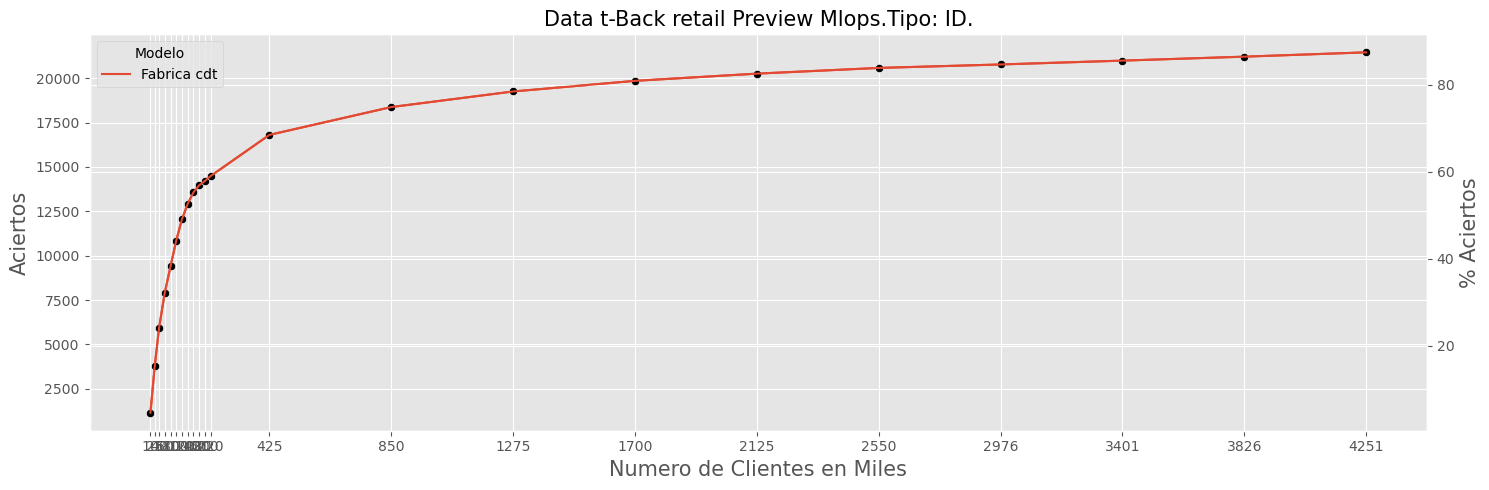

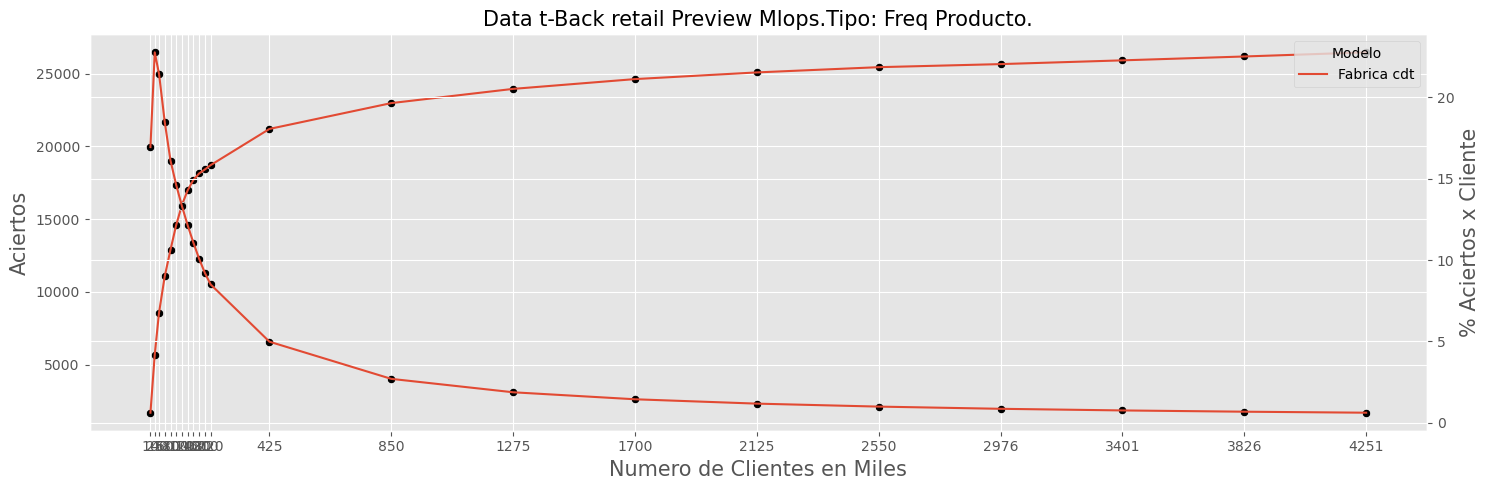

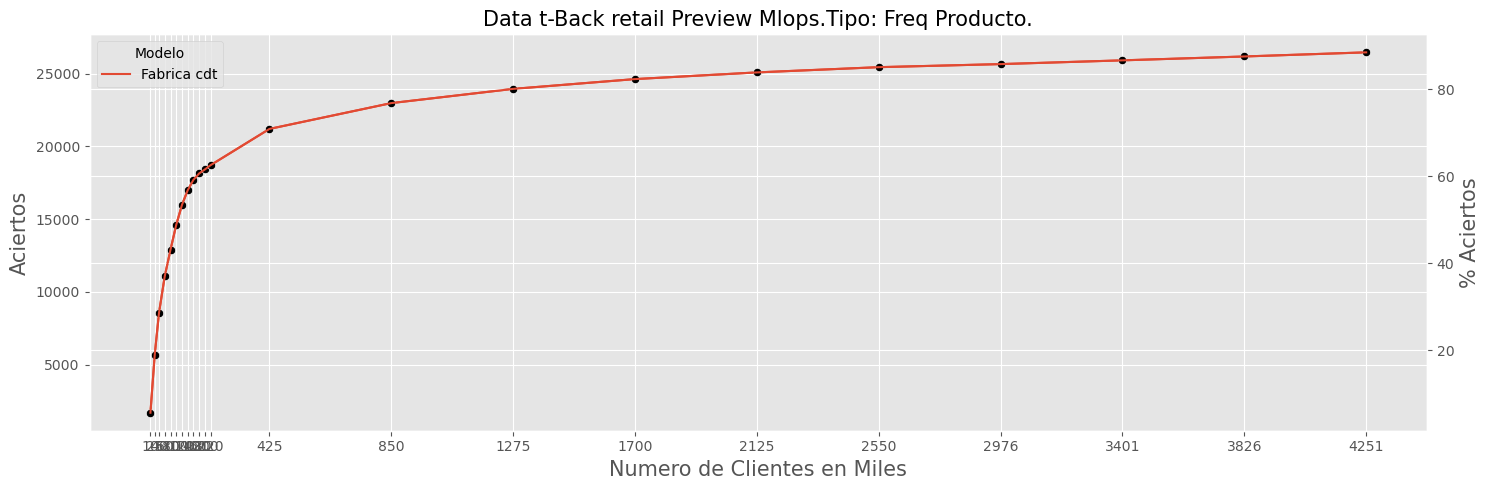

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


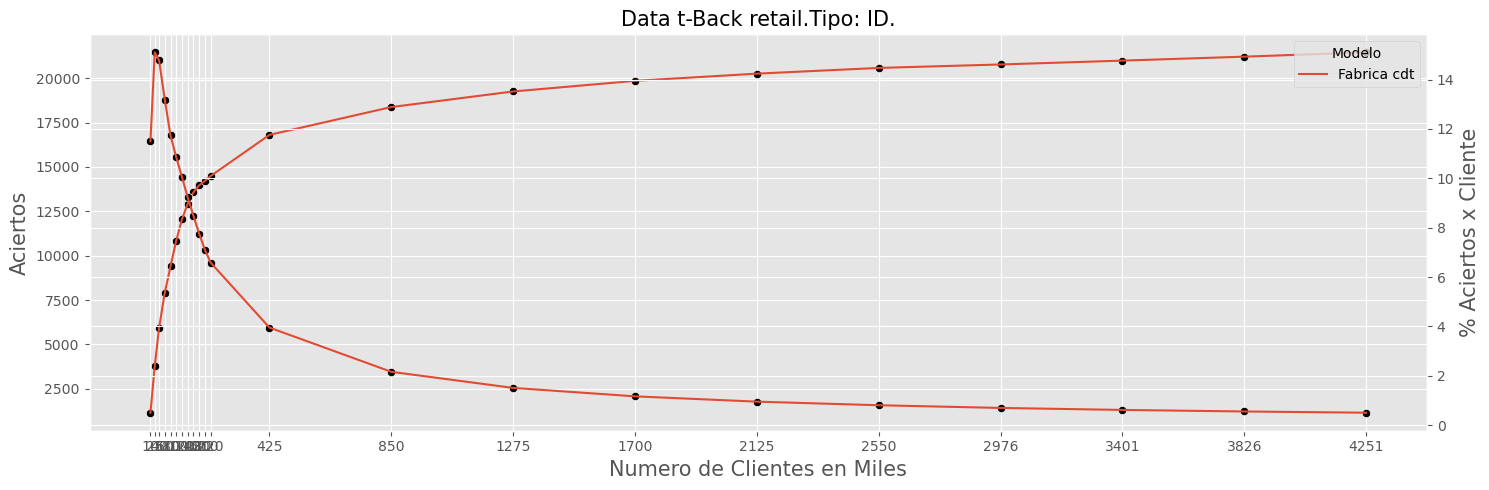

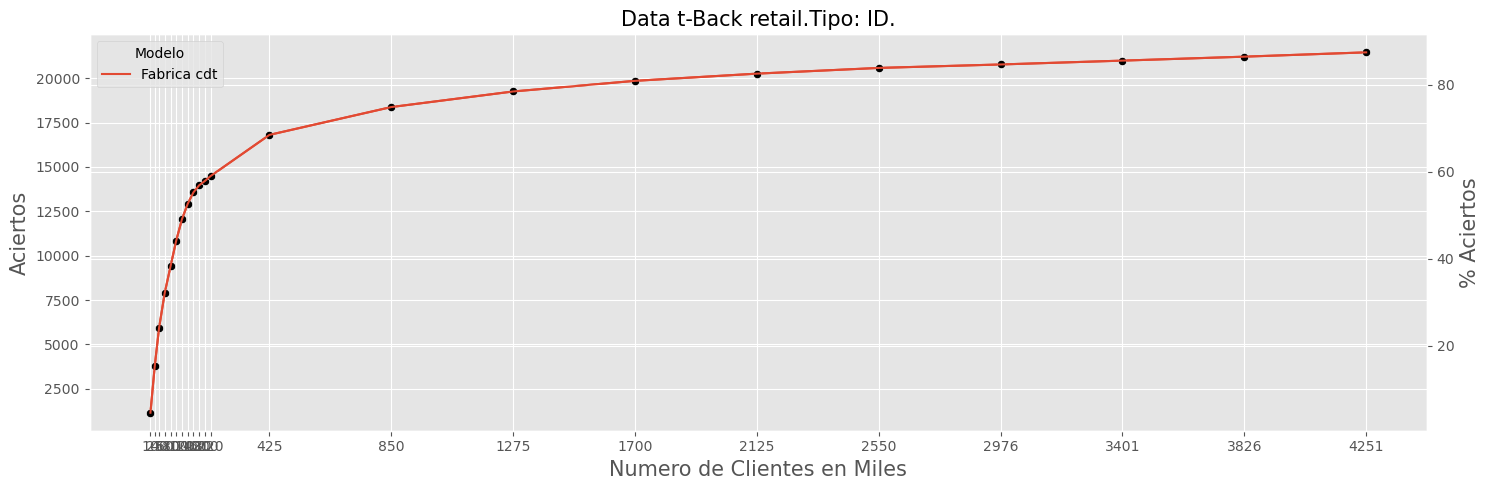

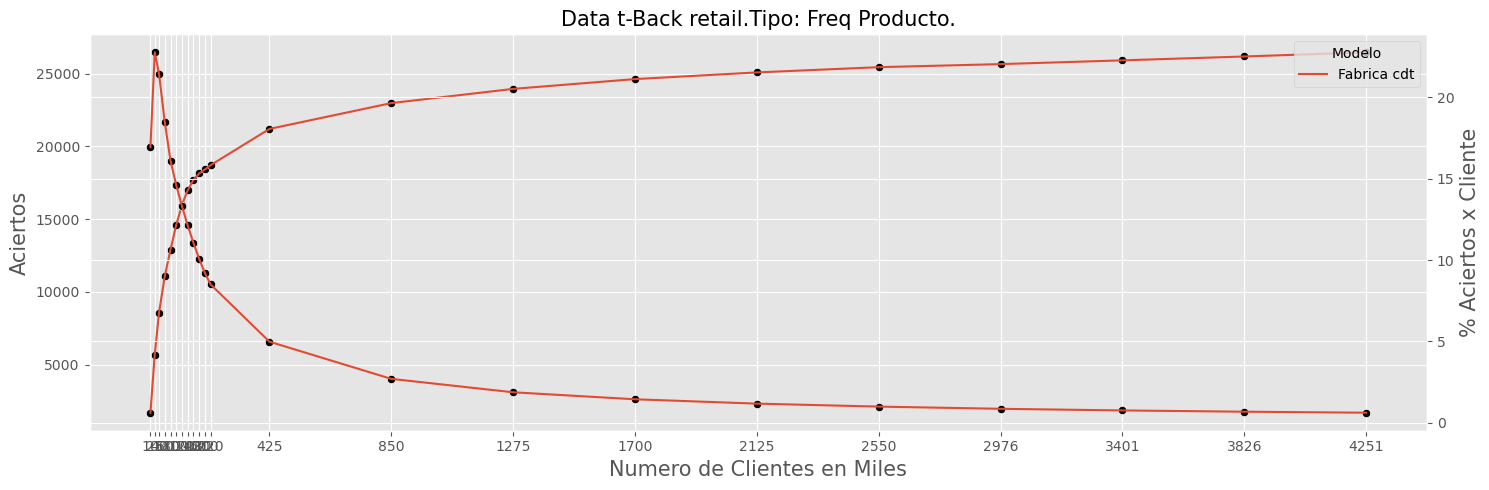

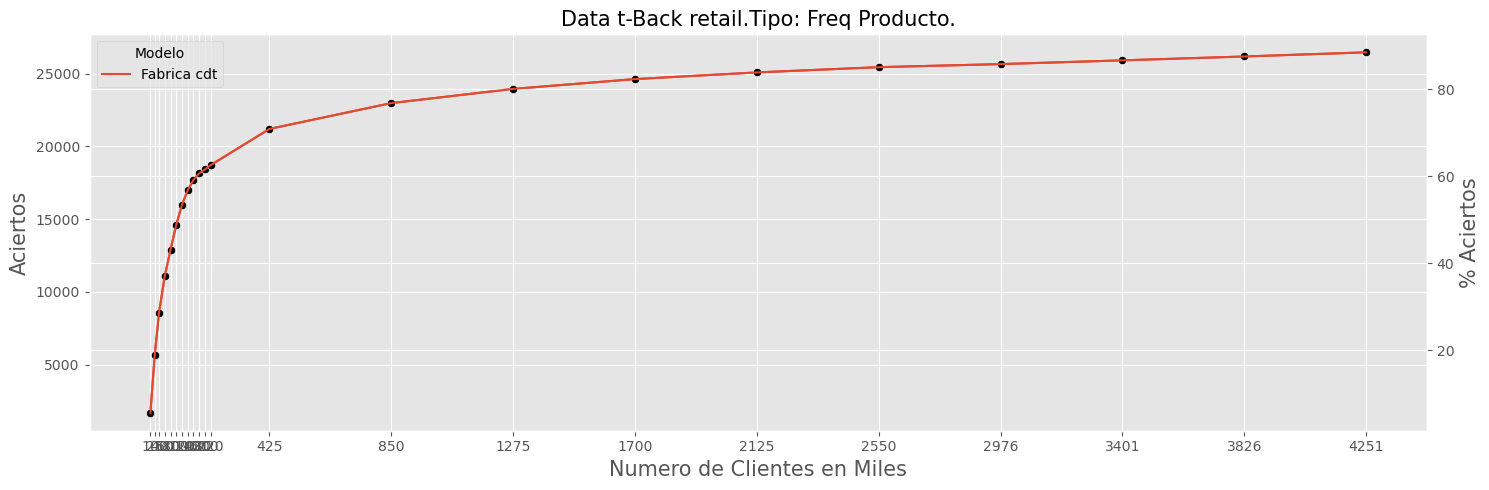

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


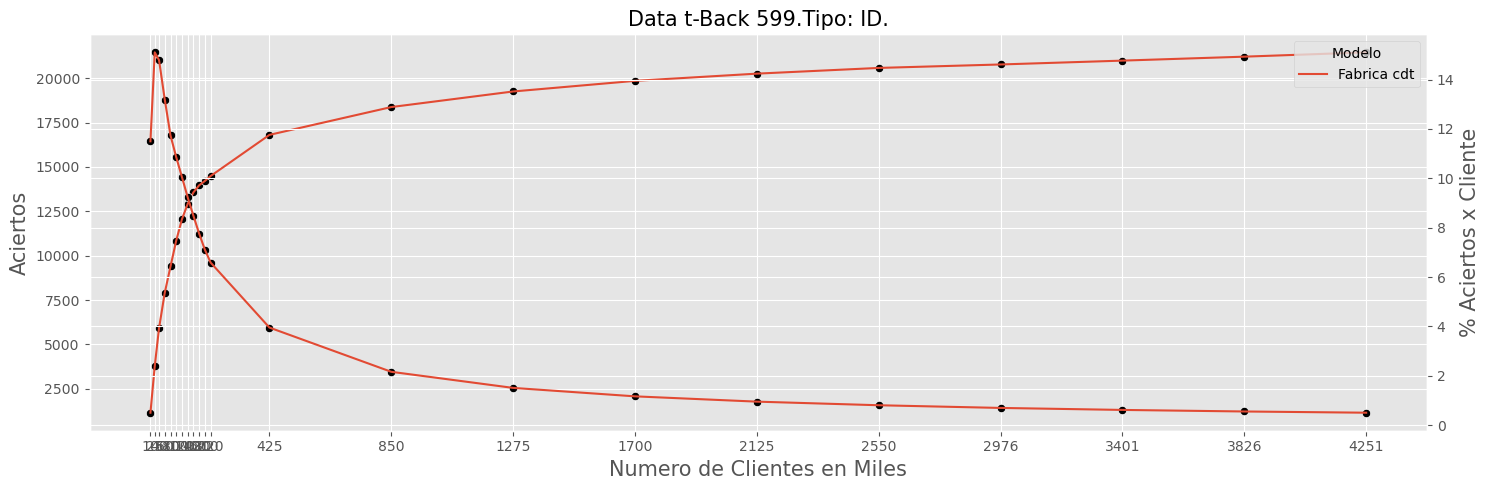

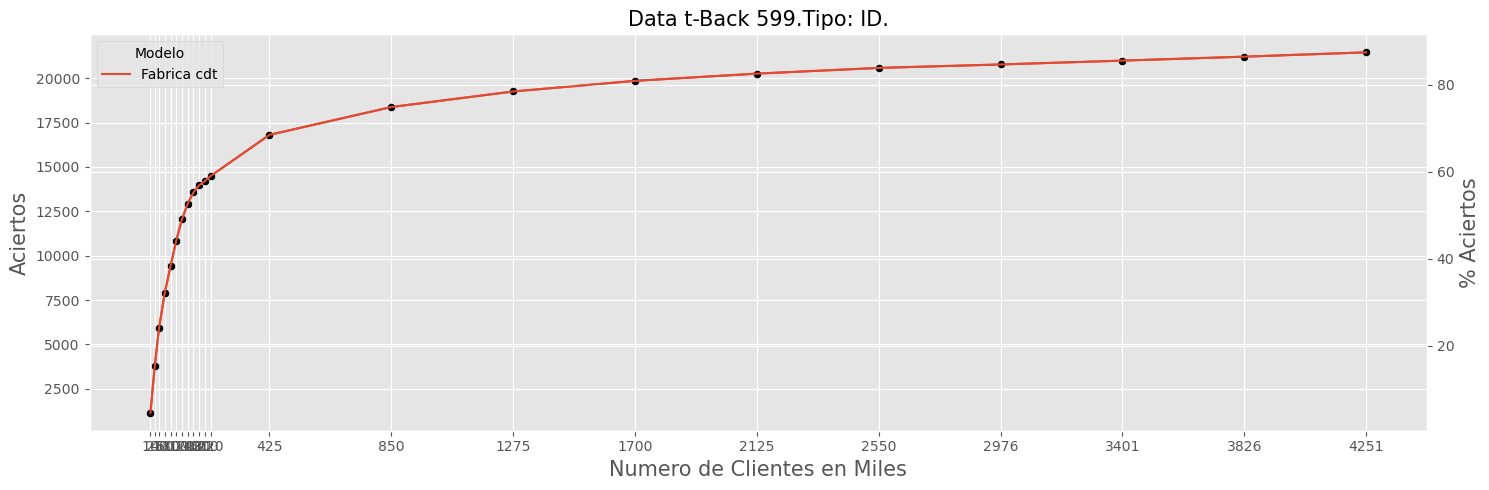

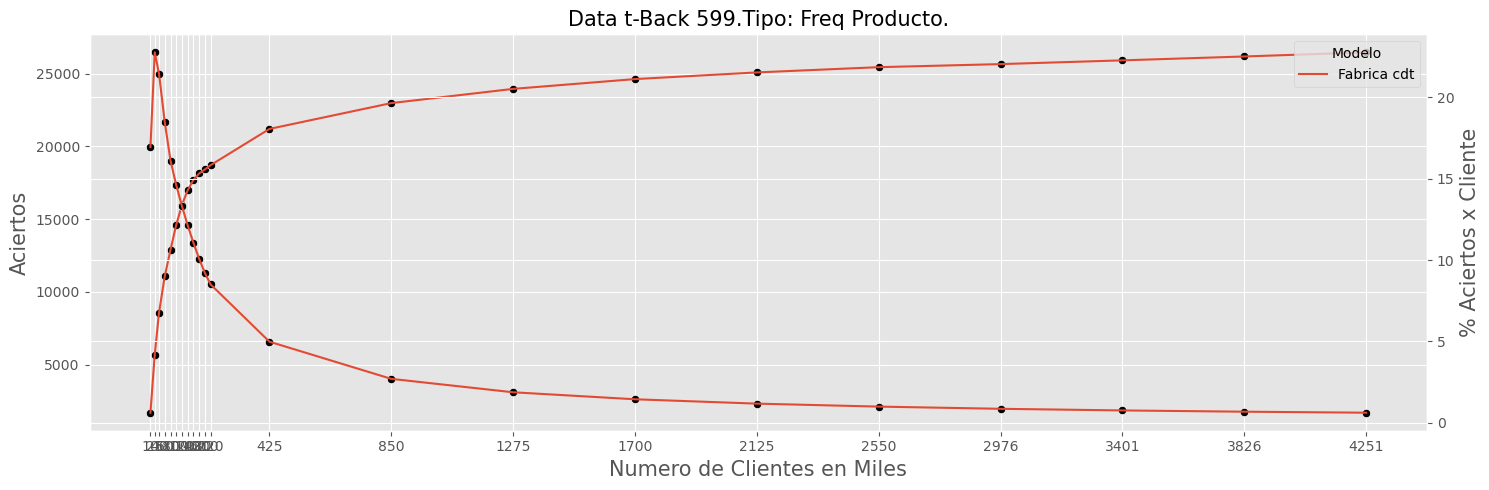

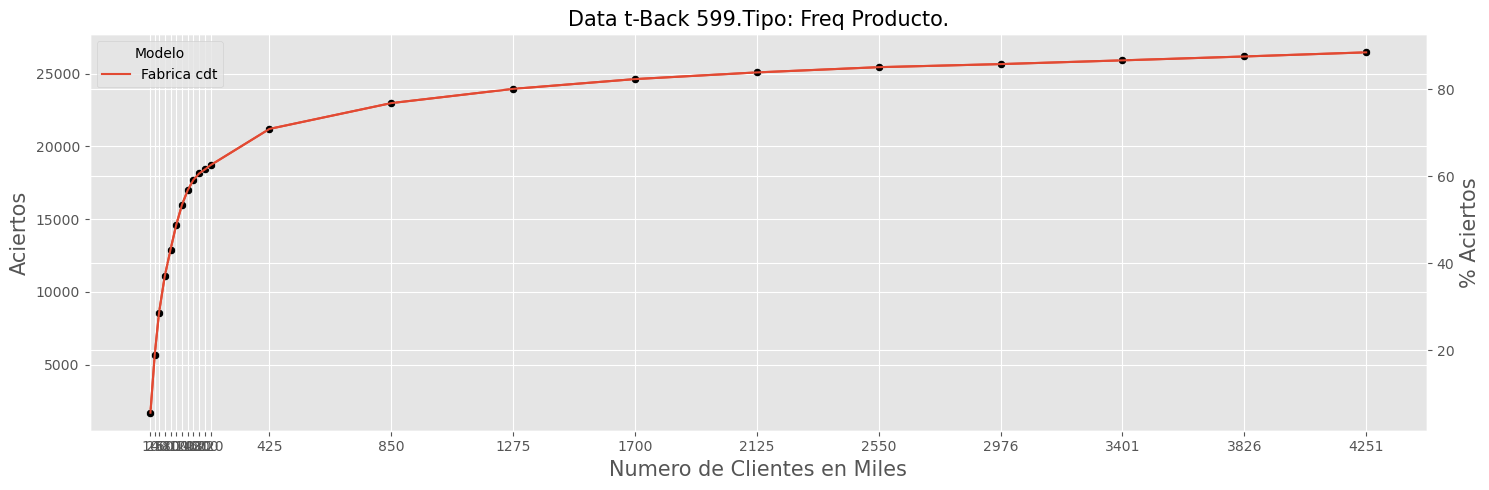

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


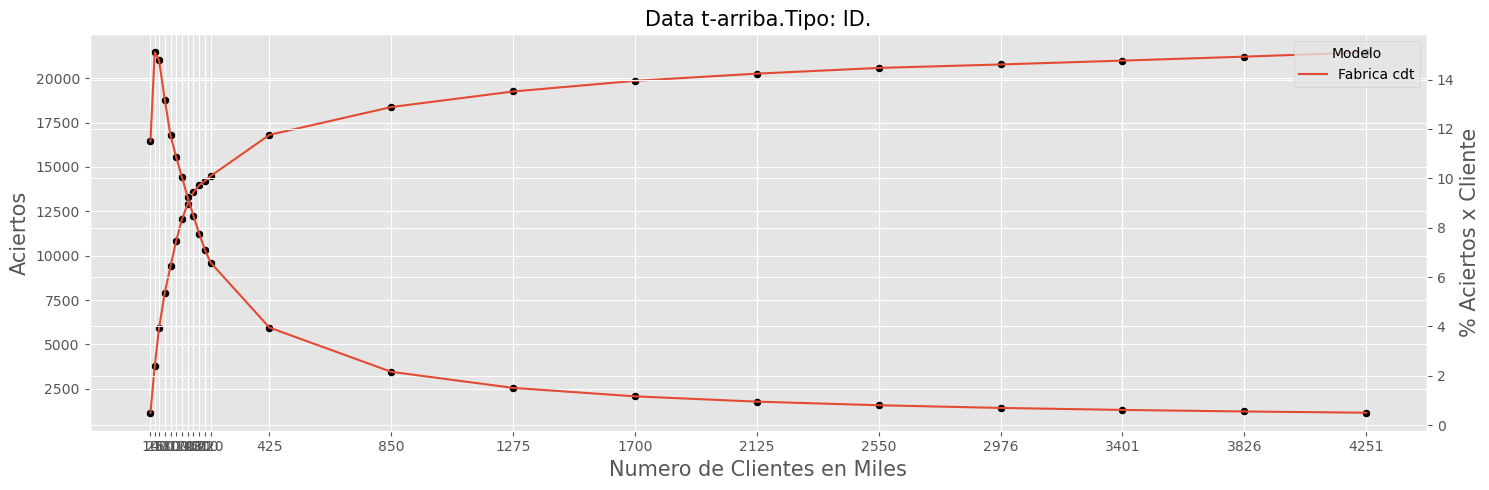

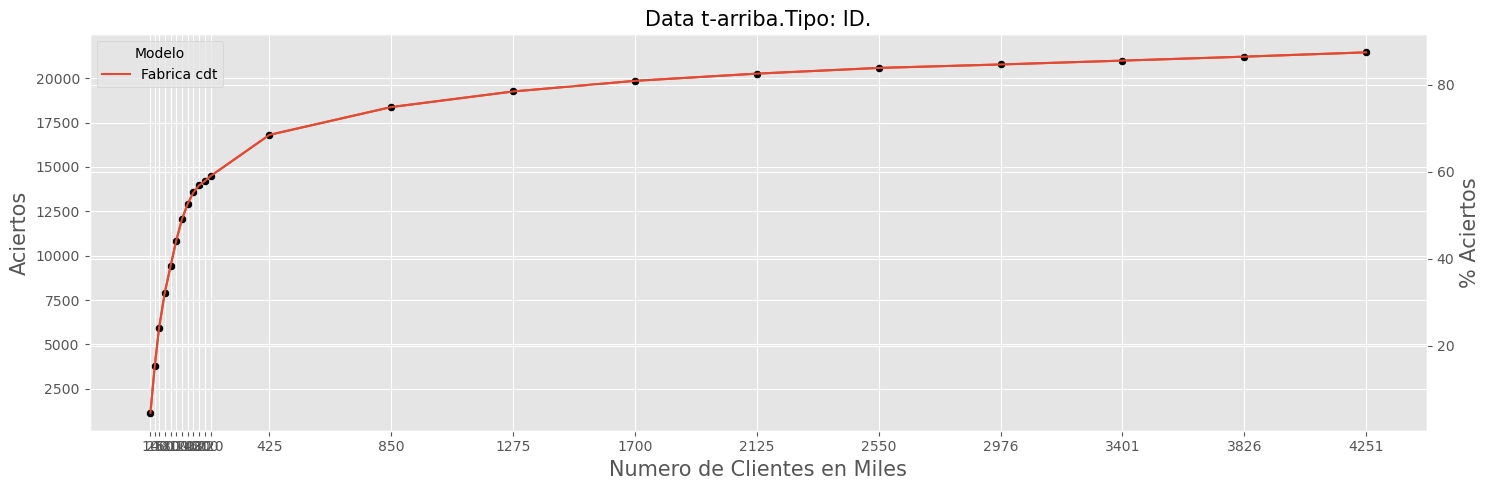

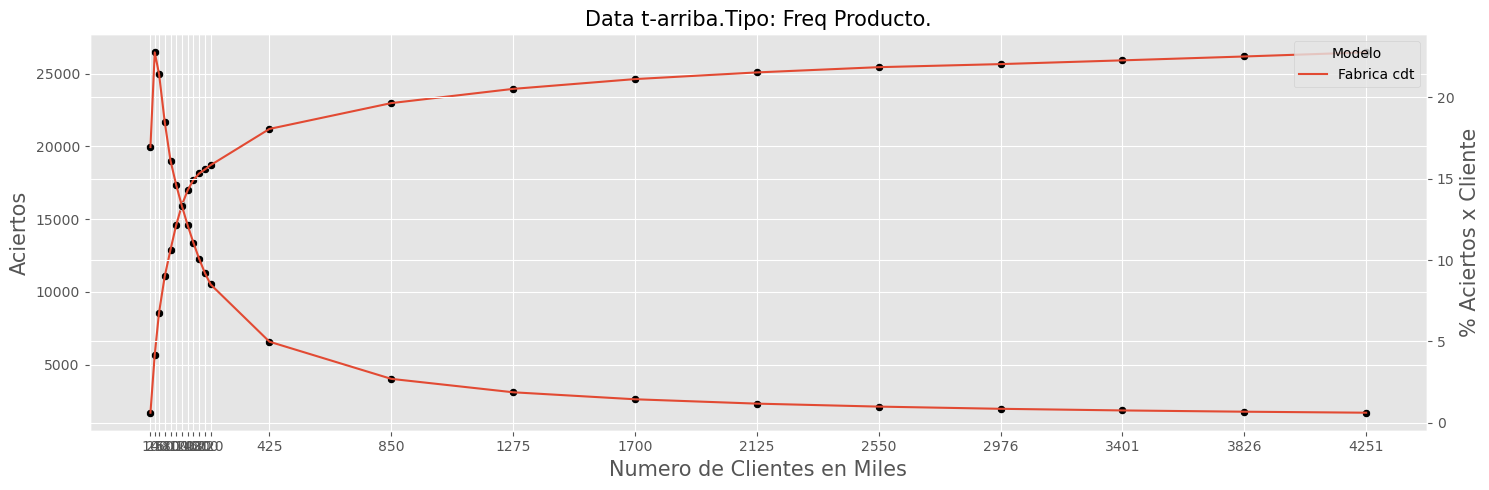

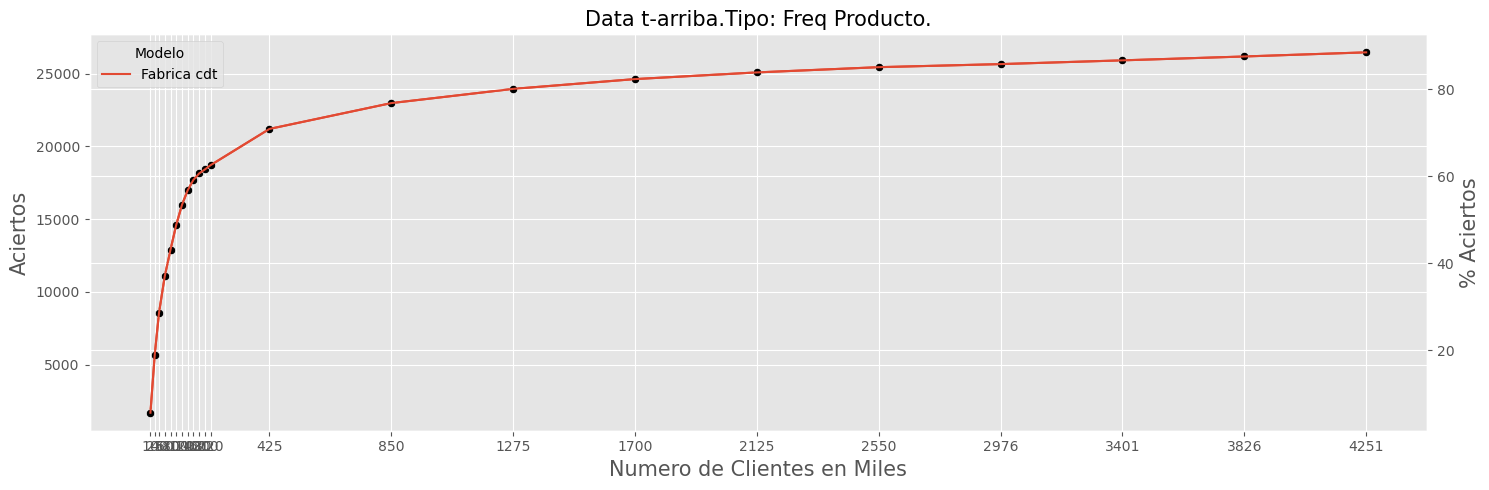

INFO:data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes:------------------------------


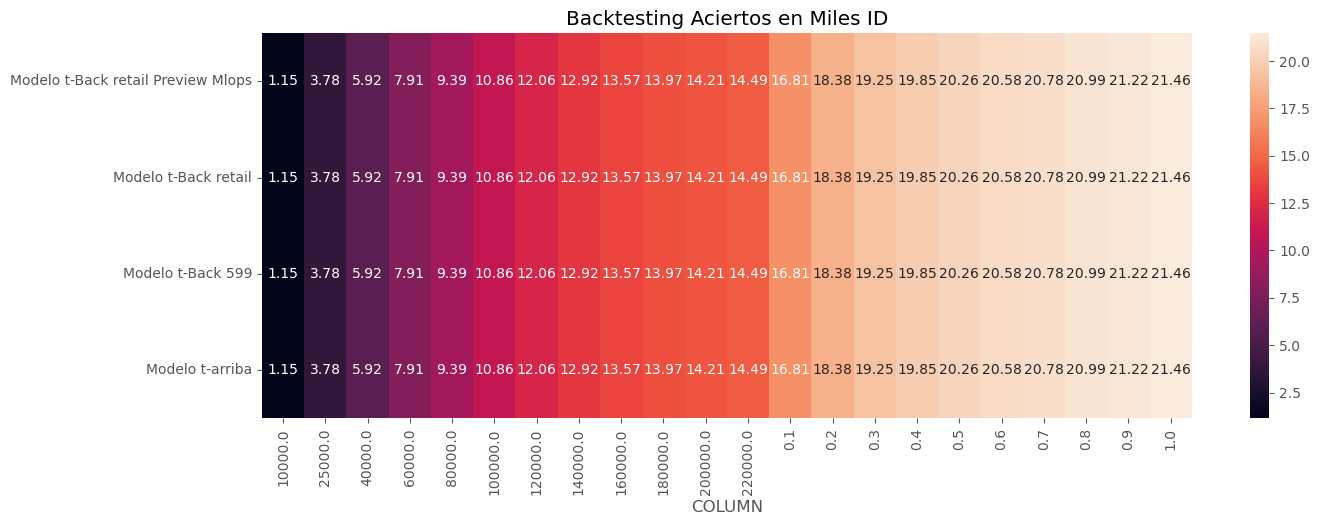

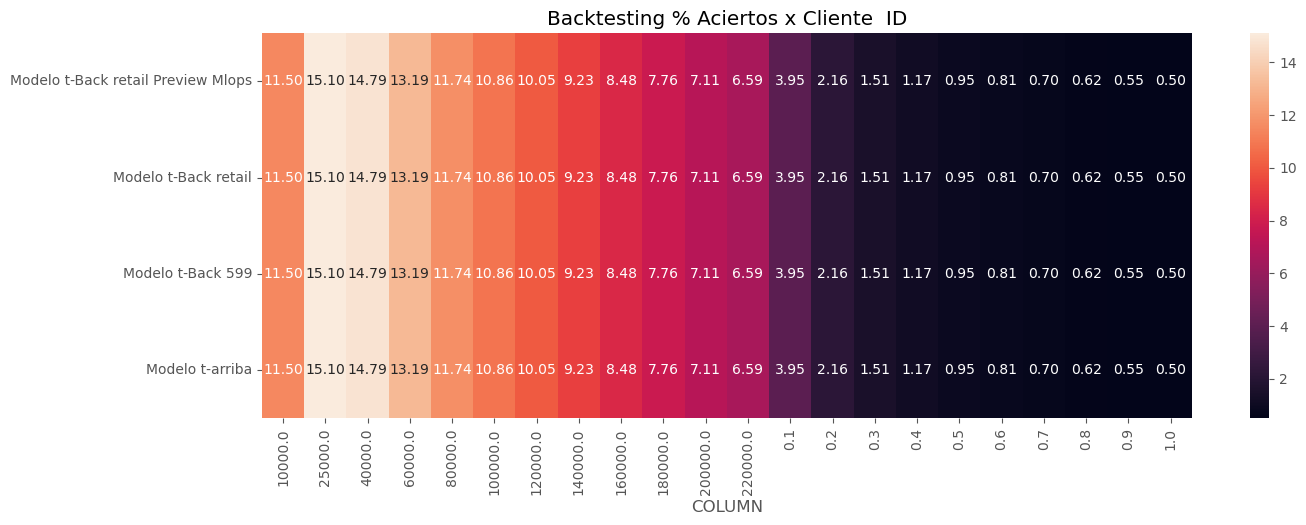

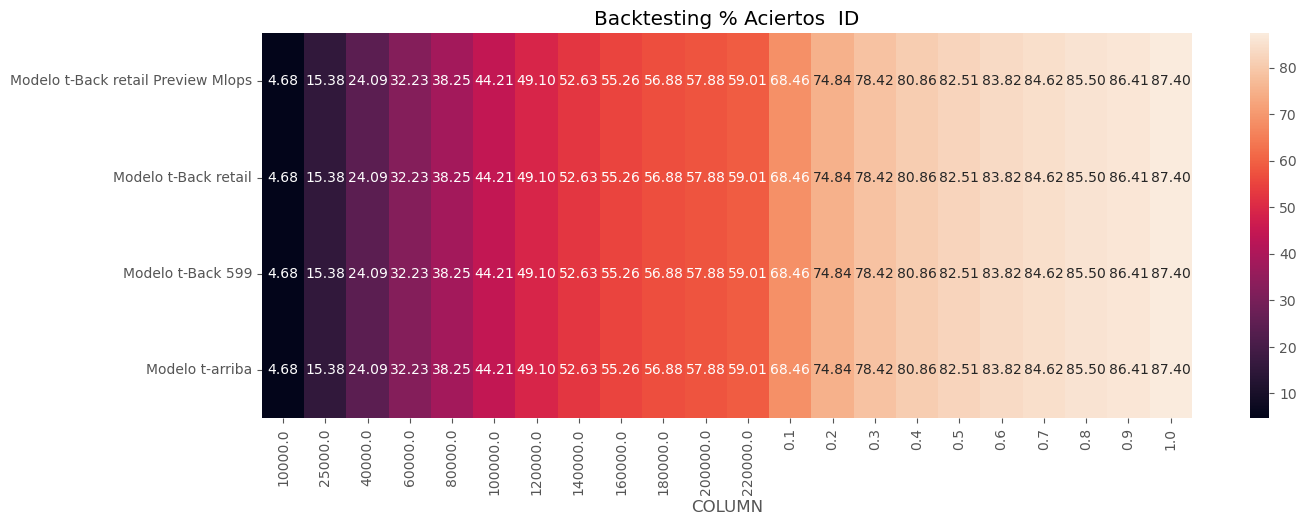

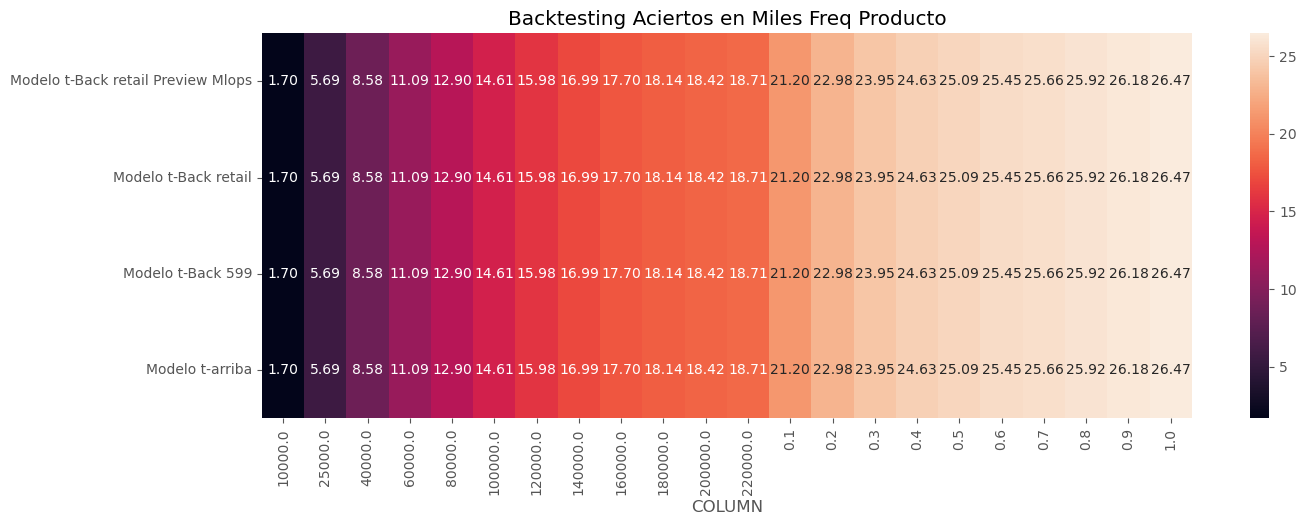

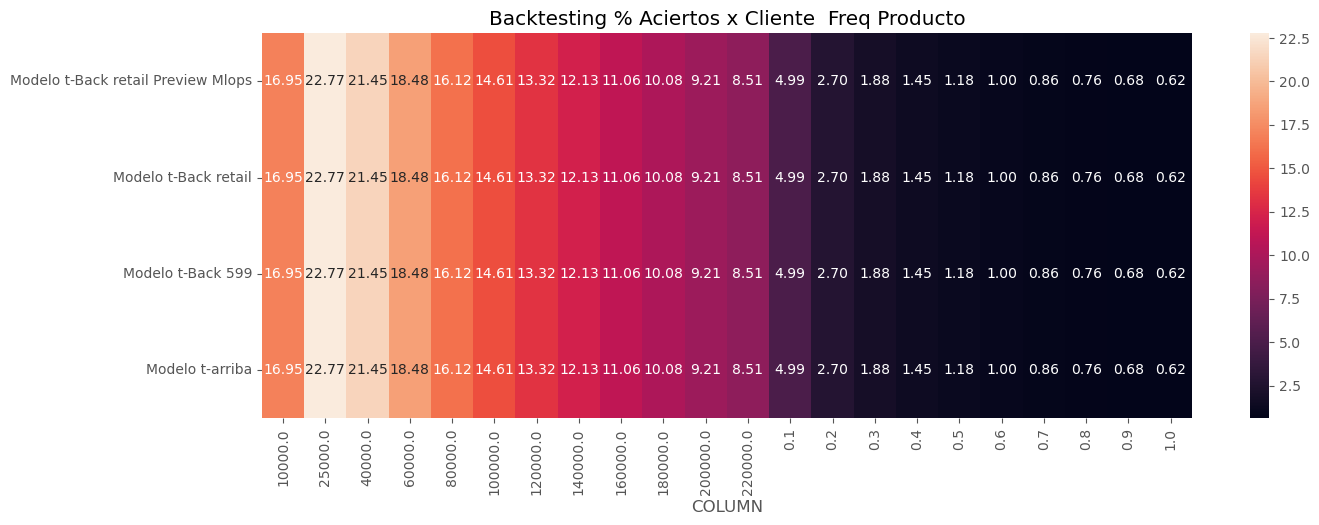

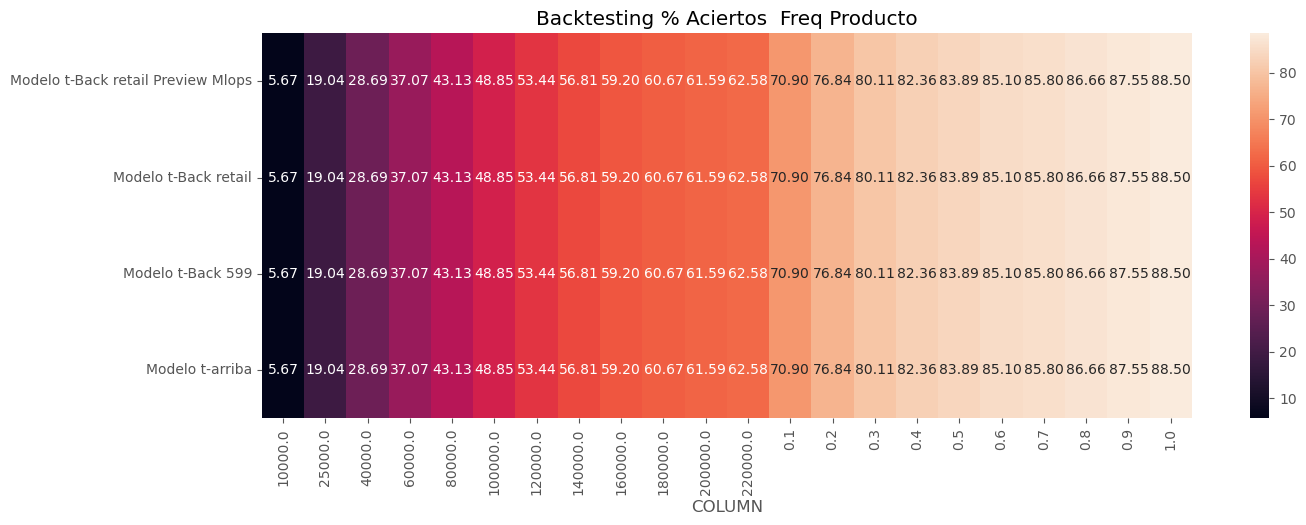

In [82]:
dic2 = backtesting.plotear_curvas_rezago(dic,params)
dic2 = dic.copy()

In [83]:
tipo = 'ID' # 'Freq Prod' 
modelo_evaluacion = 'Fabrica cdt'
plots = ['Aciertos',"% Aciertos x Cliente","% Aciertos"]
eje_x = 'N' # 'COLUMN'

In [84]:
plots_dict = {}
for key in dic2.keys():
    bd_temp = dic2[key]['contactabilidad_curva']
    print(key)
    bd_temp = bd_temp[(bd_temp['Tipo']==tipo)&(bd_temp['Modelo']==modelo_evaluacion)]
    bd_temp = bd_temp.drop(['Tipo','Modelo'], axis = 1)
    for col in plots:
        bd_temp2 = bd_temp[[eje_x,col]].rename(columns = {col:key}).drop_duplicates(eje_x).set_index(eje_x)
        if col not in plots_dict.keys():
            plots_dict[col] = bd_temp2
        else:
            plots_dict[col] = pd.concat([plots_dict[col],bd_temp2], axis = 1)
plots_dict.keys()

Back retail Preview Mlops
Back retail
Back 599
arriba


dict_keys(['Aciertos', '% Aciertos x Cliente', '% Aciertos'])

In [85]:
plots_dict['Aciertos'].diff(axis = 1).iloc[:,1:]

Back retail  Back 599  arriba
N                                       
10000.0            0.0       0.0     0.0
25000.0            0.0       0.0     0.0
40000.0            0.0       0.0     0.0
60000.0            0.0       0.0     0.0
80000.0            0.0       0.0     0.0
100000.0           0.0       0.0     0.0
120000.0           0.0       0.0     0.0
140000.0           0.0       0.0     0.0
160000.0           0.0       0.0     0.0
180000.0           0.0       0.0     0.0
200000.0           0.0       0.0     0.0
220000.0           0.0       0.0     0.0
425145.0           0.0       0.0     0.0
850291.0           0.0       0.0     0.0
1275437.0          0.0       0.0     0.0
1700583.0          0.0       0.0     0.0
2125729.0          0.0       0.0     0.0
2550874.0          0.0       0.0     0.0
2976020.0          0.0       0.0     0.0
3401166.0          0.0       0.0     0.0
3826312.0          0.0       0.0     0.0
4251458.0          0.0       0.0     0.0

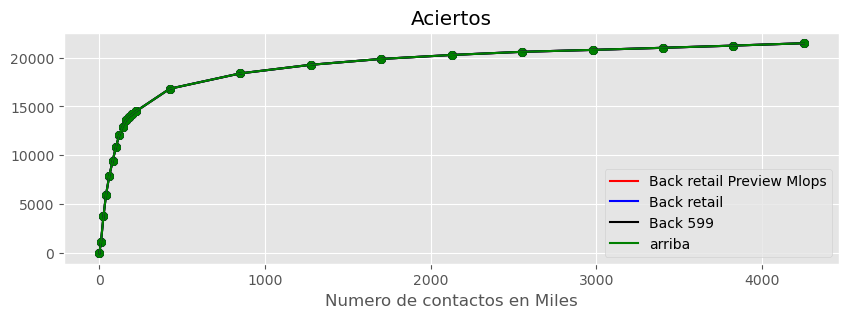

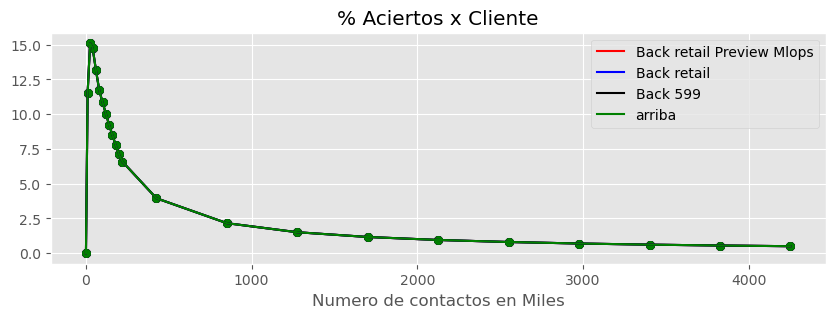

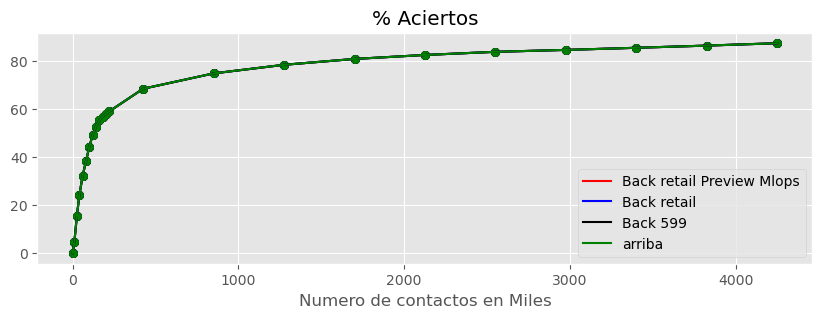

In [86]:
colors = ['red','blue','black','green']
for col in plots:
    bd_temp2 = plots_dict[col]
    bd_temp2.loc[0] = 0
    bd_temp2 = bd_temp2.sort_index(ascending=True)
    plt.figure(figsize=(10,3))
    plt.style.use('ggplot')
    for t,j in enumerate(bd_temp2.columns):
        bd_temp3 = bd_temp2[[j]]
        bd_temp3.index = bd_temp3.index/1000
        bd_temp3 = bd_temp3.dropna()
        plt.plot(bd_temp3.index,bd_temp3[j], label = j, c = colors[t])
        plt.scatter(bd_temp3.index,bd_temp3[j],c = colors[t])
    plt.title(col)
    plt.xlabel("Numero de contactos en Miles")
    plt.legend()
    plt.show()